In [1]:
# Cell 1: Import libraries và định nghĩa class GradCAM
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import os


In [2]:

class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize GradCAM
        Args:
            model: Pre-trained model
            target_layer: Layer để tính GradCAM (vd: model.layer4)
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        """Hook để lưu activation maps"""
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        """Hook để lưu gradients"""
        self.gradients = grad_output[0].detach()
    
    def compute_weights(self, class_idx):
        """
        Tính weights (alpha_i) theo công thức (1) của GradCAM paper
        alpha_i^c = (1/Z) * sum_{i,j} (dY^c / dA_ij^k)
        
        Args:
            class_idx: Index của predicted class
        Returns:
            weights: Tensor chứa weight của từng channel [n_channels]
        """
        # Gradients có shape [batch, channels, height, width]
        # Global Average Pooling của gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=False)  # [batch, channels]
        
        return weights.squeeze()  # [n_channels]
    
    def forward(self, x, class_idx=None):
        """
        Forward pass và tính GradCAM
        Args:
            x: Input image tensor [1, 3, H, W]
            class_idx: Target class index (None = predicted class)
        Returns:
            weights: Weight của từng channel (đã áp dụng ReLU)
            cam: GradCAM heatmap
            pred_class: Predicted class
        """
        # Forward pass
        self.model.eval()
        logits = self.model(x)
        
        # Nếu không chỉ định class, dùng predicted class
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward từ pre-softmax score của class c
        one_hot = torch.zeros_like(logits)
        one_hot[0, class_idx] = 1
        logits.backward(gradient=one_hot, retain_graph=True)
        
        # Tính weights (alpha_i)
        weights = self.compute_weights(class_idx)
        
        # ===== MODIFICATION 1: Áp dụng ReLU cho weights =====
        # Chuyển các weight âm thành 0
        weights = F.relu(weights)
        
        # Tính GradCAM: L^c = ReLU(sum_i alpha_i * A_i)
        activations = self.activations.squeeze()  # [channels, h, w]
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]

        print(f"Activations - min: {activations.min():.4f}, max: {activations.max():.4f}")
        
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)  # Normalize
        
        return weights, cam, class_idx

# ============================================================================
# Cell 2: Hàm phân tích weight distribution
# ============================================================================


In [3]:

def analyze_weight_distribution(weights, top_k=10):
    """
    Phân tích distribution của weights
    Args:
        weights: Tensor chứa weights của các channels
        top_k: Số lượng top channels để hiển thị
    """
    weights_np = weights.cpu().numpy()
    n_channels = len(weights_np)
    
    # Tạo figure với 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Histogram của weights
    axes[0].hist(weights_np, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Weight Value (α_i)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Channel Weights', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Statistics
    mean_w = weights_np.mean()
    std_w = weights_np.std()
    axes[0].axvline(mean_w, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_w:.4f}')
    axes[0].axvline(mean_w + std_w, color='orange', linestyle='--', linewidth=1.5, label=f'±1 Std: {std_w:.4f}')
    axes[0].axvline(mean_w - std_w, color='orange', linestyle='--', linewidth=1.5)
    axes[0].legend()
    
    # 2. Bar plot của top-k channels
    top_indices = np.argsort(weights_np)[-top_k:][::-1]
    top_weights = weights_np[top_indices]
    
    axes[1].bar(range(top_k), top_weights, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Rank', fontsize=12)
    axes[1].set_ylabel('Weight Value', fontsize=12)
    axes[1].set_title(f'Top-{top_k} Channel Weights', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(top_k))
    axes[1].set_xticklabels([f'Ch {idx}' for idx in top_indices], rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 3. Cumulative distribution
    sorted_weights = np.sort(weights_np)[::-1]
    cumsum = np.cumsum(sorted_weights)
    cumsum_normalized = cumsum / cumsum[-1] * 100 if cumsum[-1] > 0 else cumsum
    
    axes[2].plot(range(n_channels), cumsum_normalized, linewidth=2)
    axes[2].set_xlabel('Number of Channels', fontsize=12)
    axes[2].set_ylabel('Cumulative Weight (%)', fontsize=12)
    axes[2].set_title('Cumulative Weight Distribution', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
    axes[2].axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # In thống kê
    print("\n" + "="*60)
    print("WEIGHT DISTRIBUTION ANALYSIS")
    print("="*60)
    print(f"Total channels: {n_channels}")
    print(f"Mean weight: {mean_w:.6f}")
    print(f"Std weight: {std_w:.6f}")
    print(f"Min weight: {weights_np.min():.6f}")
    print(f"Max weight: {weights_np.max():.6f}")
    print(f"Weight range: {weights_np.max() - weights_np.min():.6f}")
    
    # Phân tích concentration
    total_weight = np.sum(np.abs(weights_np))
    if total_weight > 0:
        top_10_percent = int(n_channels * 0.1)
        top_10_weight = np.sum(np.abs(sorted_weights[:top_10_percent]))
        concentration_ratio = top_10_weight / total_weight * 100
        
        print(f"\nConcentration Analysis:")
        print(f"Top 10% channels ({top_10_percent} channels) contribute: {concentration_ratio:.2f}% of total weight")
        
        # Tìm số channels chiếm 50% và 80% weight
        if cumsum_normalized[-1] > 0:
            idx_50_list = np.where(cumsum_normalized >= 50)[0]
            idx_80_list = np.where(cumsum_normalized >= 80)[0]
            if len(idx_50_list) > 0:
                idx_50 = idx_50_list[0]
                print(f"Top {idx_50+1} channels contribute 50% of total weight")
            if len(idx_80_list) > 0:
                idx_80 = idx_80_list[0]
                print(f"Top {idx_80+1} channels contribute 80% of total weight")
        
        # Uniformity test (so sánh với uniform distribution)
        uniform_mean = 1.0 / n_channels
        normalized_weights = np.abs(weights_np) / total_weight
        kl_divergence = np.sum(normalized_weights * np.log((normalized_weights + 1e-10) / uniform_mean))
        print(f"\nKL Divergence from uniform: {kl_divergence:.6f}")
        if kl_divergence < 0.1:
            print("→ Distribution is nearly UNIFORM")
        elif kl_divergence < 1.0:
            print("→ Distribution is MODERATELY concentrated")
        else:
            print("→ Distribution is HIGHLY concentrated")
    
    print("\n" + "="*60)
    print(f"TOP-{top_k} CHANNELS WITH HIGHEST WEIGHTS")
    print("="*60)
    print(f"{'Rank':<6} {'Channel ID':<12} {'Weight':<15} {'% of Max':<12}")
    print("-"*60)
    
    for rank, (idx, weight) in enumerate(zip(top_indices, top_weights), 1):
        pct = weight / weights_np.max() * 100 if weights_np.max() > 0 else 0
        print(f"{rank:<6} {idx:<12} {weight:<15.6f} {pct:<12.2f}%")
    
    print("="*60)
    
    return top_indices, top_weights

# ============================================================================
# Cell 3: Các hàm visualization
# ============================================================================


In [4]:

def visualize_gradcam(original_img, cam, pred_class, class_name=None):
    """Visualize GradCAM heatmap (resize original image to cam size)"""
    # cam: tensor [H_act, W_act]
    h_act, w_act = cam.shape[-2], cam.shape[-1]
    # Resize original image down to activation map size
    img_resized = original_img.resize((w_act, h_act), resample=Image.BILINEAR)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Original (resized)
    axes[0].imshow(img_resized)
    axes[0].set_title('Original Image (resized to act map)', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # GradCAM heatmap (use cam as is)
    cam_np = cam.squeeze().cpu().numpy()
    axes[1].imshow(cam_np, cmap='jet')
    axes[1].set_title('GradCAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Overlay on resized image
    axes[2].imshow(img_resized)
    axes[2].imshow(cam_np, cmap='jet', alpha=0.5)
    title = f'GradCAM Overlay\nClass: {pred_class}'
    if class_name:
        title += f' ({class_name})'
    axes[2].set_title(title, fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def visualize_single_channel(original_img, activations, channel_id, weight=None, pred_class=None):
    """Visualize activation map của 1 channel cụ thể (resize original image to act map size)"""
    activation_map = activations[channel_id].cpu()  # [H_act, W_act]
    activation_map = activation_map - activation_map.min()
    activation_map = activation_map / (activation_map.max() + 1e-8)
    act_np = activation_map.squeeze().numpy()
    h_act, w_act = act_np.shape

    # Resize original image to activation map size
    img_resized = original_img.resize((w_act, h_act), resample=Image.BILINEAR)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_resized)
    title = 'Original Image'
    if pred_class is not None:
        title += f'\nClass: {pred_class}'
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].axis('off')

    im = axes[1].imshow(act_np, cmap='jet')
    title = f'Channel {channel_id} Activation'
    if weight is not None:
        title += f'\nWeight α = {weight:.6f}'
    axes[1].set_title(title, fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    axes[2].imshow(img_resized)
    axes[2].imshow(act_np, cmap='jet', alpha=0.5)
    axes[2].set_title(f'Channel {channel_id} Overlay', fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def visualize_top_channels(original_img, activations, weights, top_k=8, pred_class=None, 
                          img_name="image", layer_name="layer"):
    """
    Visualize original image (resized) and top-k channels
    ===== MODIFICATION 2: Lưu ảnh theo cấu trúc output/tên_ảnh/tên_layer =====
    """
    top_indices = torch.argsort(weights, descending=True)[:top_k].cpu().numpy()
    top_weights = weights[top_indices].cpu().numpy()

    # Total plots = 1 (original) + top_k channels
    n_cols = 3
    n_rows = ((1 + top_k) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    # Get activation map size from first channel
    first_act = activations[0].cpu()
    h_act, w_act = first_act.shape

    # Plot original image (resized to activation map size)
    img_resized = original_img.resize((w_act, h_act), resample=Image.BILINEAR)
    axes[0].imshow(img_resized)
    axes[0].set_title('Original Image (Resized)', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Plot top-k activation maps
    for idx, (channel_id, weight) in enumerate(zip(top_indices, top_weights), 1):
        activation_map = activations[channel_id].cpu()
        activation_map = activation_map - activation_map.min()
        activation_map = activation_map / (activation_map.max() + 1e-8)
        act_np = activation_map.squeeze().numpy()

        axes[idx].imshow(act_np, cmap='gray')
        axes[idx].set_title(f'Ch {channel_id} (α={weight:.4f})', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(1 + top_k, len(axes)):
        axes[idx].axis('off')

    title = f'Original + Top-{top_k} Channels: Image "{img_name}" (Layer: {layer_name})'
    if pred_class is not None:
        title += f'\nPredicted Class: {pred_class}'
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    
    # ===== MODIFICATION 2: Tạo cấu trúc thư mục và lưu ảnh =====
    clean_img_name = os.path.splitext(os.path.basename(img_name))[0].replace(' ', '_').lower()
    clean_layer_name = layer_name.replace(' ', '_').lower()
    
    # Tạo thư mục theo cấu trúc output/tên_ảnh/
    output_dir = os.path.join('output', clean_img_name)
    os.makedirs(output_dir, exist_ok=True)
    
    # Lưu file với tên layer
    filename = os.path.join(output_dir, f'{clean_layer_name}.png')
    
    try:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"[INFO] Đã lưu ảnh top channels vào: {filename}")
    except Exception as e:
        print(f"[ERROR] Không thể lưu ảnh: {e}")
    
    plt.show()


def visualize_channel_grid(original_img, activations, weights, channels=None, n_cols=4, pred_class=None):
    """Visualize nhiều channels trong một grid (resize image per activation)"""
    n_channels = activations.shape[0]
    if channels is None:
        n_samples = min(16, n_channels)
        channels = np.random.choice(n_channels, n_samples, replace=False)

    n_samples = len(channels)
    n_rows = (n_samples + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for idx, channel_id in enumerate(channels):
        activation_map = activations[channel_id].cpu()
        activation_map = activation_map - activation_map.min()
        activation_map = activation_map / (activation_map.max() + 1e-8)
        act_np = activation_map.squeeze().numpy()
        h_act, w_act = act_np.shape

        img_resized = original_img.resize((w_act, h_act), resample=Image.BILINEAR)

        axes[idx].imshow(act_np, cmap='gray')
        weight = weights[channel_id].item()
        axes[idx].set_title(f'Ch {channel_id}\nα={weight:.4f}', fontsize=10, fontweight='bold')
        axes[idx].axis('off')

    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')

    title = f'Channel Activation Maps'
    if pred_class is not None:
        title += f' (Class: {pred_class})'
    fig.suptitle(title, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


def compare_channels(original_img, activations, weights, channel_ids, pred_class=None):
    """So sánh trực tiếp nhiều channels (resize image per activation)"""
    n_channels = len(channel_ids)
    fig, axes = plt.subplots(2, n_channels, figsize=(5*n_channels, 10))
    if n_channels == 1:
        axes = axes.reshape(-1, 1)

    for idx, channel_id in enumerate(channel_ids):
        activation_map = activations[channel_id].cpu()
        activation_map = activation_map - activation_map.min()
        activation_map = activation_map / (activation_map.max() + 1e-8)
        act_np = activation_map.squeeze().numpy()
        h_act, w_act = act_np.shape

        # Resize original image to activation map size
        img_resized = original_img.resize((w_act, h_act), resample=Image.BILINEAR)

        im = axes[0, idx].imshow(act_np, cmap='jet')
        axes[0, idx].set_title(f'Channel {channel_id}\nα={weights[channel_id].item():.6f}', fontsize=12, fontweight='bold')
        axes[0, idx].axis('off')
        plt.colorbar(im, ax=axes[0, idx], fraction=0.046, pad=0.04)

        axes[1, idx].imshow(img_resized)
        axes[1, idx].imshow(act_np, cmap='jet', alpha=0.5)
        axes[1, idx].set_title('Overlay', fontsize=12, fontweight='bold')
        axes[1, idx].axis('off')

    title = f'Channel Comparison'
    if pred_class is not None:
        title += f' (Class: {pred_class})'
    fig.suptitle(title, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


In [5]:

# ============================================================================
# Cell 4: Load model
# ============================================================================

from torchvision import models
# Load pre-trained AlexNet
model = models.alexnet(pretrained=True)
model.eval()


/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:

# ============================================================================
# Cell 5: Xem cấu trúc model
# ============================================================================

model.features


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [7]:

# ============================================================================
# Cell 6: Prepare images
# ============================================================================

# Prepare image
img_path1 = 'Frog1.JPEG'  # Thay đổi path
img_path2 = 'Frog2.JPEG'
class_idx = None
img1 = Image.open(img_path1).convert('RGB')
img2 = Image.open(img_path2).convert('RGB')

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

img_tensor1 = transform(img1).unsqueeze(0)
img_tensor2 = transform(img2).unsqueeze(0)


In [8]:

# ============================================================================
# Cell 7: Hàm so sánh top channels giữa 2 ảnh
# ============================================================================

def compare_top_channels_across_images(model, img1_tensor, img2_tensor, layer_index, 
                                      img1_name, img2_name, top_k=10, 
                                      class_idx1=None, class_idx2=None):
    """
    So sánh top-k channels của Layer layer_index giữa hai ảnh.
    """
    # 1. Target layer
    target_layer = model.features[layer_index]
    layer_name_str = f"Layer {layer_index}"

    print(f"\n==================================================================================")
    print(f"  SO SÁNH TOP-{top_k} CHANNELS CỦA {layer_name_str} GIỮA \"{img1_name}\" VÀ \"{img2_name}\"")
    print(f"==================================================================================")

    # 2. Compute GradCAM for Image 1
    gradcam1 = GradCAM(model, target_layer)
    weights1, _, pred_class1 = gradcam1.forward(img1_tensor, class_idx=class_idx1)
    weights1_np = weights1.cpu().numpy()
    
    # 3. Compute GradCAM for Image 2
    gradcam2 = GradCAM(model, target_layer)
    weights2, _, pred_class2 = gradcam2.forward(img2_tensor, class_idx=class_idx2)
    weights2_np = weights2.cpu().numpy()
    
    print(f"Predicted class for {img1_name}: {pred_class1}")
    print(f"Predicted class for {img2_name}: {pred_class2}")
    
    # 4. Get Top-K channels and weights from Image 1
    top_indices_1 = np.argsort(weights1_np)[-top_k:][::-1]
    top_weights_1 = weights1_np[top_indices_1]
    
    # 5. Calculate Ranks in Image 2
    sorted_indices_2 = np.argsort(weights2_np)[::-1]
    rank_map_2 = {channel_id: rank for rank, channel_id in enumerate(sorted_indices_2)}
    
    # Total absolute weight for normalization in Image 2
    total_abs_weight_2 = np.sum(np.abs(weights2_np))
    
    # 6. Print Comparison Table
    print("\n" + "="*85)
    print(f"| {'Rank 1':<6} | {'Channel ID':<12} | {'Weight 1':<15} | {'Rank 2':<6} | {'Weight 2':<15} | {'% Contrib 2':<15} |")
    print("="*85)
    
    for rank1, (channel_id, weight1) in enumerate(zip(top_indices_1, top_weights_1), 1):
        weight2 = weights2_np[channel_id]
        rank2 = rank_map_2.get(channel_id, -1) + 1
        contribution_pct_2 = (np.abs(weight2) / total_abs_weight_2) * 100 if total_abs_weight_2 > 0 else 0
        
        print(f"| {rank1:<6} | {channel_id:<12} | {weight1:<15.6f} | {rank2:<6} | {weight2:<15.6f} | {contribution_pct_2:<15.2f}% |")
    
    print("="*85)


In [17]:

# ============================================================================
# Cell 8: Hàm analyze_layer chính
# ============================================================================

def analyze_layer(model, img_tensor, original_img, layer_index, layer_name_str, 
                 img_path_str, class_idx=None):
    """Phân tích một layer cụ thể"""
    # Target layer
    target_layer = model.features[layer_index]

    # Initialize GradCAM
    gradcam = GradCAM(model, target_layer)

    # Compute GradCAM
    weights, cam, pred_class = gradcam.forward(img_tensor, class_idx=class_idx)

    print(f"\n========================================================")
    print(f"  PHÂN TÍCH LAYER: {layer_name_str} (Index: {layer_index})")
    print(f"========================================================")
    print(f"Predicted class: {pred_class}")
    print(f"Number of channels: {len(weights)}")
    print(f"Number of non-zero weights: {(weights > 0).sum().item()}")
    print(f"Number of zero weights (after ReLU): {(weights == 0).sum().item()}")

    # Analyze weight distribution
    top_channels, top_weights = analyze_weight_distribution(weights, top_k=15)

    # Visualize với cấu trúc thư mục mới
    visualize_top_channels(original_img, gradcam.activations.squeeze(), 
                          weights, top_k=8, pred_class=pred_class,
                          img_name=img_path_str,
                          layer_name=layer_name_str)

    visualize_gradcam(original_img, cam, pred_class)
    


In [18]:

# ============================================================================
# Cell 9-14: Phân tích từng layer
# ============================================================================


/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 22.2821

  PHÂN TÍCH LAYER: Relu1 (Index: 1)
Predicted class: 31
Number of channels: 64
Number of non-zero weights: 30
Number of zero weights (after ReLU): 34


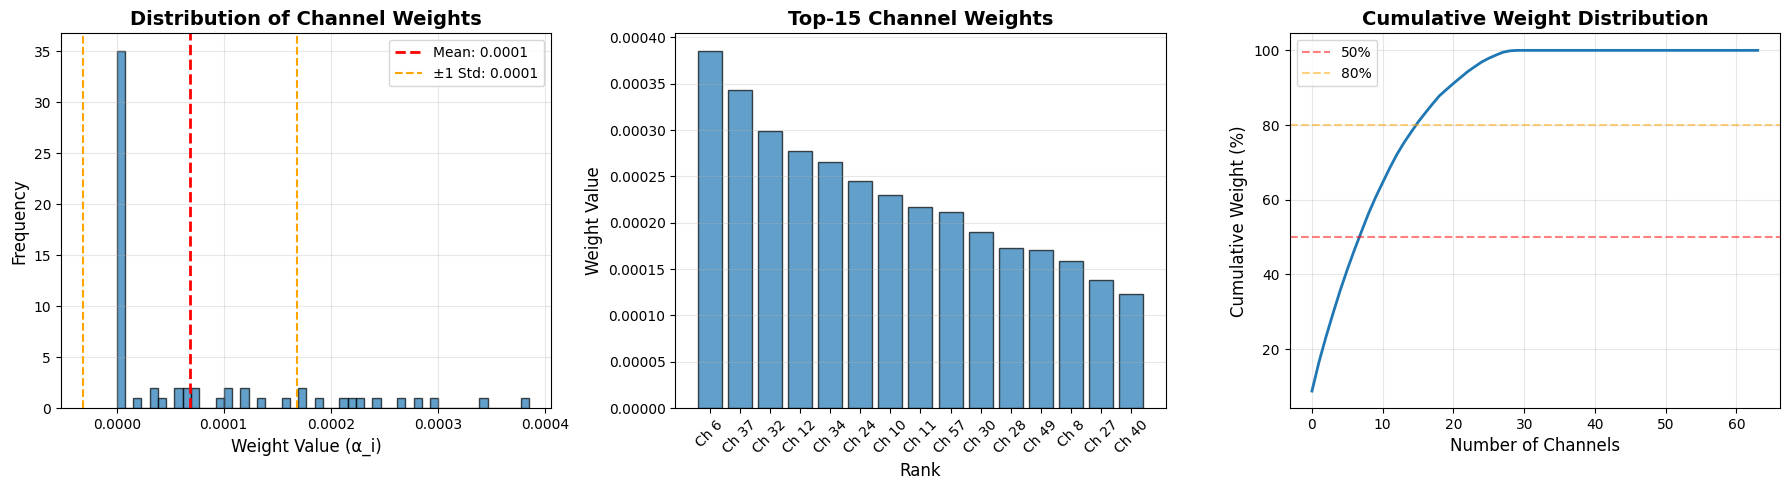


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 64
Mean weight: 0.000069
Std weight: 0.000100
Min weight: 0.000000
Max weight: 0.000385
Weight range: 0.000385

Concentration Analysis:
Top 10% channels (6 channels) contribute: 41.34% of total weight
Top 8 channels contribute 50% of total weight
Top 16 channels contribute 80% of total weight

KL Divergence from uniform: 0.995510
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      6            0.000385        100.00      %
2      37           0.000343        89.16       %
3      32           0.000299        77.60       %
4      12           0.000277        72.04       %
5      34           0.000266        68.97       %
6      24           0.000245        63.64       %
7      10           0.000230        59.64       %
8      11           0.000217        56.36       %
9      57           0.000212    

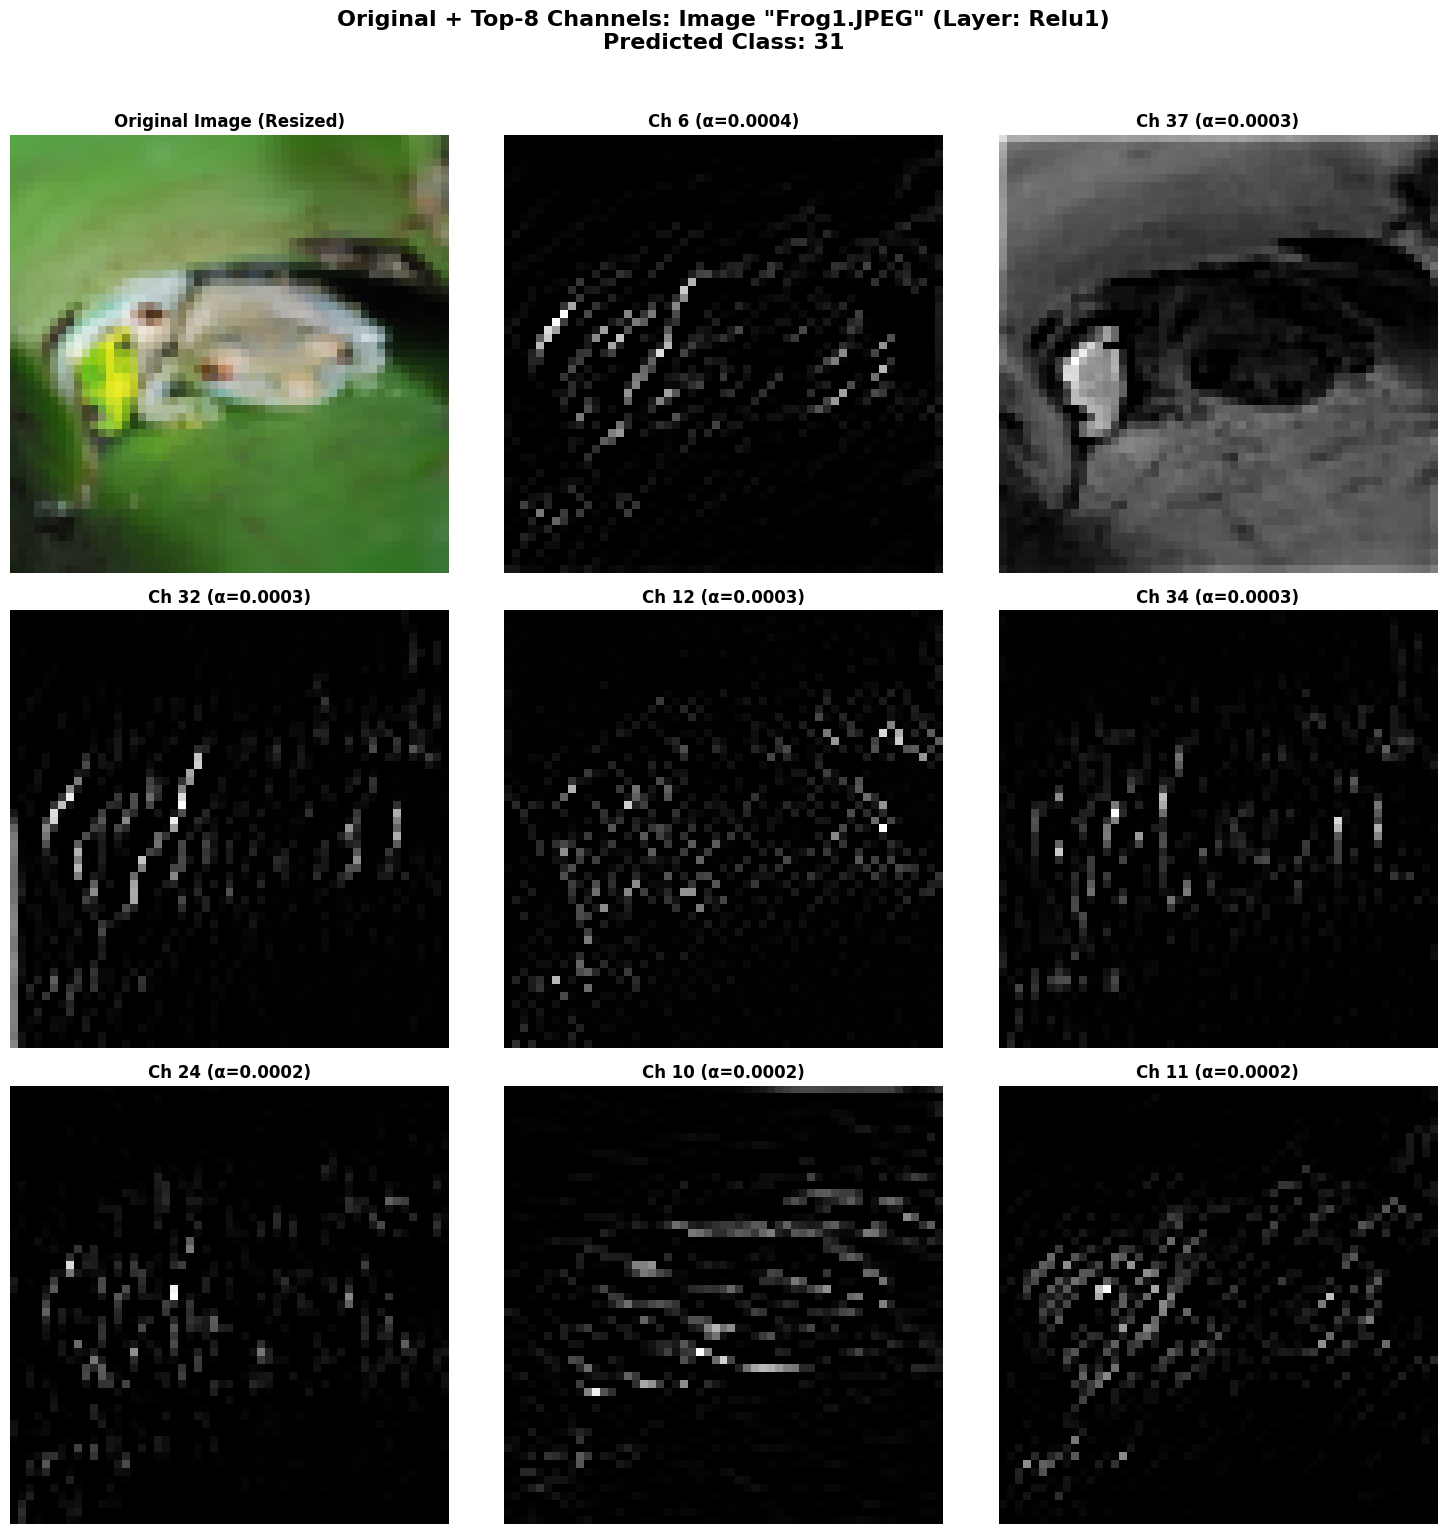

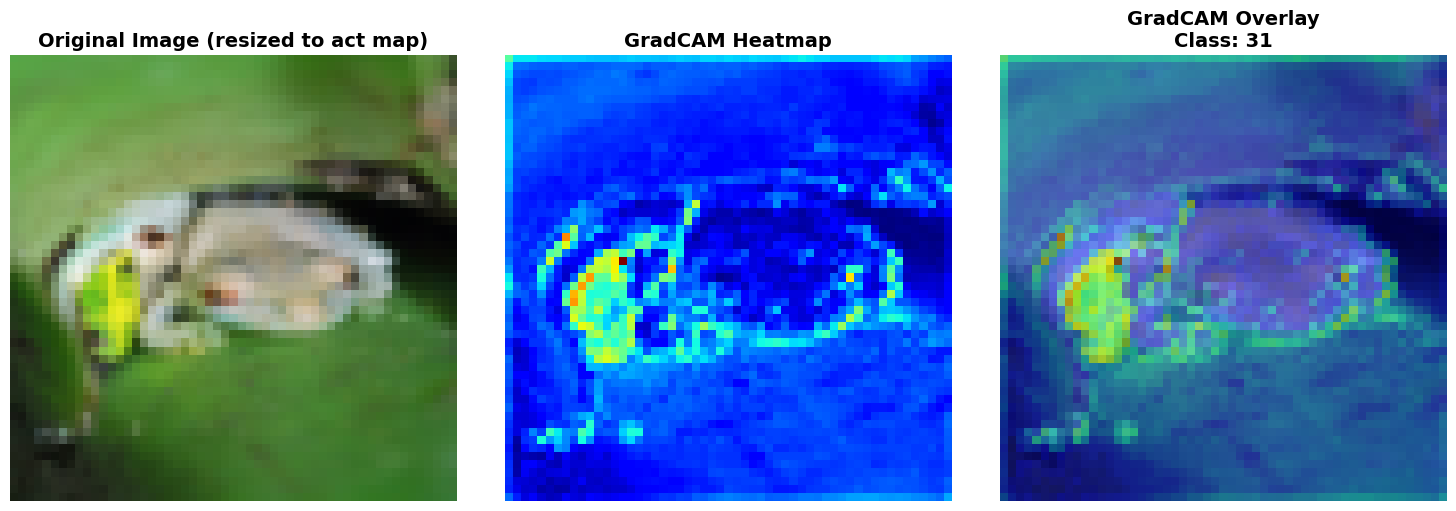

In [19]:

# Cell 9: Relu1
analyze_layer(model, img_tensor1, img1, 1, "Relu1", img_path1, class_idx)


/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 20.2006

  PHÂN TÍCH LAYER: Relu1 (Index: 1)
Predicted class: 31
Number of channels: 64
Number of non-zero weights: 24
Number of zero weights (after ReLU): 40


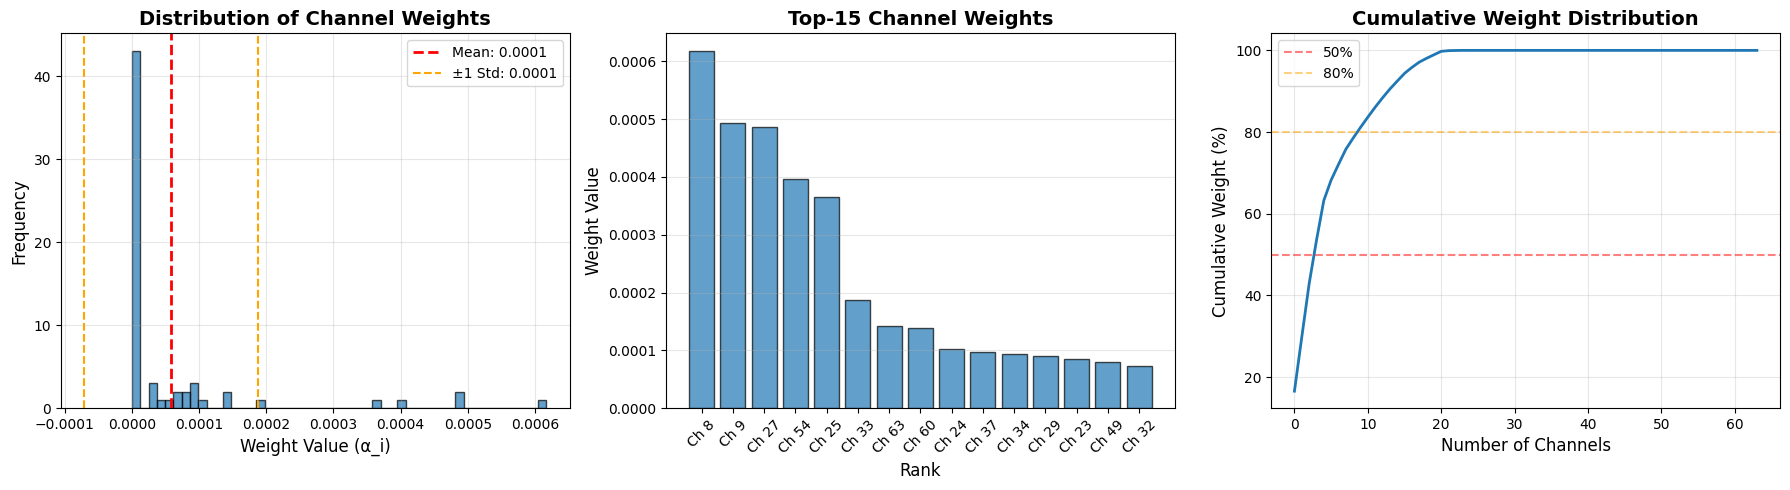


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 64
Mean weight: 0.000058
Std weight: 0.000130
Min weight: 0.000000
Max weight: 0.000617
Weight range: 0.000617

Concentration Analysis:
Top 10% channels (6 channels) contribute: 68.25% of total weight
Top 4 channels contribute 50% of total weight
Top 10 channels contribute 80% of total weight

KL Divergence from uniform: 1.508333
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      8            0.000617        100.00      %
2      9            0.000493        79.90       %
3      27           0.000486        78.78       %
4      54           0.000396        64.22       %
5      25           0.000365        59.13       %
6      33           0.000187        30.29       %
7      63           0.000143        23.10       %
8      60           0.000138        22.42       %
9      24           0.000102        

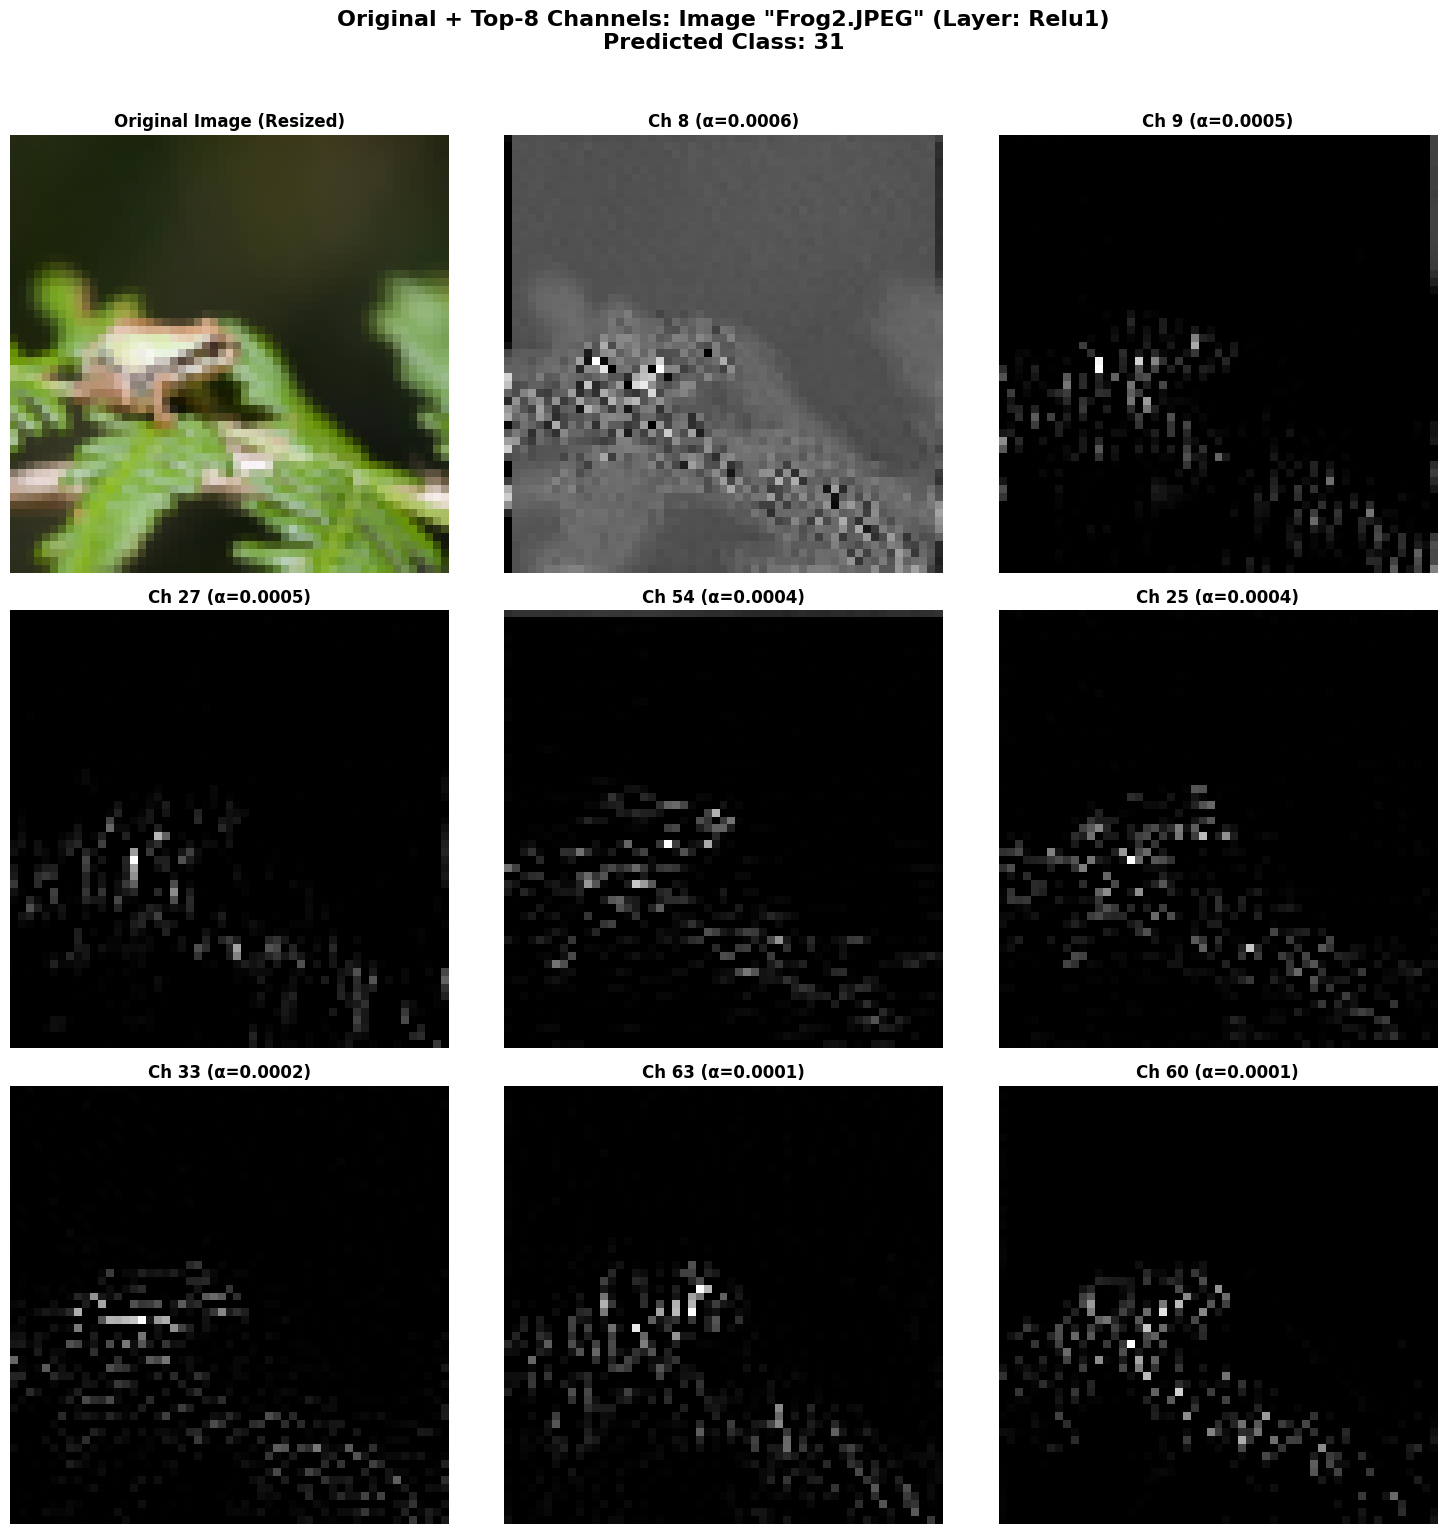

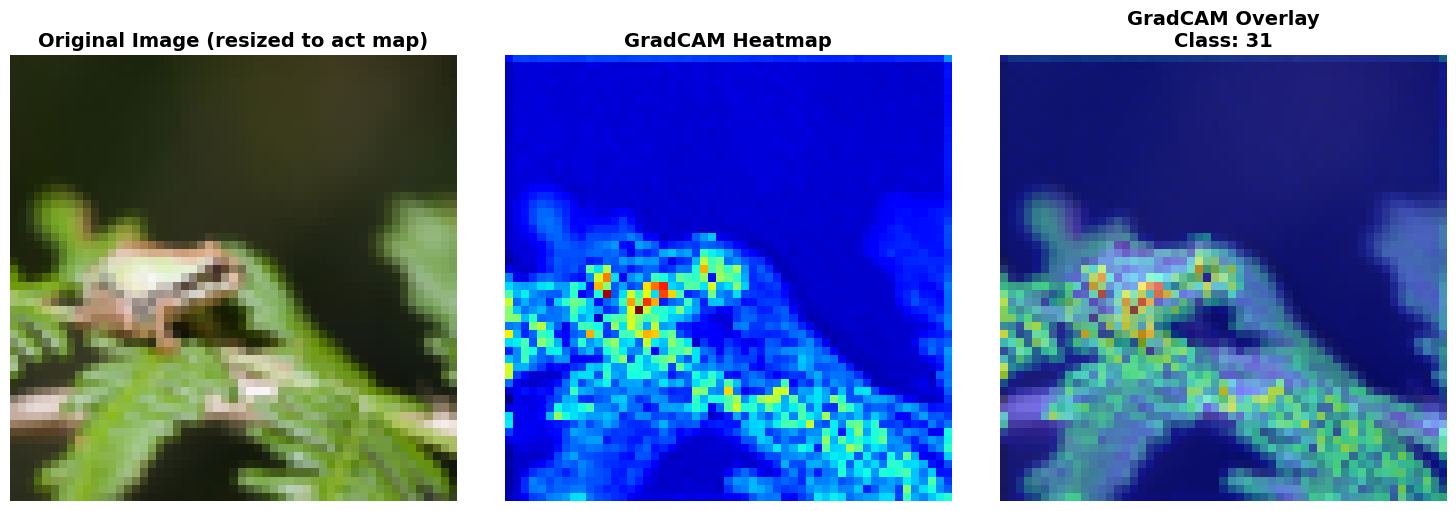

In [20]:
# Cell 10: Relu1 of img2
analyze_layer(model, img_tensor2, img2, 1, "Relu1", img_path2, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 37.0083

  PHÂN TÍCH LAYER: Relu2 (Index: 4)
Predicted class: 31
Number of channels: 192
Number of non-zero weights: 101
Number of zero weights (after ReLU): 91


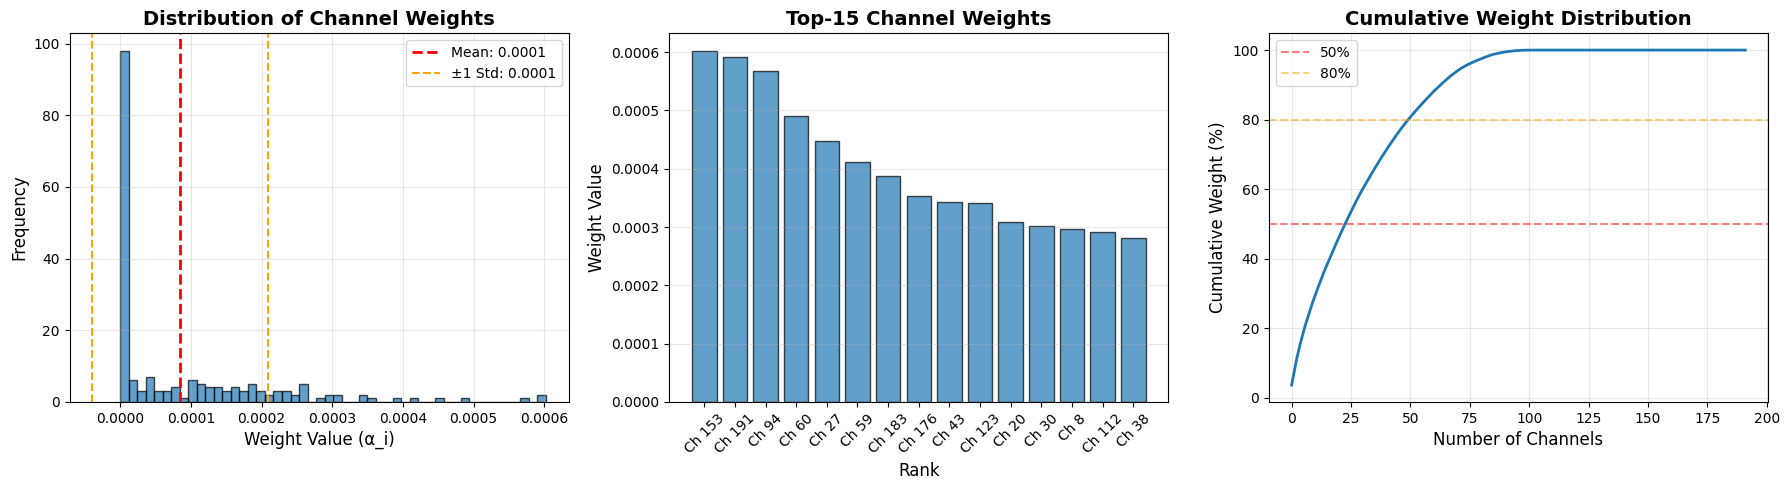


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 192
Mean weight: 0.000085
Std weight: 0.000125
Min weight: 0.000000
Max weight: 0.000602
Weight range: 0.000602

Concentration Analysis:
Top 10% channels (19 channels) contribute: 43.22% of total weight
Top 24 channels contribute 50% of total weight
Top 51 channels contribute 80% of total weight

KL Divergence from uniform: 0.958545
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      153          0.000602        100.00      %
2      191          0.000593        98.39       %
3      94           0.000568        94.31       %
4      60           0.000490        81.32       %
5      27           0.000448        74.36       %
6      59           0.000412        68.45       %
7      183          0.000388        64.40       %
8      176          0.000353        58.55       %
9      43           0.000344 

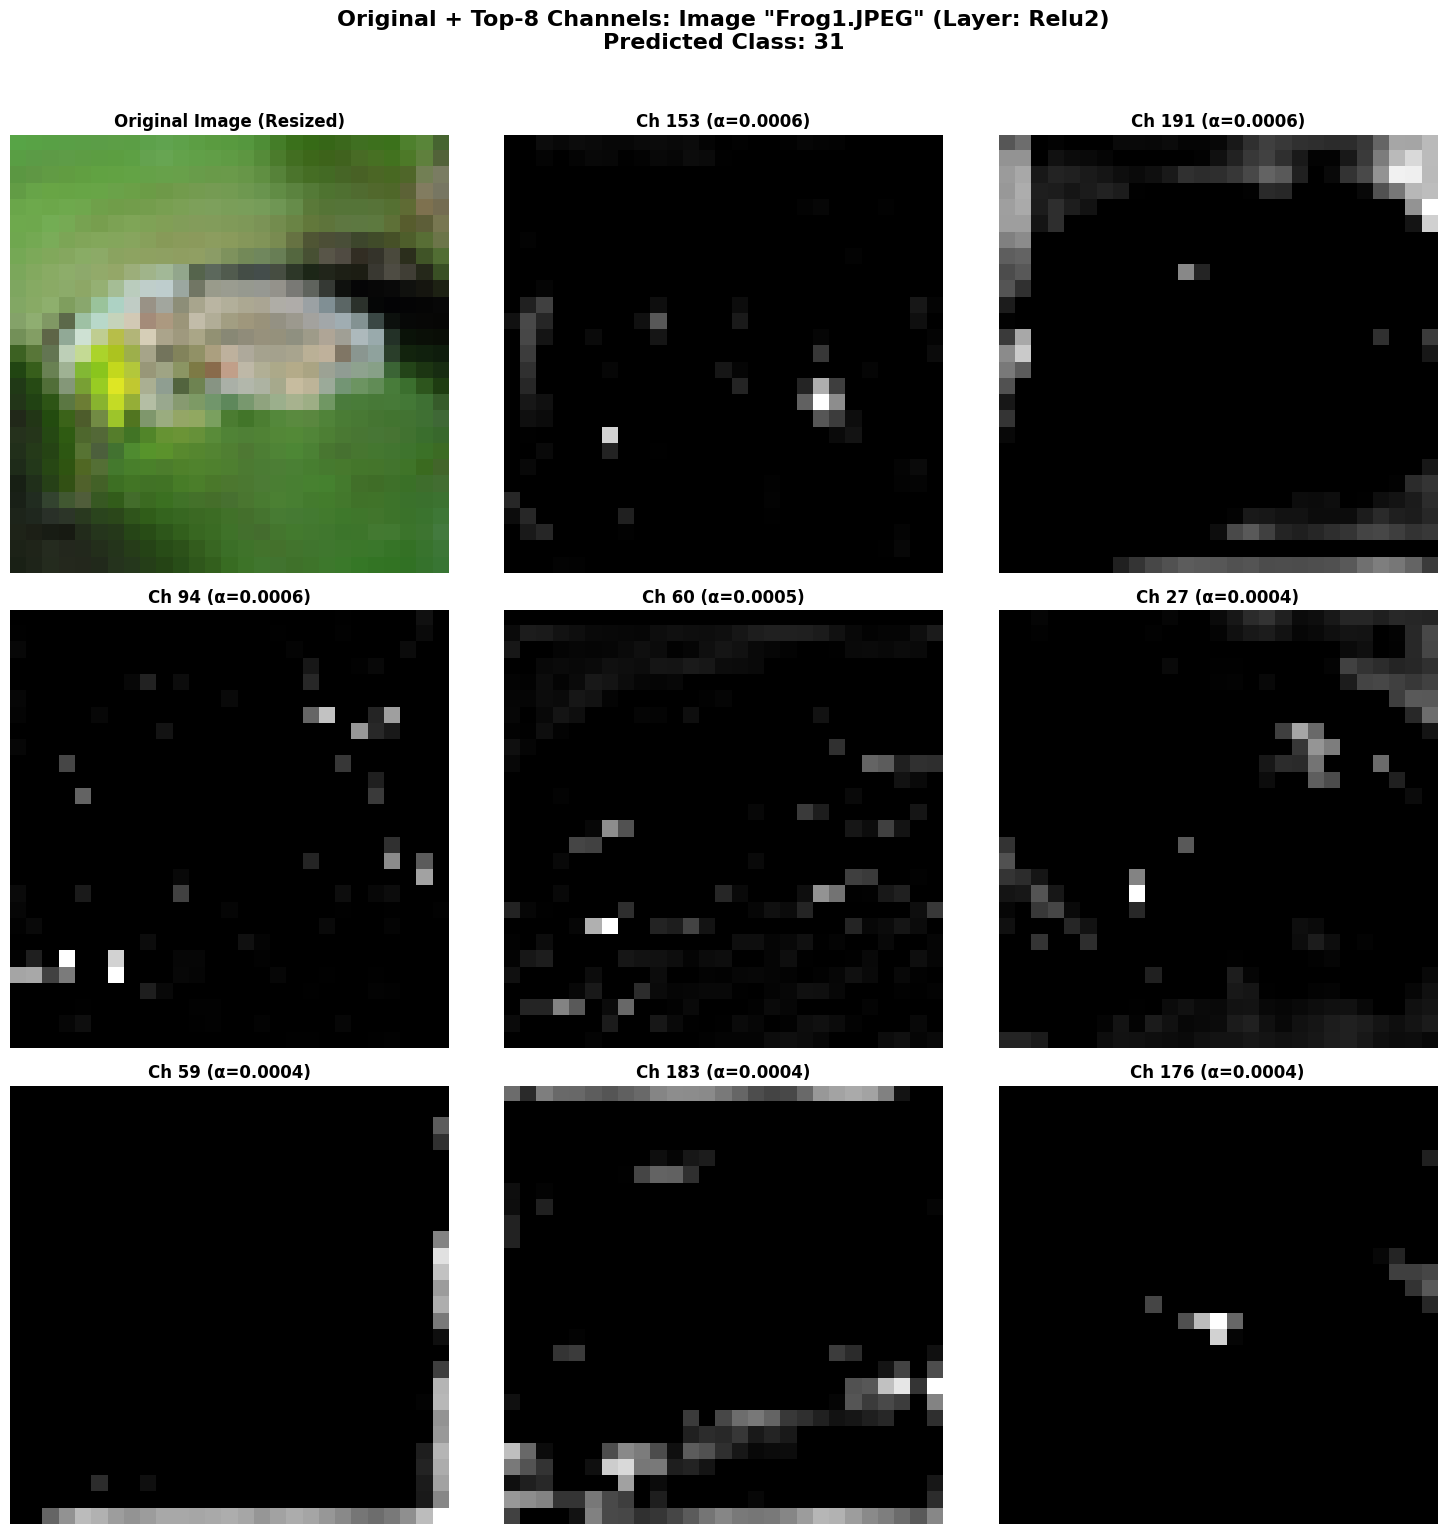

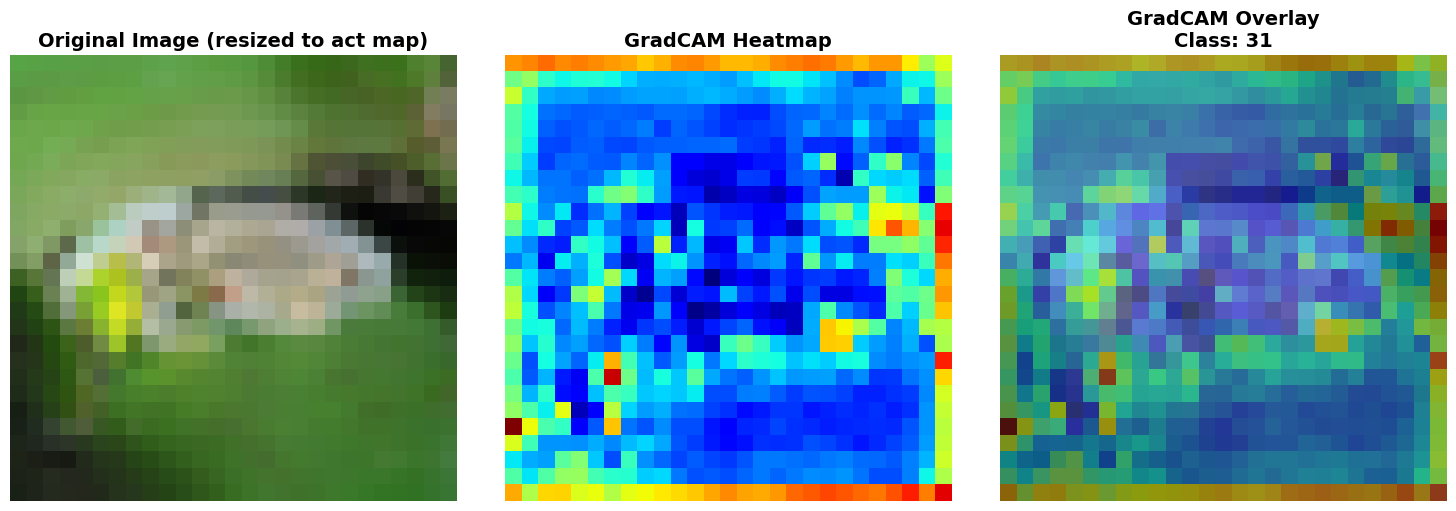

In [21]:
# Cell 11: Relu2 of Img1
analyze_layer(model, img_tensor1, img1, 4, "Relu2", img_path1, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 37.8473

  PHÂN TÍCH LAYER: Relu2 (Index: 4)
Predicted class: 31
Number of channels: 192
Number of non-zero weights: 80
Number of zero weights (after ReLU): 112


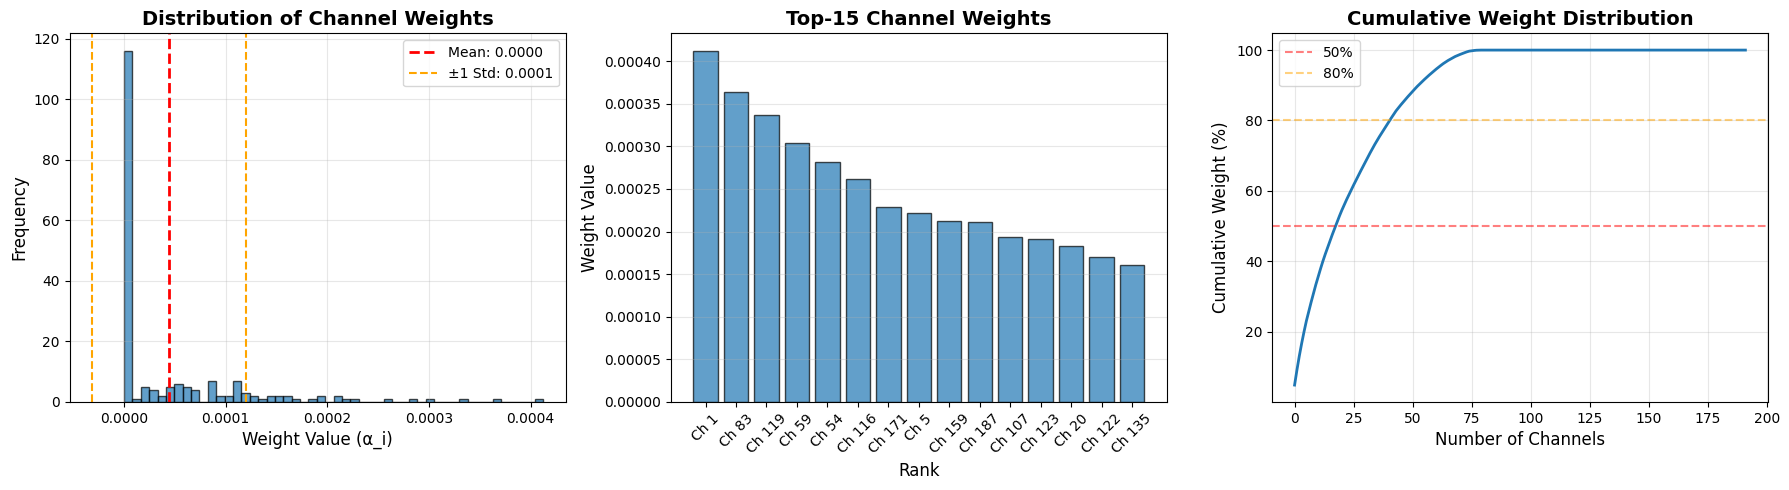


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 192
Mean weight: 0.000044
Std weight: 0.000076
Min weight: 0.000000
Max weight: 0.000412
Weight range: 0.000412

Concentration Analysis:
Top 10% channels (19 channels) contribute: 51.13% of total weight
Top 19 channels contribute 50% of total weight
Top 42 channels contribute 80% of total weight

KL Divergence from uniform: 1.163723
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      1            0.000412        100.00      %
2      83           0.000364        88.36       %
3      119          0.000337        81.67       %
4      59           0.000304        73.80       %
5      54           0.000282        68.35       %
6      116          0.000262        63.54       %
7      171          0.000229        55.62       %
8      5            0.000222        53.81       %
9      159          0.000212     

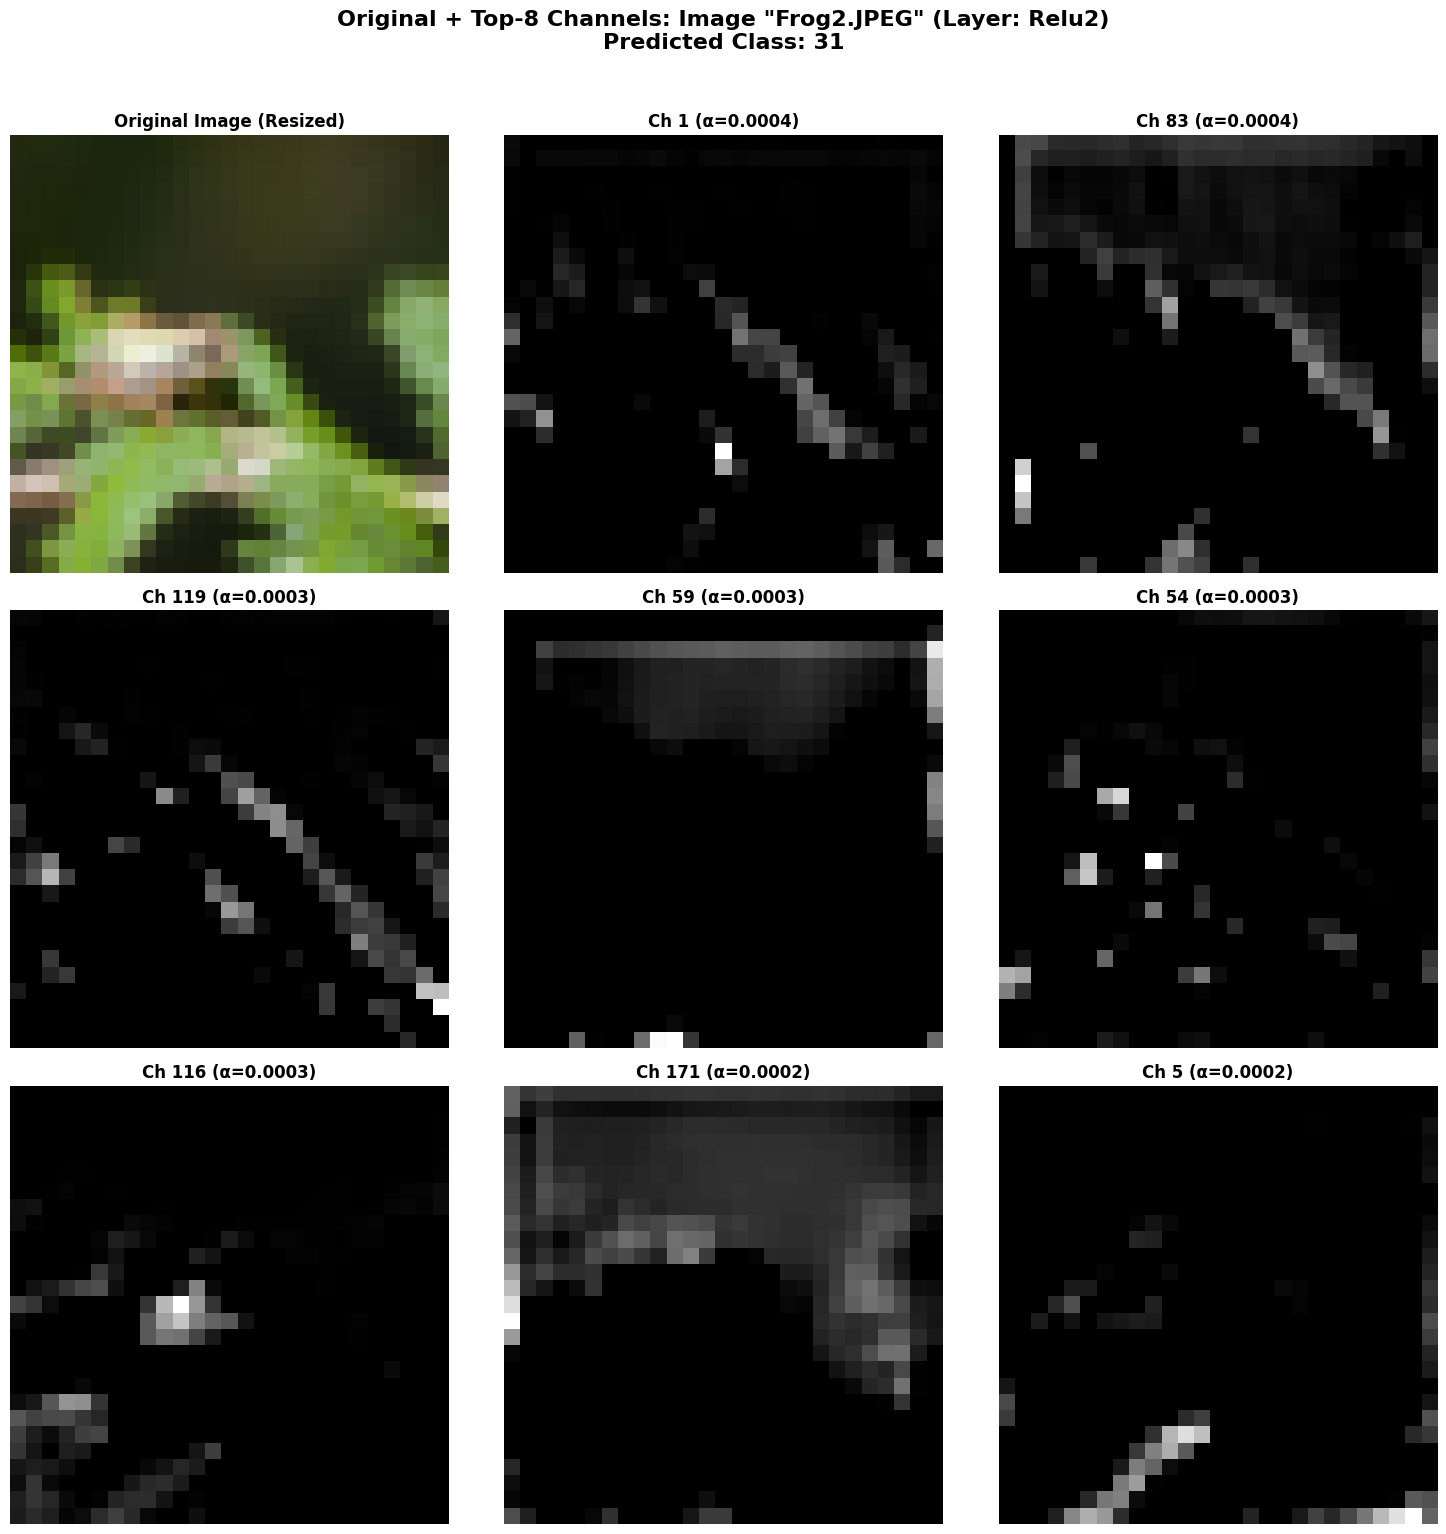

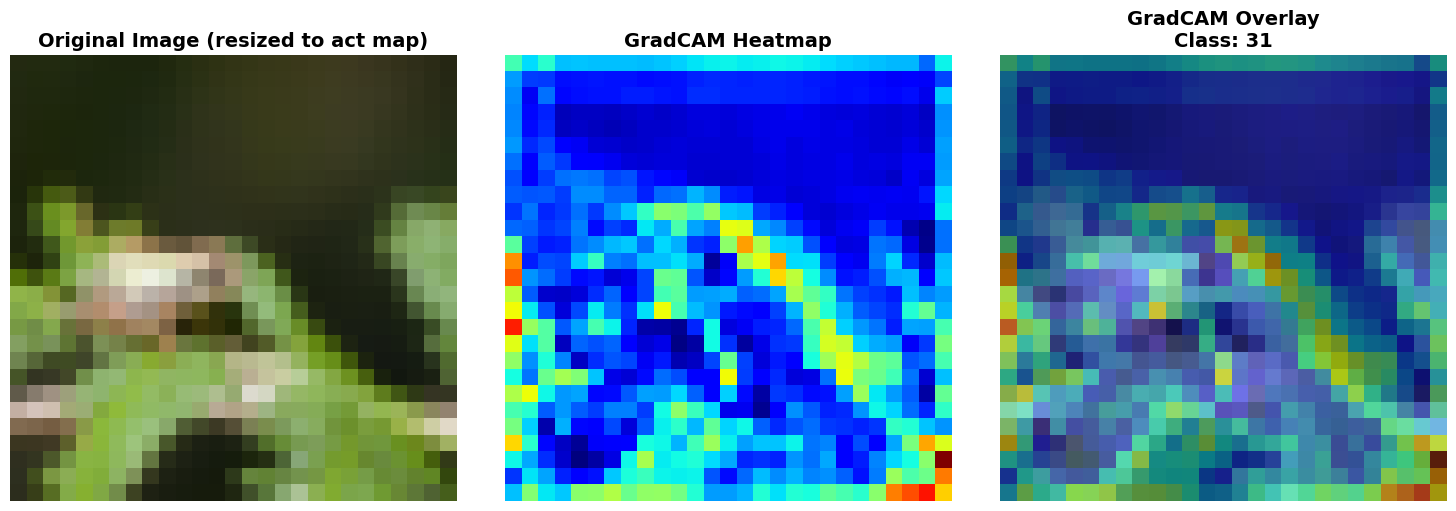

In [22]:
# Relu 2 of Img2
analyze_layer(model, img_tensor2, img2, 4, "Relu2", img_path2, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 30.9220

  PHÂN TÍCH LAYER: Relu3 (Index: 7)
Predicted class: 31
Number of channels: 384
Number of non-zero weights: 176
Number of zero weights (after ReLU): 208


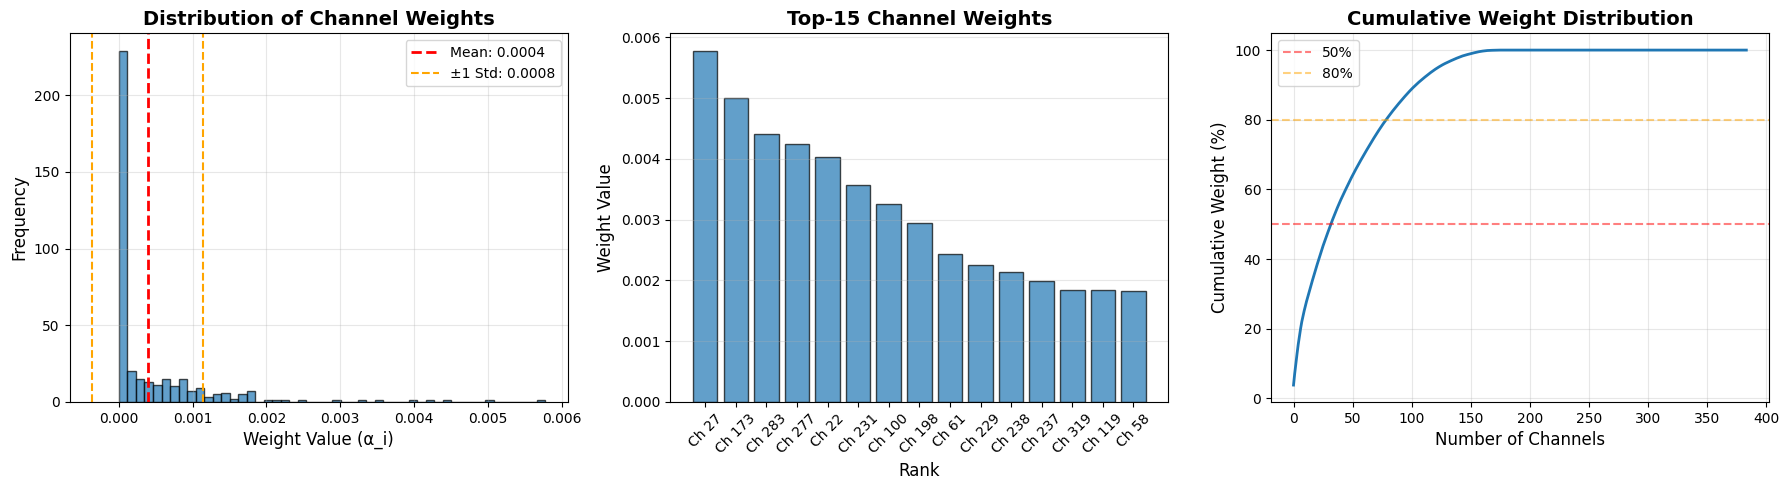


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 384
Mean weight: 0.000393
Std weight: 0.000753
Min weight: 0.000000
Max weight: 0.005776
Weight range: 0.005776

Concentration Analysis:
Top 10% channels (38 channels) contribute: 54.68% of total weight
Top 33 channels contribute 50% of total weight
Top 80 channels contribute 80% of total weight

KL Divergence from uniform: 1.221177
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      27           0.005776        100.00      %
2      173          0.004994        86.48       %
3      283          0.004401        76.21       %
4      277          0.004243        73.47       %
5      22           0.004029        69.76       %
6      231          0.003563        61.70       %
7      100          0.003252        56.31       %
8      198          0.002936        50.83       %
9      61           0.002430     

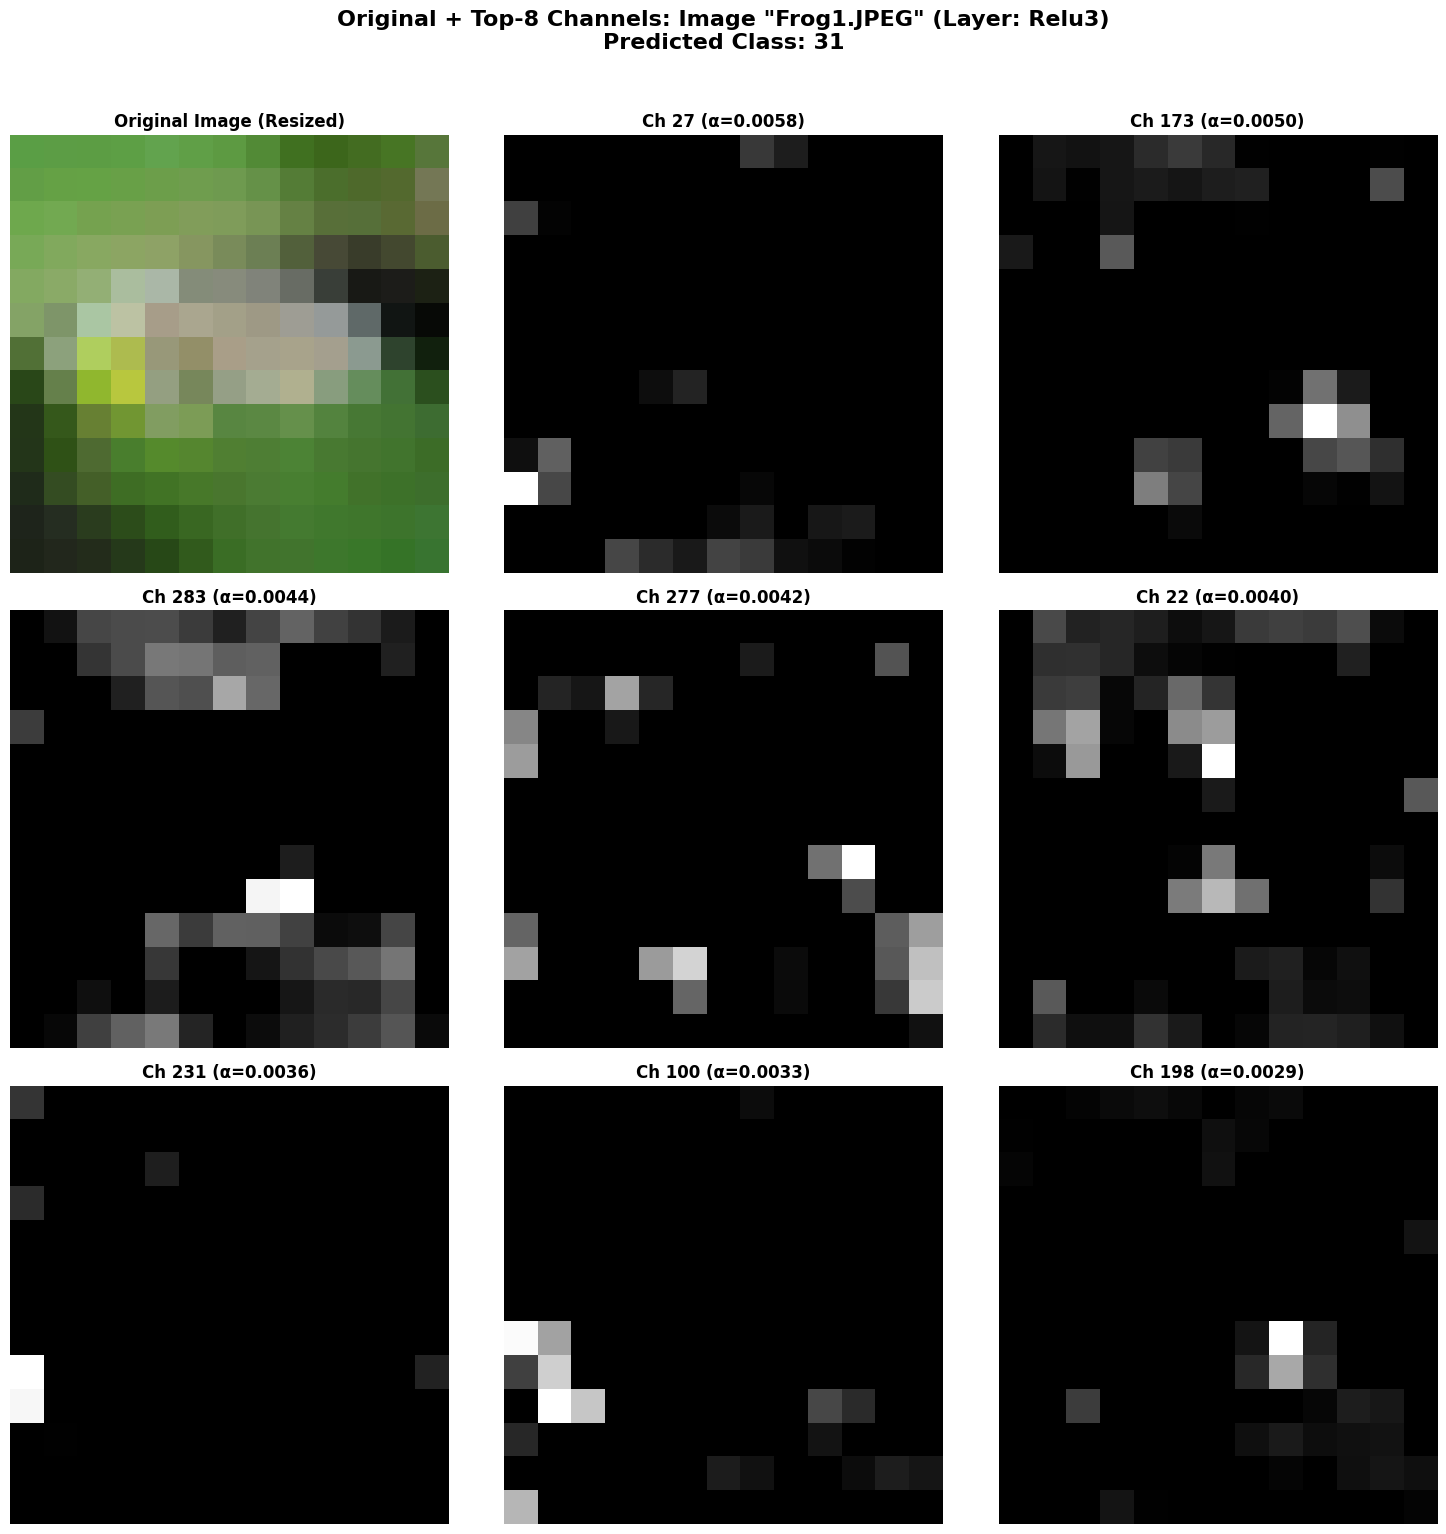

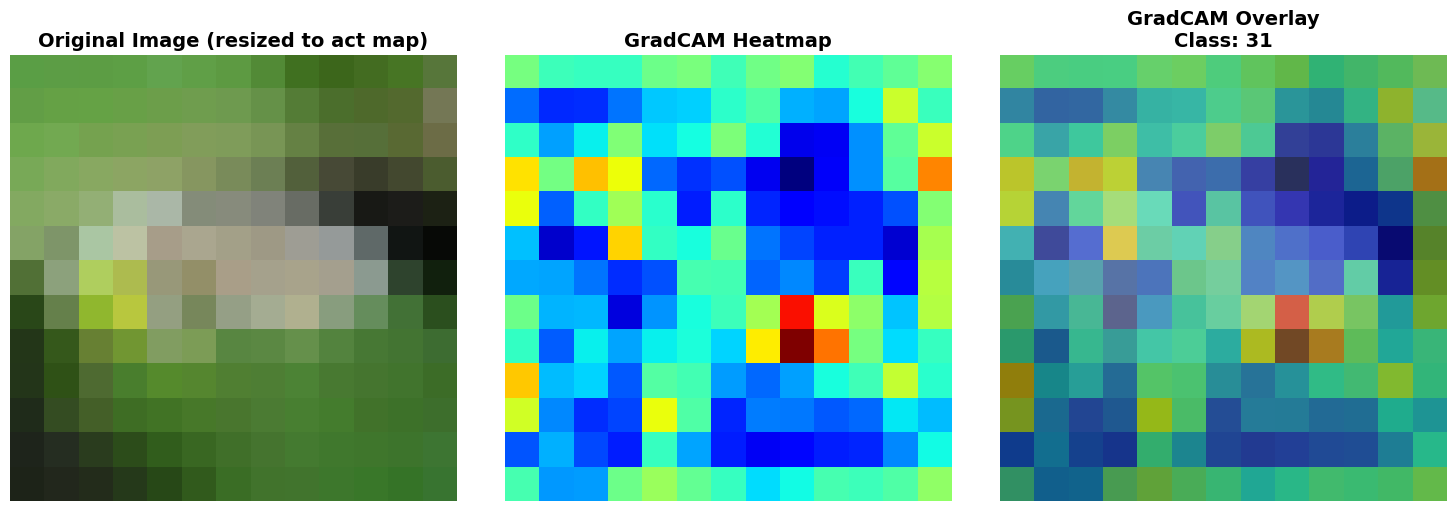

In [23]:
# Relu 3 of Img1
analyze_layer(model, img_tensor1, img1, 7, "Relu3", img_path1, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 28.6765

  PHÂN TÍCH LAYER: Relu3 (Index: 7)
Predicted class: 31
Number of channels: 384
Number of non-zero weights: 179
Number of zero weights (after ReLU): 205


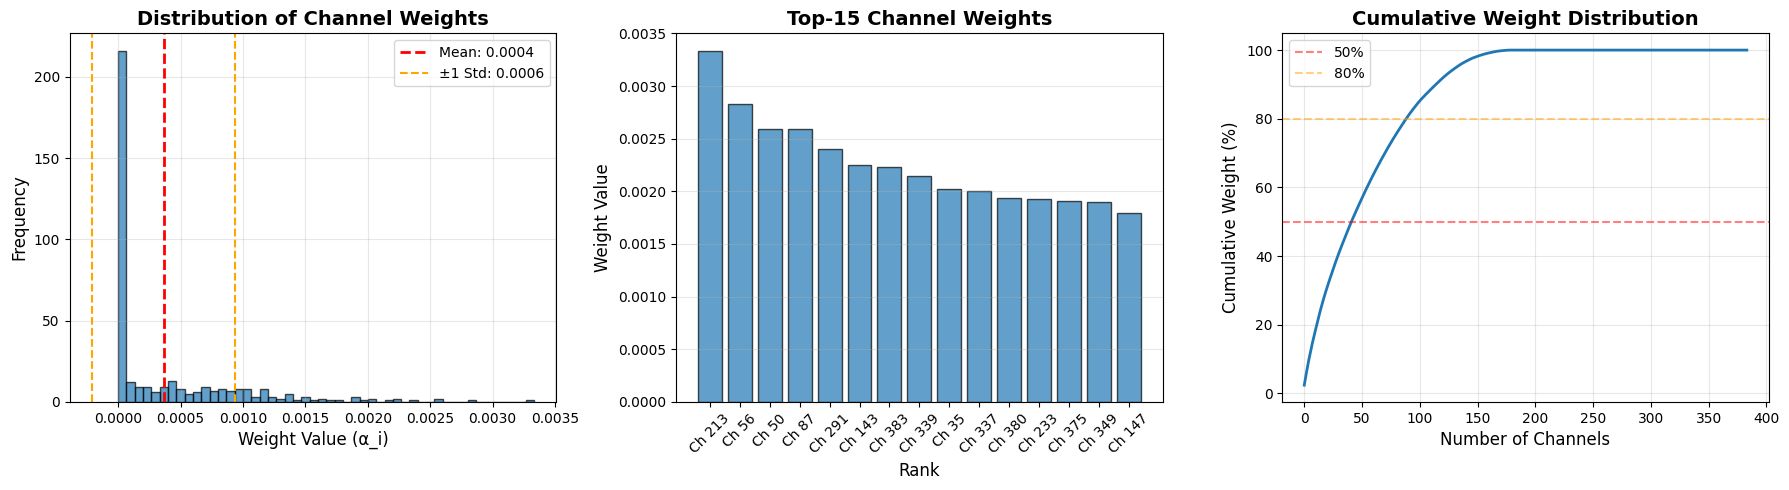


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 384
Mean weight: 0.000364
Std weight: 0.000575
Min weight: 0.000000
Max weight: 0.003334
Weight range: 0.003334

Concentration Analysis:
Top 10% channels (38 channels) contribute: 46.92% of total weight
Top 42 channels contribute 50% of total weight
Top 90 channels contribute 80% of total weight

KL Divergence from uniform: 1.064715
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      213          0.003334        100.00      %
2      56           0.002832        84.94       %
3      50           0.002592        77.76       %
4      87           0.002589        77.67       %
5      291          0.002400        71.98       %
6      143          0.002254        67.61       %
7      383          0.002234        67.01       %
8      339          0.002150        64.50       %
9      35           0.002026     

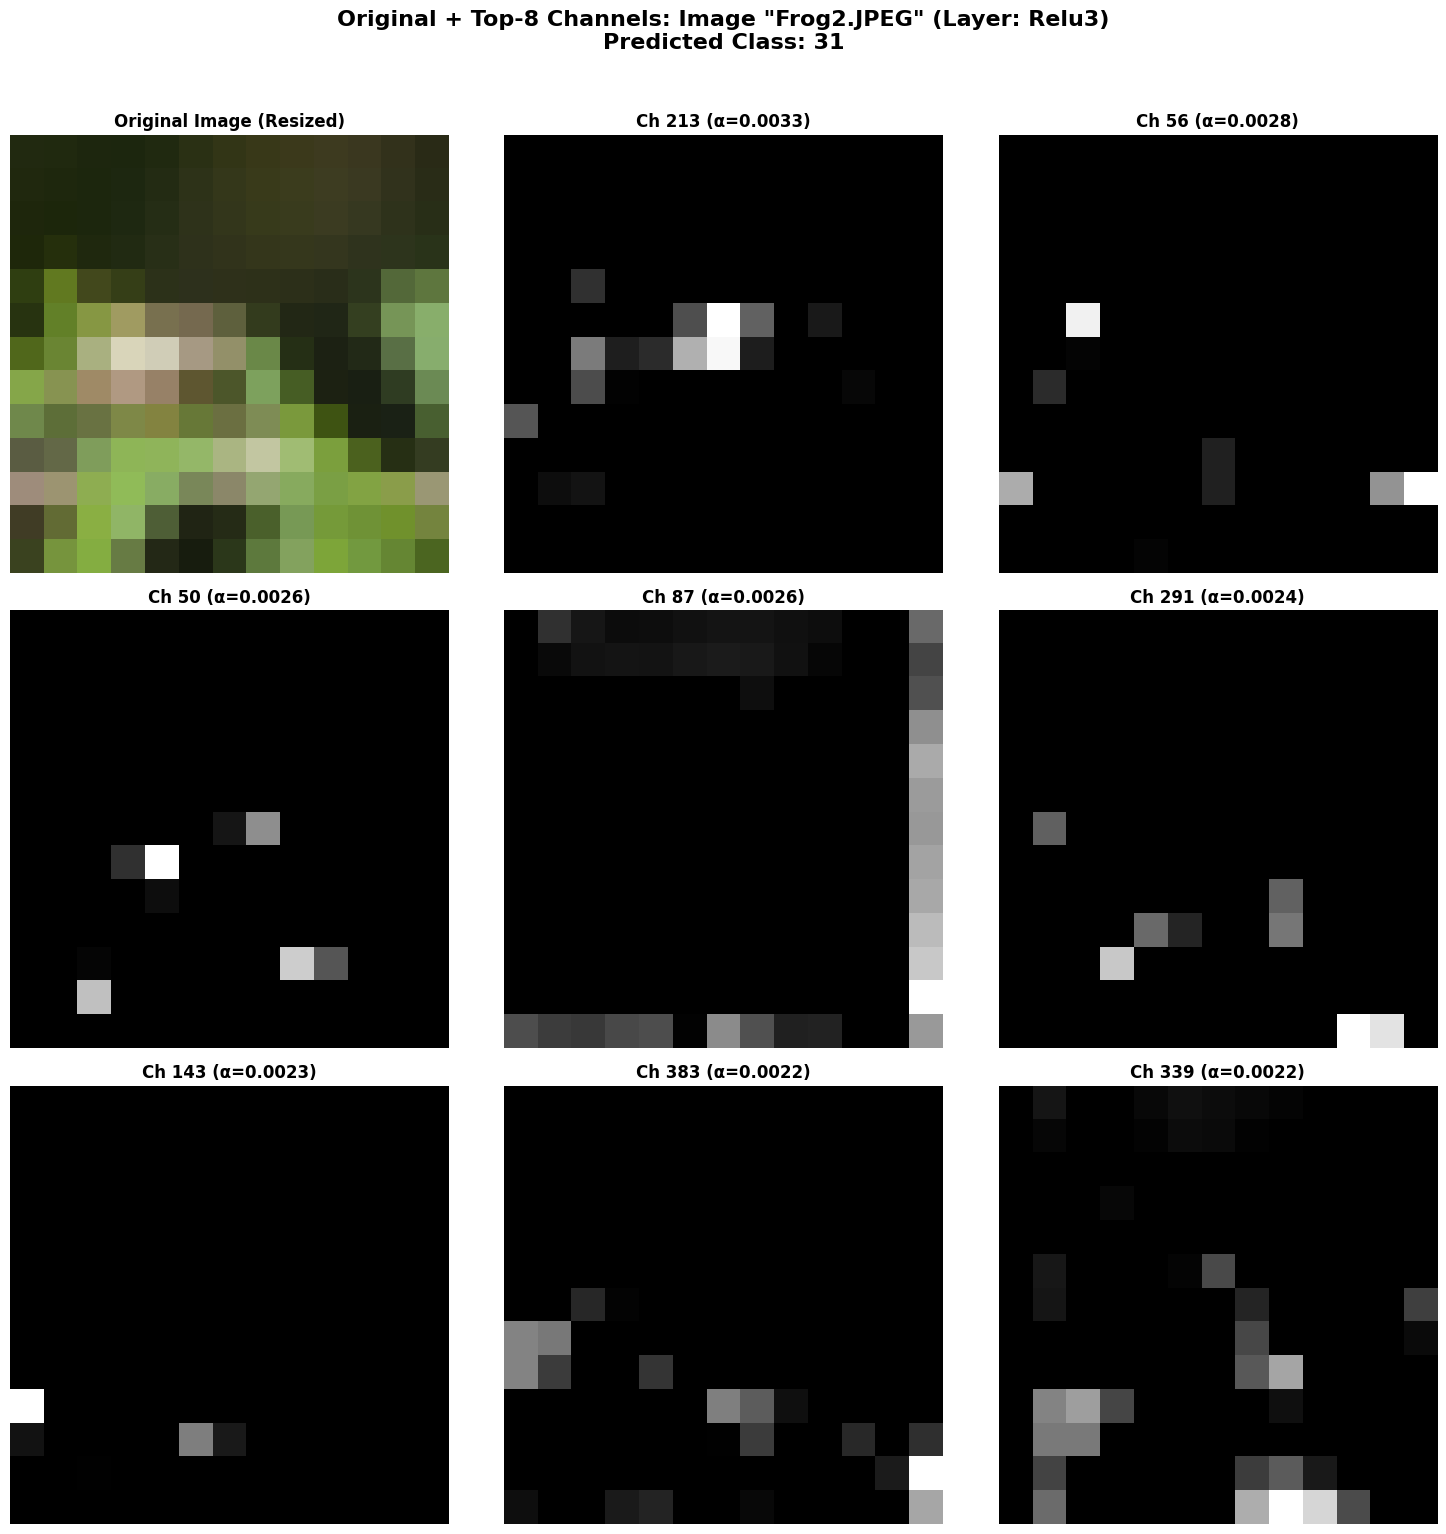

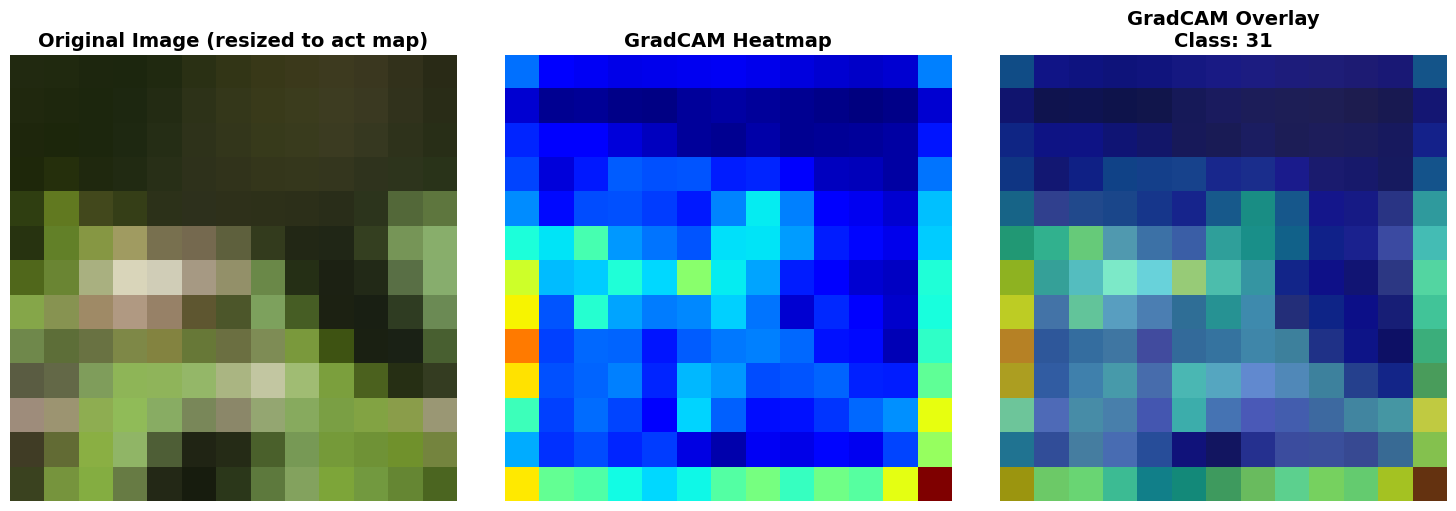

In [24]:
# Relu3 of Img2
analyze_layer(model, img_tensor2, img2, 7, "Relu3", img_path2, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 21.0476

  PHÂN TÍCH LAYER: Relu4 (Index: 9)
Predicted class: 31
Number of channels: 256
Number of non-zero weights: 99
Number of zero weights (after ReLU): 157


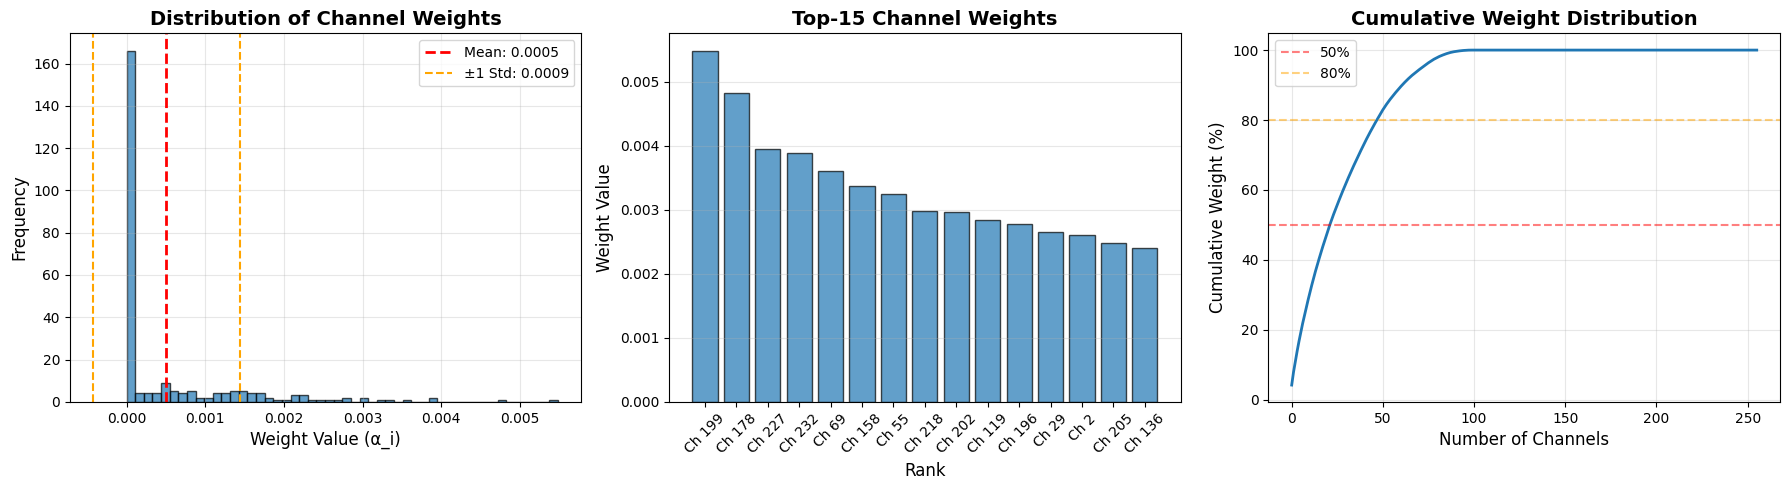


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000507
Std weight: 0.000933
Min weight: 0.000000
Max weight: 0.005484
Weight range: 0.005484

Concentration Analysis:
Top 10% channels (25 channels) contribute: 54.44% of total weight
Top 22 channels contribute 50% of total weight
Top 48 channels contribute 80% of total weight

KL Divergence from uniform: 1.280346
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      199          0.005484        100.00      %
2      178          0.004818        87.86       %
3      227          0.003948        71.99       %
4      232          0.003891        70.95       %
5      69           0.003608        65.79       %
6      158          0.003371        61.47       %
7      55           0.003245        59.17       %
8      218          0.002974        54.23       %
9      202          0.002971     

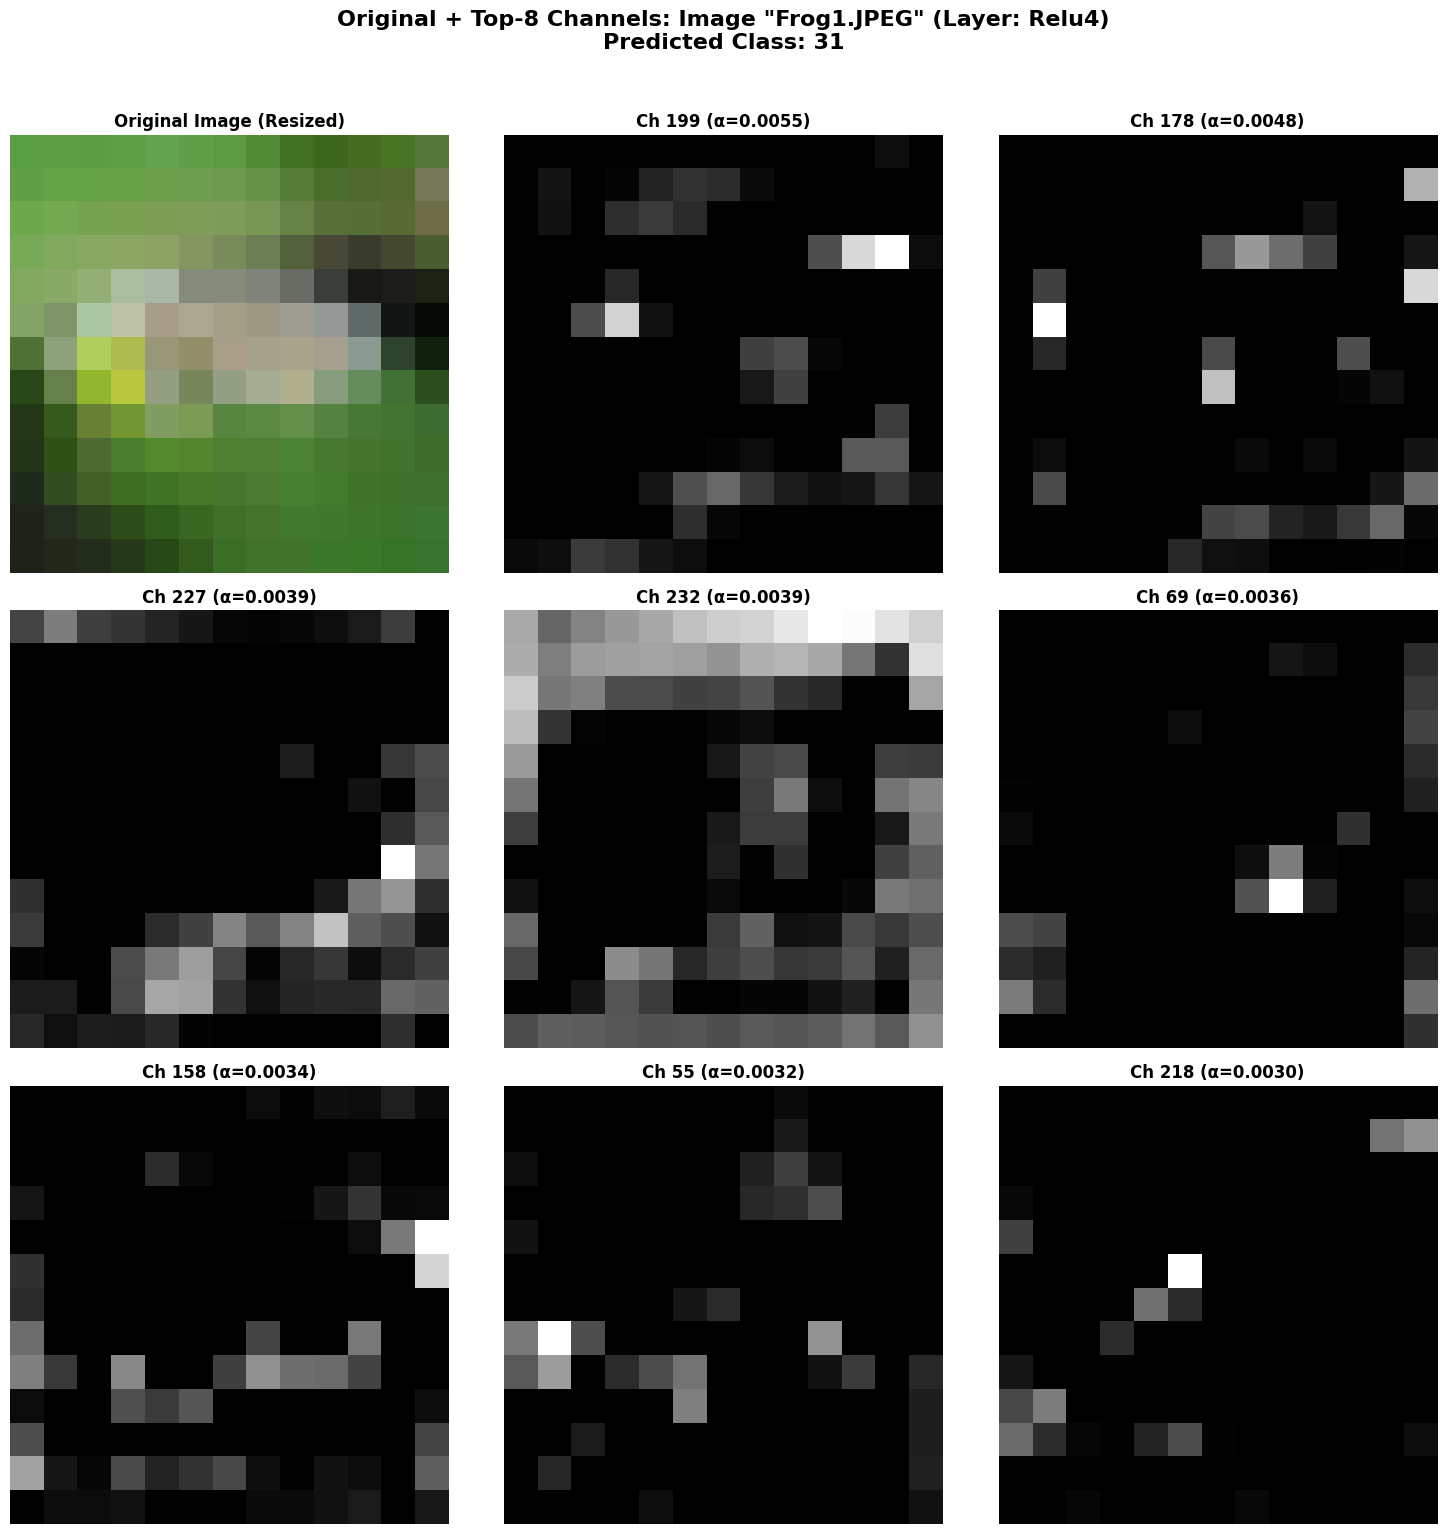

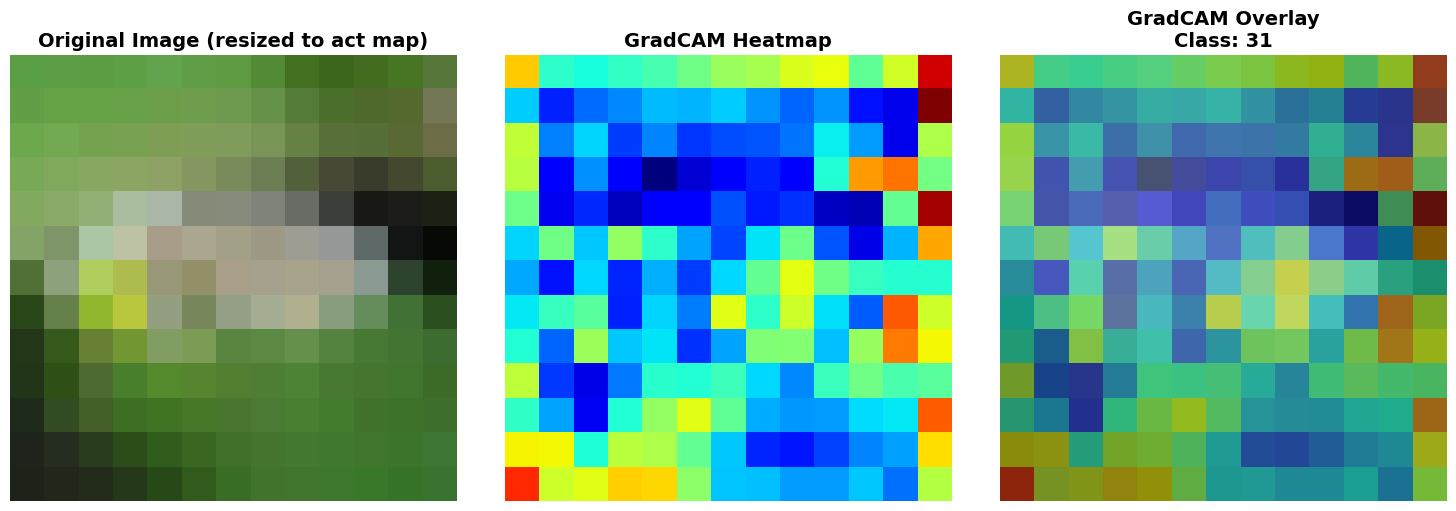

In [25]:
# Relu4 of Img1
analyze_layer(model, img_tensor1, img1, 9, "Relu4", img_path1, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 24.7896

  PHÂN TÍCH LAYER: Relu4 (Index: 9)
Predicted class: 31
Number of channels: 256
Number of non-zero weights: 61
Number of zero weights (after ReLU): 195


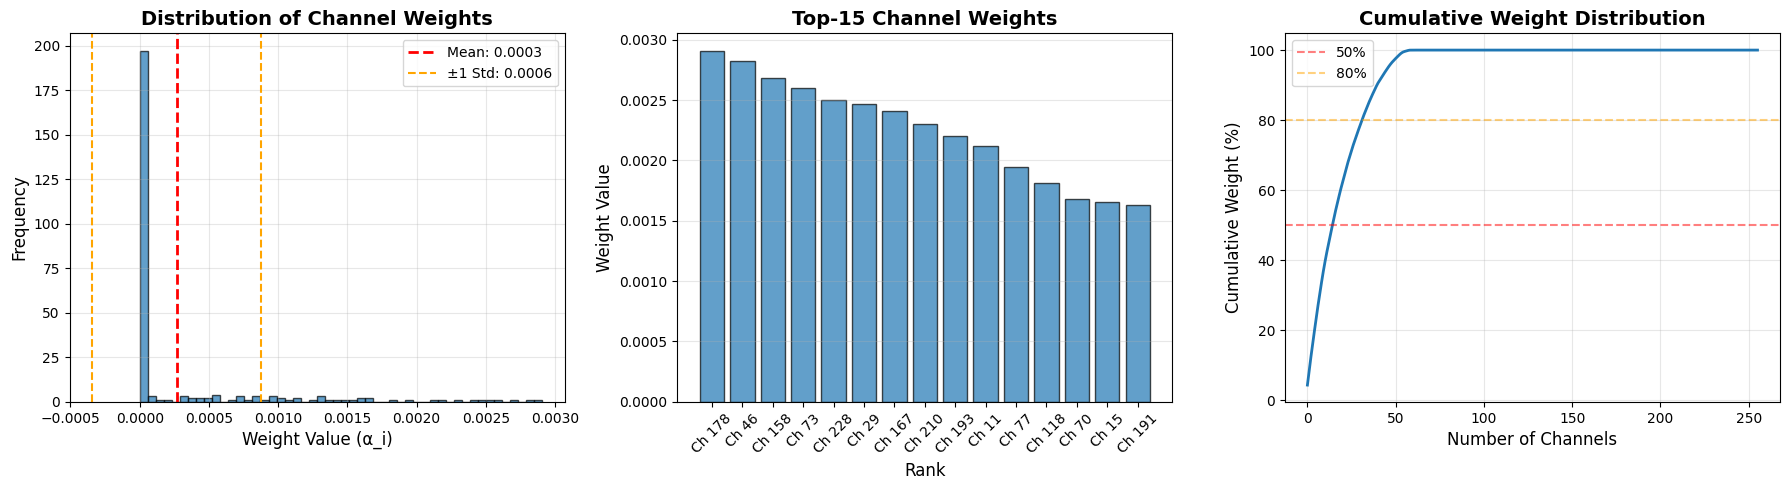


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000266
Std weight: 0.000609
Min weight: 0.000000
Max weight: 0.002908
Weight range: 0.002908

Concentration Analysis:
Top 10% channels (25 channels) contribute: 69.67% of total weight
Top 16 channels contribute 50% of total weight
Top 32 channels contribute 80% of total weight

KL Divergence from uniform: 1.690578
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      178          0.002908        100.00      %
2      46           0.002823        97.10       %
3      158          0.002683        92.28       %
4      73           0.002598        89.34       %
5      228          0.002501        86.01       %
6      29           0.002470        84.94       %
7      167          0.002413        82.98       %
8      210          0.002299        79.07       %
9      193          0.002205     

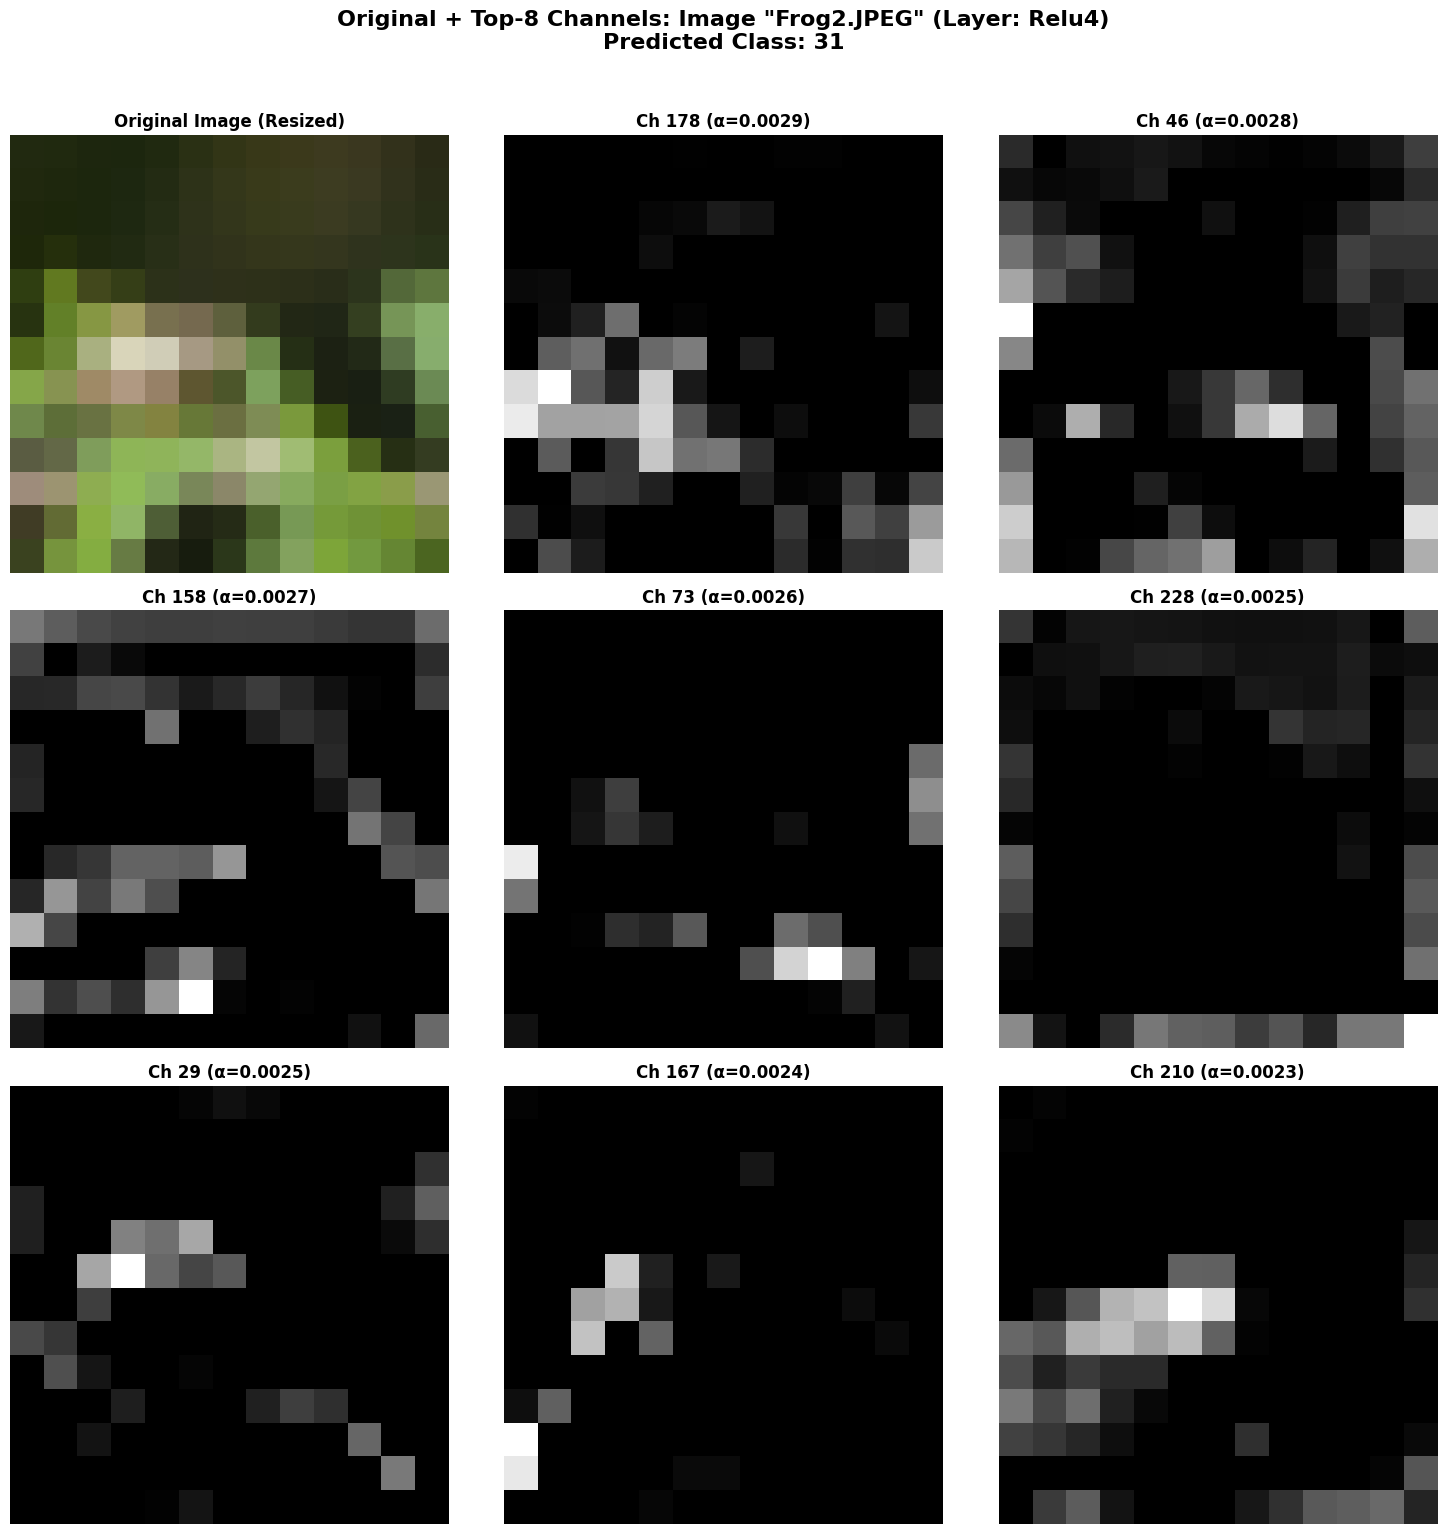

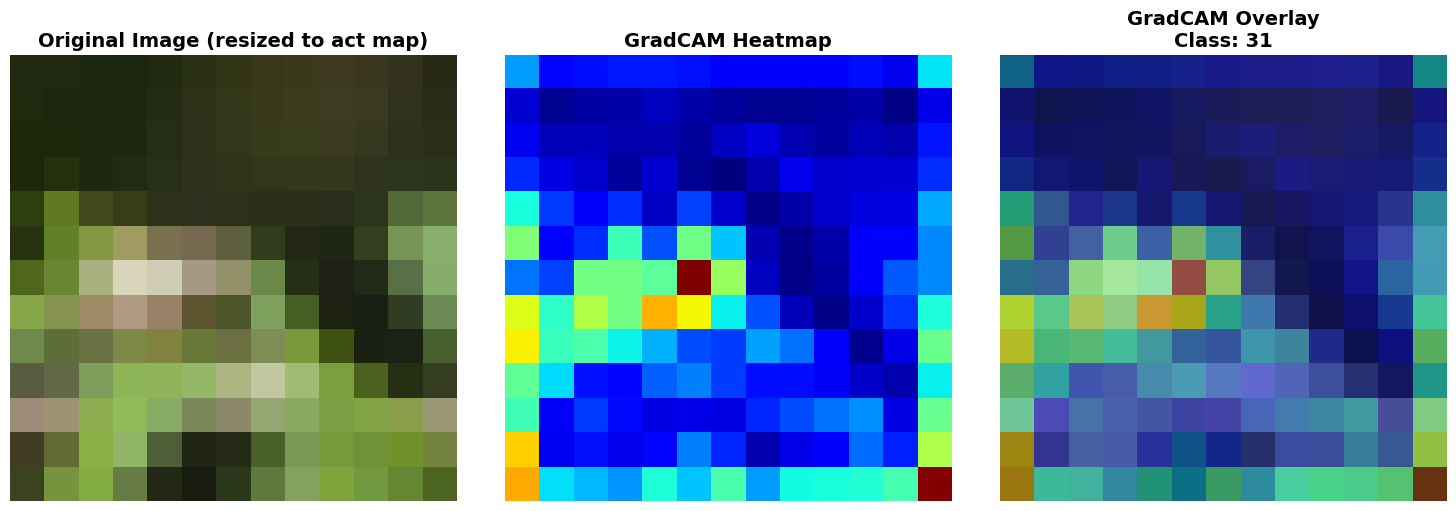

In [26]:
# Relu4 of Img2
analyze_layer(model, img_tensor2, img2, 9, "Relu4", img_path2, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 19.6741

  PHÂN TÍCH LAYER: Relu5 (Index: 11)
Predicted class: 31
Number of channels: 256
Number of non-zero weights: 111
Number of zero weights (after ReLU): 145


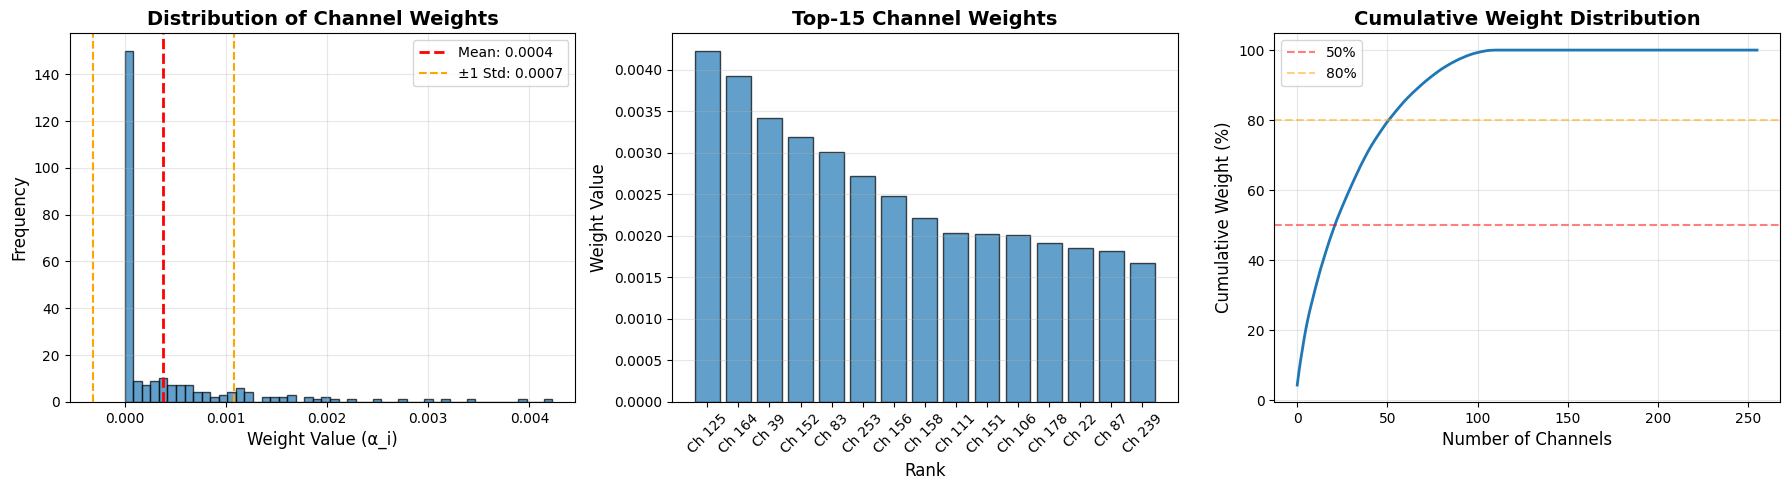


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000383
Std weight: 0.000700
Min weight: 0.000000
Max weight: 0.004228
Weight range: 0.004228

Concentration Analysis:
Top 10% channels (25 channels) contribute: 54.10% of total weight
Top 22 channels contribute 50% of total weight
Top 52 channels contribute 80% of total weight

KL Divergence from uniform: 1.207438
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      125          0.004228        100.00      %
2      164          0.003920        92.72       %
3      39           0.003420        80.90       %
4      152          0.003194        75.53       %
5      83           0.003004        71.06       %
6      253          0.002723        64.40       %
7      156          0.002482        58.70       %
8      158          0.002217        52.43       %
9      111          0.002040     

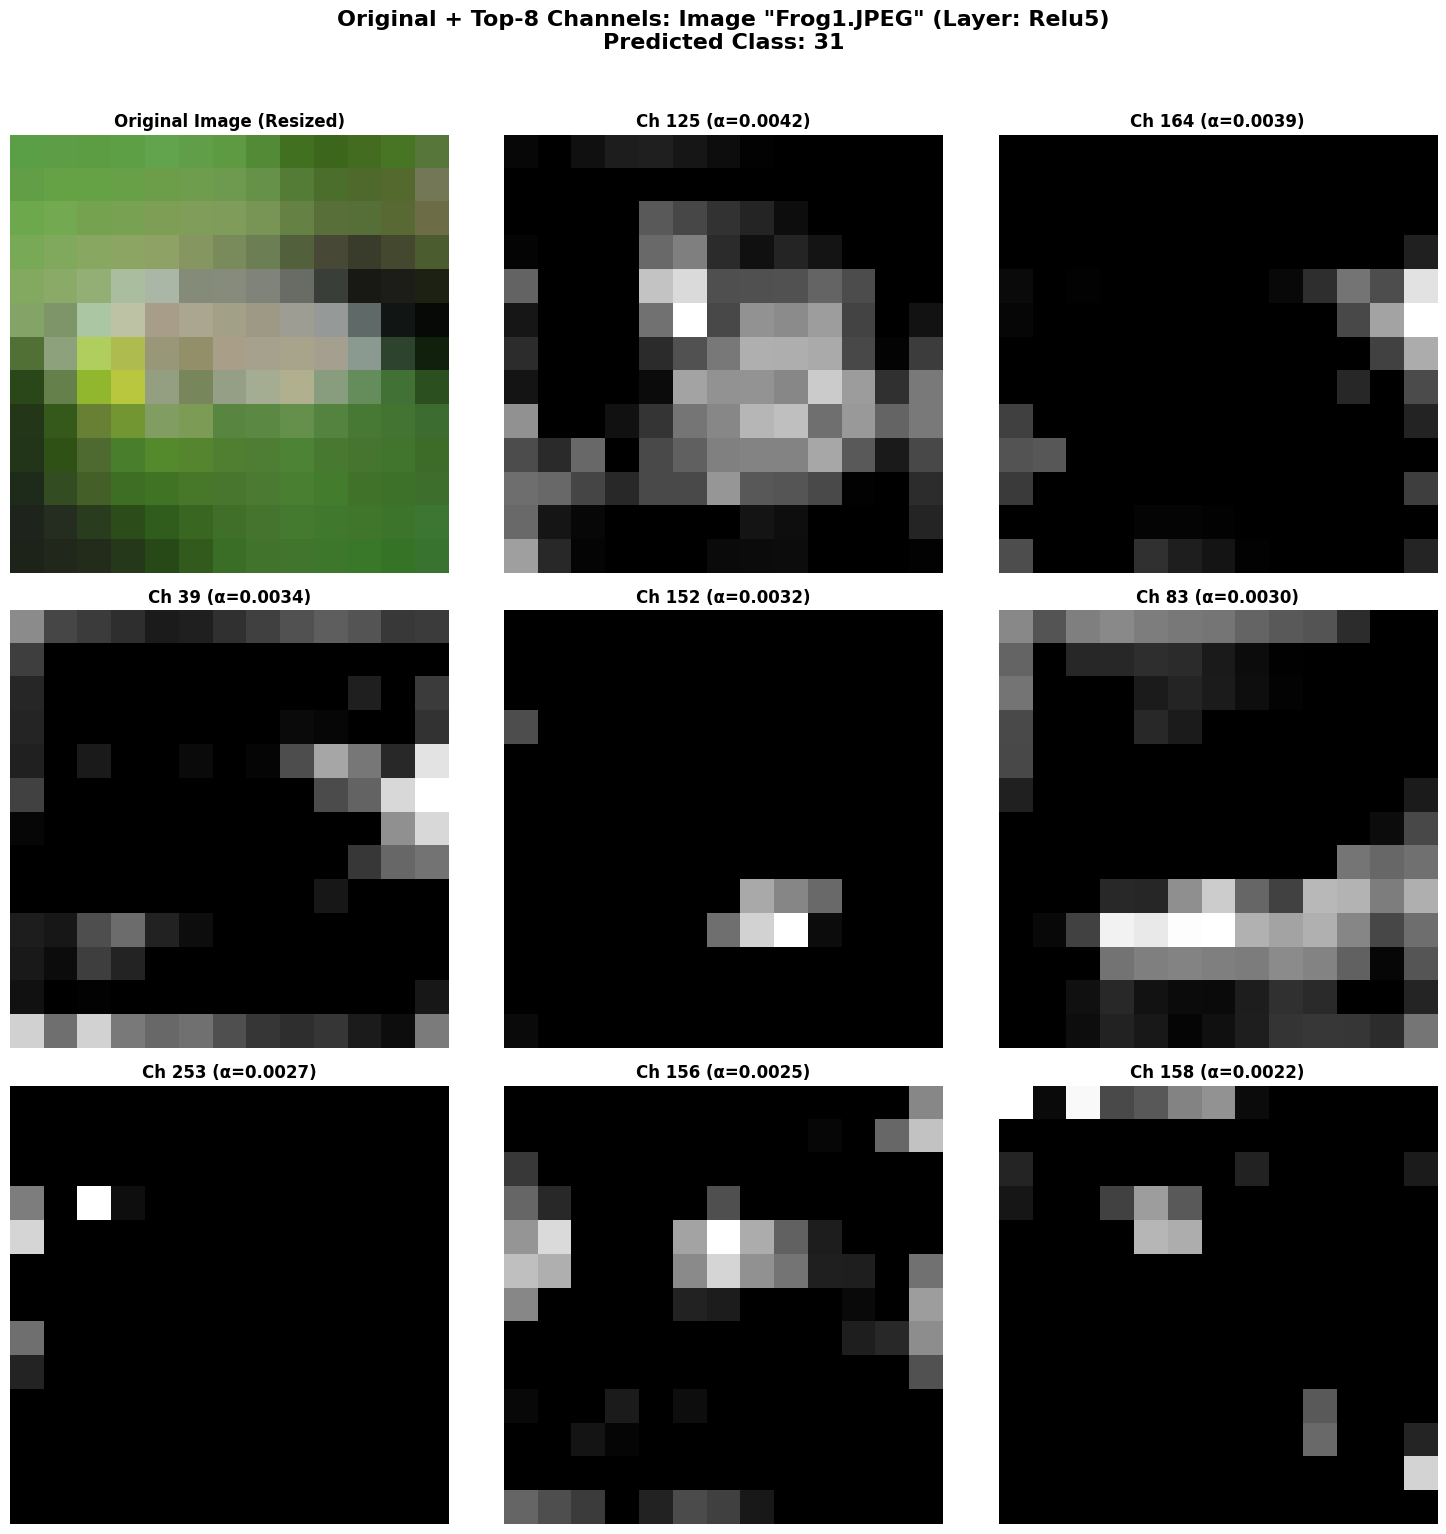

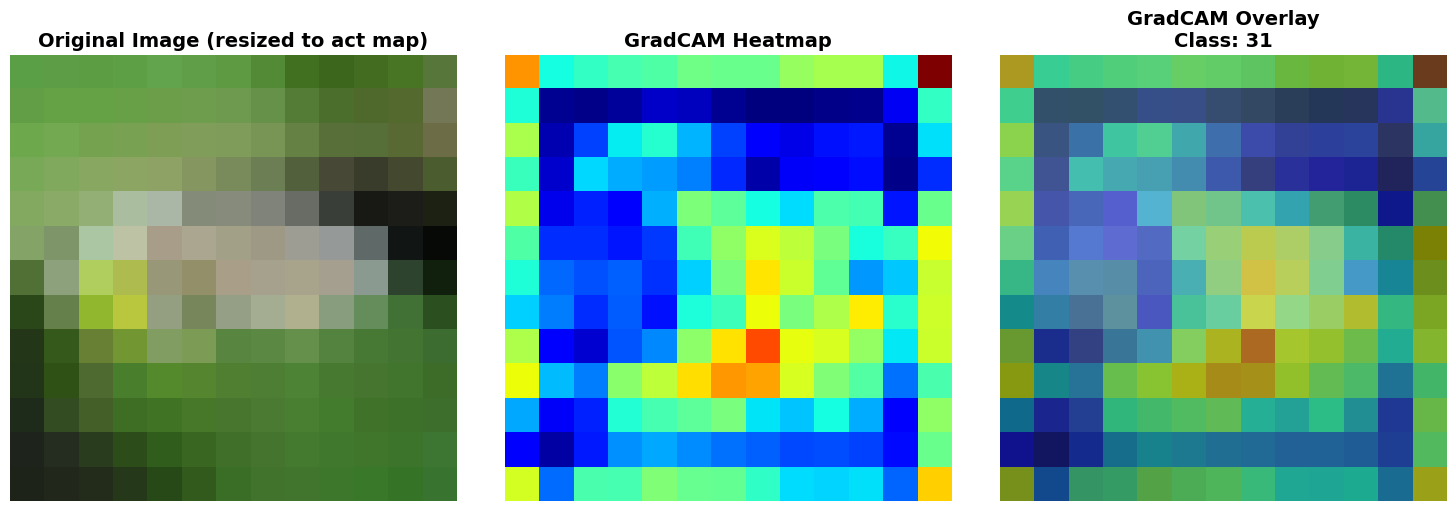

In [28]:
# Relu5 of Img1
analyze_layer(model, img_tensor1, img1, 11, "Relu5", img_path1, class_idx)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 15.8125

  PHÂN TÍCH LAYER: Relu5 (Index: 11)
Predicted class: 31
Number of channels: 256
Number of non-zero weights: 100
Number of zero weights (after ReLU): 156


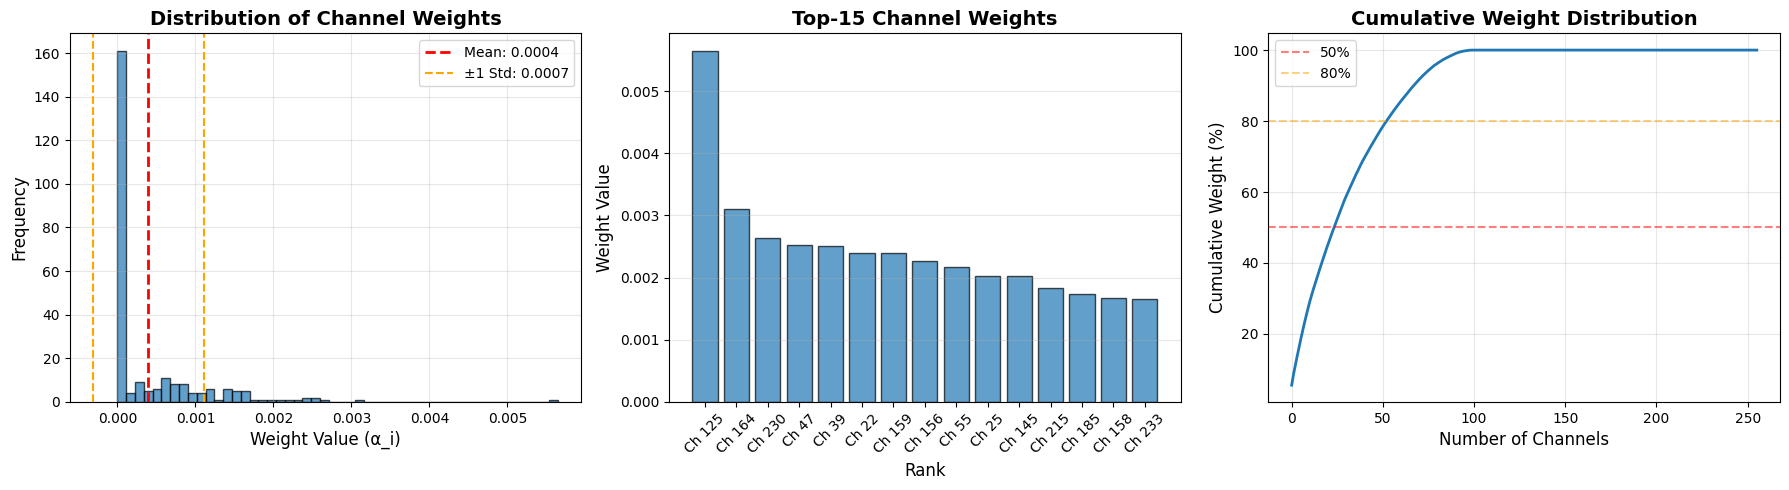


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000396
Std weight: 0.000709
Min weight: 0.000000
Max weight: 0.005648
Weight range: 0.005648

Concentration Analysis:
Top 10% channels (25 channels) contribute: 51.07% of total weight
Top 25 channels contribute 50% of total weight
Top 53 channels contribute 80% of total weight

KL Divergence from uniform: 1.213649
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      125          0.005648        100.00      %
2      164          0.003109        55.05       %
3      230          0.002634        46.63       %
4      47           0.002525        44.71       %
5      39           0.002512        44.48       %
6      22           0.002403        42.55       %
7      159          0.002397        42.44       %
8      156          0.002263        40.07       %
9      55           0.002168     

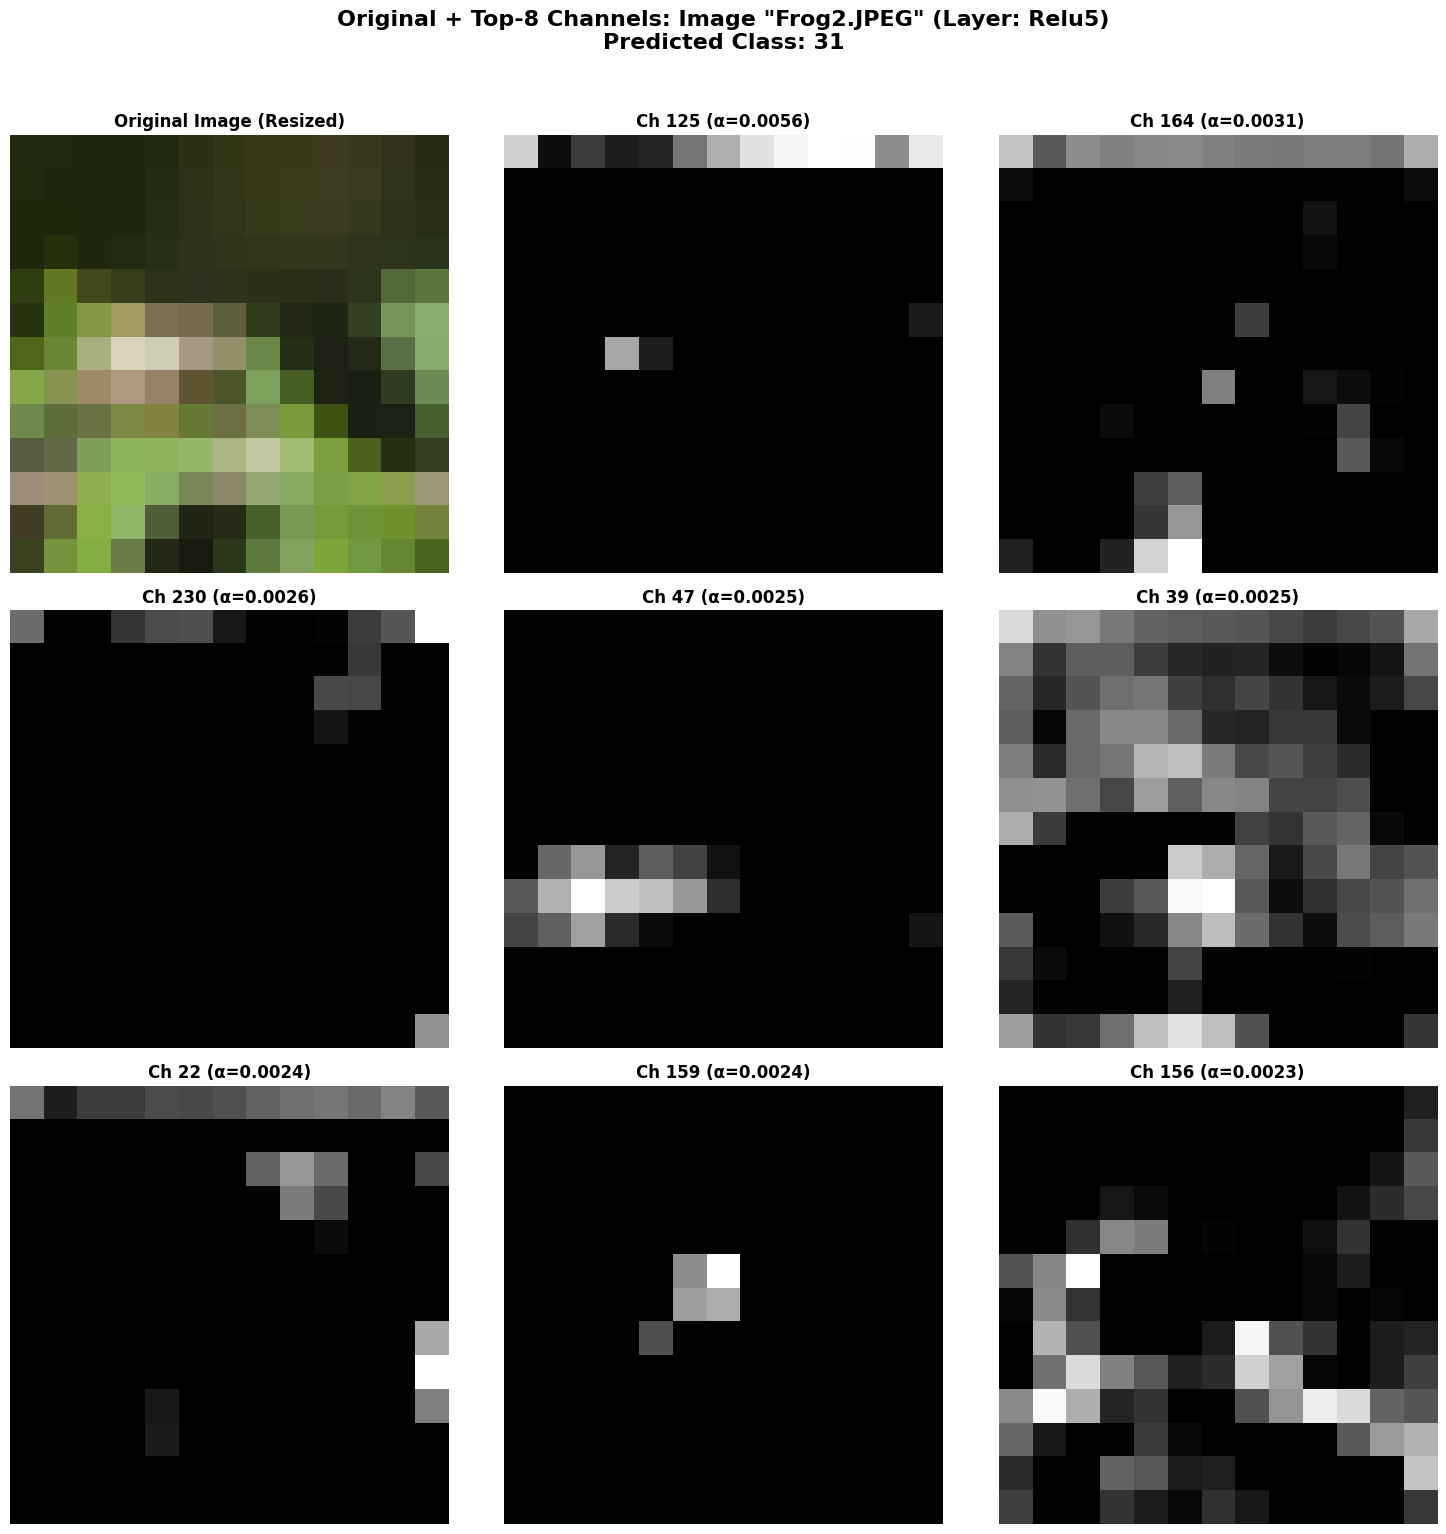

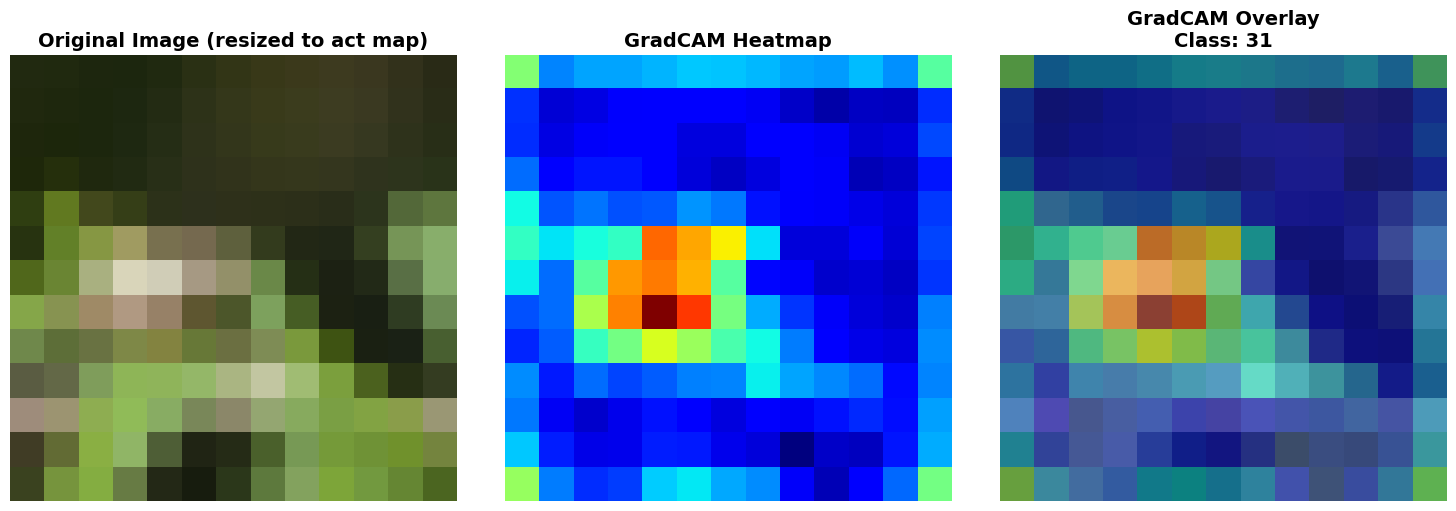

In [29]:
# Relu5 of Img2
analyze_layer(model, img_tensor2, img2, 11, "Relu5", img_path2, class_idx)

In [30]:
compare_top_channels_across_images(
    model, img_tensor1, img_tensor2, 
    layer_index=1, 
    img1_name=img_path1, 
    img2_name=img_path2, 
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 1 GIỮA "Frog1.JPEG" VÀ "Frog2.JPEG"
Activations - min: 0.0000, max: 22.2821
Activations - min: 0.0000, max: 20.2006
Predicted class for Frog1.JPEG: 31
Predicted class for Frog2.JPEG: 31

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 6            | 0.000385        | 60     | 0.000000        | 0.00           % |
| 2      | 37           | 0.000343        | 10     | 0.000098        | 2.62           % |
| 3      | 32           | 0.000299        | 15     | 0.000072        | 1.94           % |
| 4      | 12           | 0.000277        | 23     | 0.000002        | 0.05           % |
| 5      | 34           | 0.000266        | 11     | 0.000094        | 2.51           % |
| 6      | 24           | 0.000245        | 9      | 0.000102        | 2.74           % |
| 7      | 10           | 0.000230        | 55     | 0.000000        | 0.00           % |
| 8      | 11           | 0.000217        | 57     | 0.00

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [31]:
compare_top_channels_across_images(
    model, img_tensor1, img_tensor2, 
    layer_index=4, 
    img1_name=img_path1, 
    img2_name=img_path2, 
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 4 GIỮA "Frog1.JPEG" VÀ "Frog2.JPEG"
Activations - min: 0.0000, max: 37.0083
Activations - min: 0.0000, max: 37.8473
Predicted class for Frog1.JPEG: 31
Predicted class for Frog2.JPEG: 31

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 153          | 0.000602        | 19     | 0.000148        | 1.74           % |
| 2      | 191          | 0.000593        | 97     | 0.000000        | 0.00           % |
| 3      | 94           | 0.000568        | 31     | 0.000110        | 1.30           % |
| 4      | 60           | 0.000490        | 160    | 0.000000        | 0.00           % |
| 5      | 27           | 0.000448        | 71     | 0.000023        | 0.28           % |
| 6      | 59           | 0.000412        | 4      | 0.000304        | 3.58           % |
| 7      | 183          | 0.000388        | 117    | 0.000000        | 0.00           % |
| 8      | 176          | 0.000353        | 18     | 0.00

In [32]:
compare_top_channels_across_images(
    model, img_tensor1, img_tensor2, 
    layer_index=7, 
    img1_name=img_path1, 
    img2_name=img_path2, 
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 7 GIỮA "Frog1.JPEG" VÀ "Frog2.JPEG"
Activations - min: 0.0000, max: 30.9220
Activations - min: 0.0000, max: 28.6765
Predicted class for Frog1.JPEG: 31
Predicted class for Frog2.JPEG: 31

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 27           | 0.005776        | 71     | 0.000833        | 0.60           % |
| 2      | 173          | 0.004994        | 160    | 0.000112        | 0.08           % |
| 3      | 283          | 0.004401        | 62     | 0.000915        | 0.66           % |
| 4      | 277          | 0.004243        | 76     | 0.000795        | 0.57           % |
| 5      | 22           | 0.004029        | 59     | 0.000946        | 0.68           % |
| 6      | 231          | 0.003563        | 89     | 0.000688        | 0.49           % |
| 7      | 100          | 0.003252        | 72     | 0.000833        | 0.60           % |
| 8      | 198          | 0.002936        | 29     | 0.00

In [33]:
compare_top_channels_across_images(
    model, img_tensor1, img_tensor2, 
    layer_index=9, 
    img1_name=img_path1, 
    img2_name=img_path2, 
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 9 GIỮA "Frog1.JPEG" VÀ "Frog2.JPEG"
Activations - min: 0.0000, max: 21.0476
Activations - min: 0.0000, max: 24.7896
Predicted class for Frog1.JPEG: 31
Predicted class for Frog2.JPEG: 31

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 199          | 0.005484        | 36     | 0.000845        | 1.24           % |
| 2      | 178          | 0.004818        | 1      | 0.002908        | 4.27           % |
| 3      | 227          | 0.003948        | 100    | 0.000000        | 0.00           % |
| 4      | 232          | 0.003891        | 48     | 0.000460        | 0.68           % |
| 5      | 69           | 0.003608        | 45     | 0.000527        | 0.77           % |
| 6      | 158          | 0.003371        | 3      | 0.002683        | 3.94           % |
| 7      | 55           | 0.003245        | 28     | 0.001015        | 1.49           % |
| 8      | 218          | 0.002974        | 51     | 0.00

In [34]:
compare_top_channels_across_images(
    model, img_tensor1, img_tensor2, 
    layer_index=11, 
    img1_name=img_path1, 
    img2_name=img_path2, 
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 11 GIỮA "Frog1.JPEG" VÀ "Frog2.JPEG"
Activations - min: 0.0000, max: 19.6741
Activations - min: 0.0000, max: 15.8125
Predicted class for Frog1.JPEG: 31
Predicted class for Frog2.JPEG: 31

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 125          | 0.004228        | 1      | 0.005648        | 5.57           % |
| 2      | 164          | 0.003920        | 2      | 0.003109        | 3.06           % |
| 3      | 39           | 0.003420        | 5      | 0.002512        | 2.48           % |
| 4      | 152          | 0.003194        | 45     | 0.000901        | 0.89           % |
| 5      | 83           | 0.003004        | 16     | 0.001644        | 1.62           % |
| 6      | 253          | 0.002723        | 52     | 0.000796        | 0.78           % |
| 7      | 156          | 0.002482        | 8      | 0.002263        | 2.23           % |
| 8      | 158          | 0.002217        | 14     | 0.0

In [35]:
img_path_bird = 'bird1.png'
img_path_move = 'bird_move.png'
img_bird = Image.open(img_path_bird).convert('RGB')
img_bird_move = Image.open(img_path_move).convert('RGB')
img_bird_tensor = transform(img_bird).unsqueeze(0)
img_bird_move_tensor = transform(img_bird_move).unsqueeze(0)

In [36]:
# Check class idx of img_bird and img bird move
with torch.no_grad():
    logits_bird = model(img_bird_tensor)
    logits_bird_move = model(img_bird_move_tensor)
    class_idx_bird = logits_bird.argmax(dim=1).item()
    class_idx_bird_move = logits_bird_move.argmax(dim=1).item()
    print(f"Class idx of bird1.png: {class_idx_bird}")
    print(f"Class idx of bird_move.png: {class_idx_bird_move}")

Class idx of bird1.png: 17
Class idx of bird_move.png: 17


/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 23.3526

  PHÂN TÍCH LAYER: Relu1 (Index: 1)
Predicted class: 17
Number of channels: 64
Number of non-zero weights: 32
Number of zero weights (after ReLU): 32


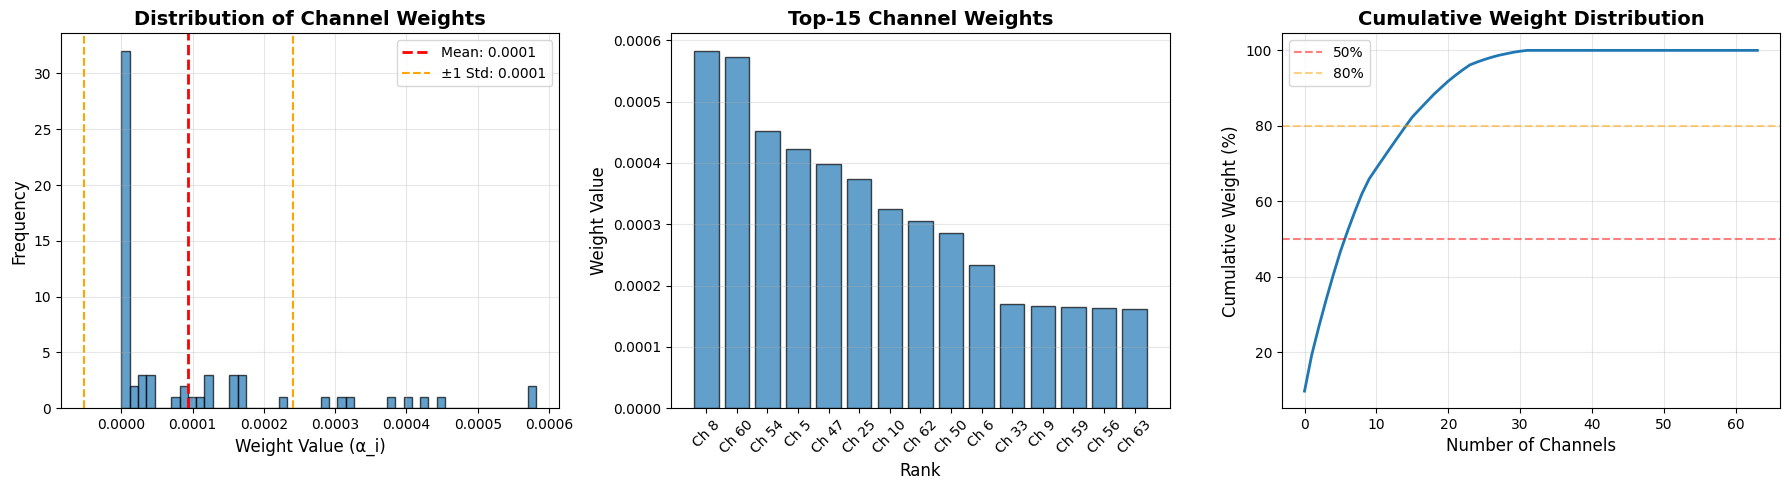


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 64
Mean weight: 0.000094
Std weight: 0.000147
Min weight: 0.000000
Max weight: 0.000582
Weight range: 0.000582

Concentration Analysis:
Top 10% channels (6 channels) contribute: 46.77% of total weight
Top 7 channels contribute 50% of total weight
Top 16 channels contribute 80% of total weight

KL Divergence from uniform: 1.039414
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      8            0.000582        100.00      %
2      60           0.000574        98.50       %
3      54           0.000452        77.58       %
4      5            0.000423        72.62       %
5      47           0.000398        68.27       %
6      25           0.000374        64.19       %
7      10           0.000325        55.73       %
8      62           0.000306        52.55       %
9      50           0.000287        

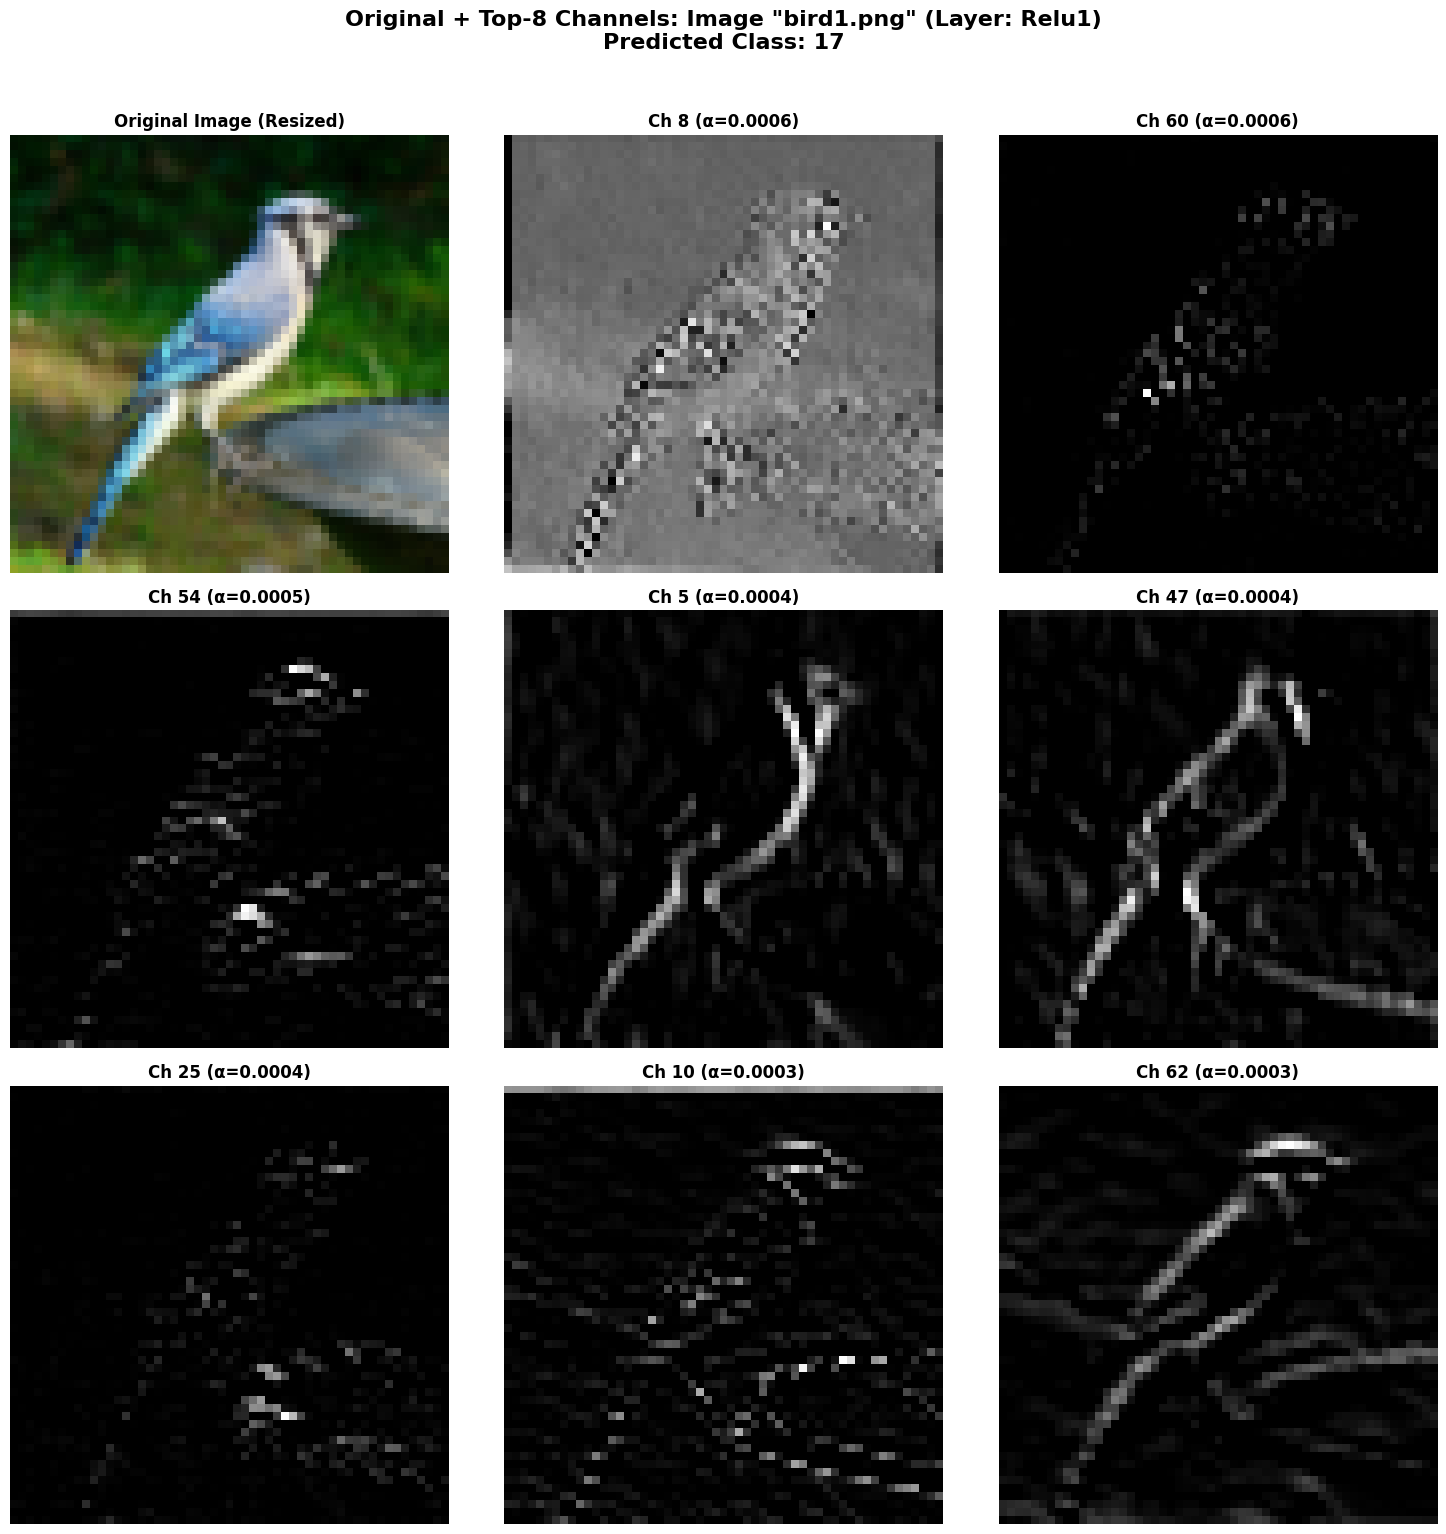

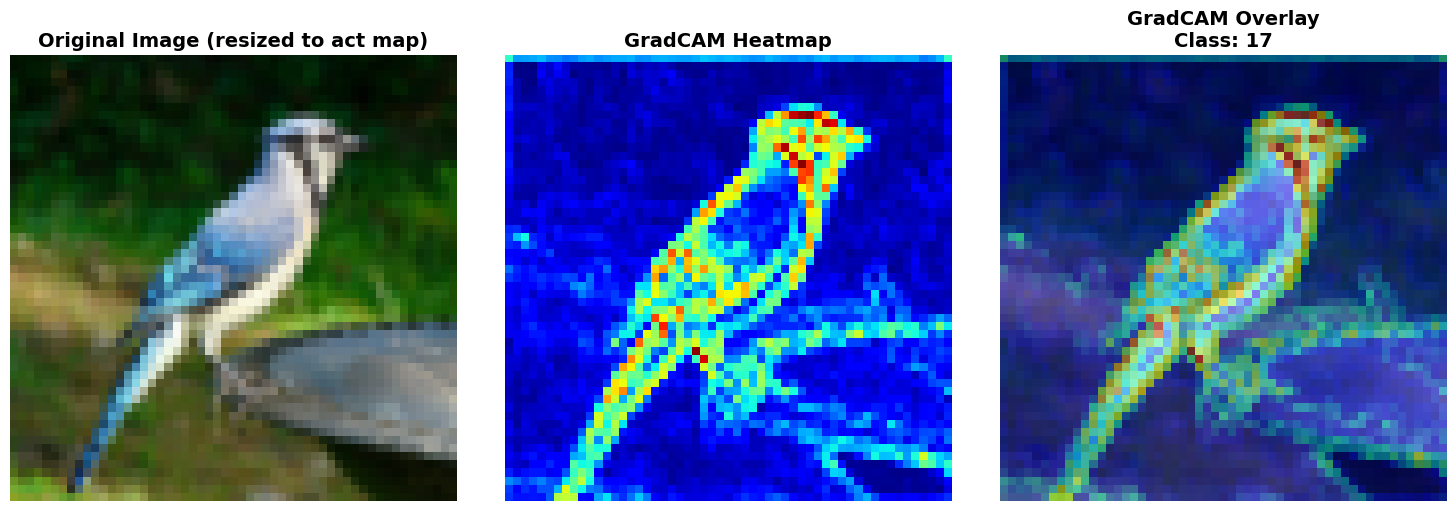

In [37]:
# Relu 1 of bird
analyze_layer(model, img_bird_tensor, img_bird, 1, "Relu1", img_path_bird, class_idx_bird)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 30.4618

  PHÂN TÍCH LAYER: Relu1 (Index: 1)
Predicted class: 17
Number of channels: 64
Number of non-zero weights: 23
Number of zero weights (after ReLU): 41


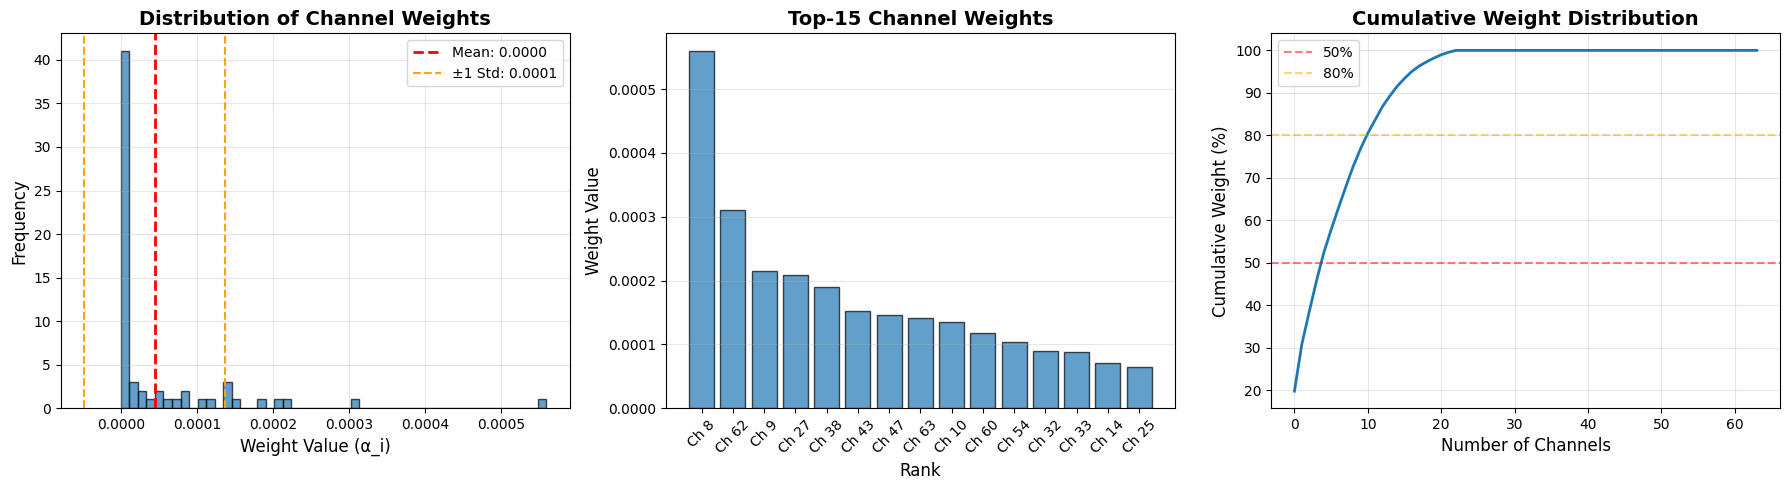


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 64
Mean weight: 0.000044
Std weight: 0.000093
Min weight: 0.000000
Max weight: 0.000559
Weight range: 0.000559

Concentration Analysis:
Top 10% channels (6 channels) contribute: 57.78% of total weight
Top 5 channels contribute 50% of total weight
Top 11 channels contribute 80% of total weight

KL Divergence from uniform: 1.397045
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      8            0.000559        100.00      %
2      62           0.000311        55.60       %
3      9            0.000216        38.53       %
4      27           0.000208        37.24       %
5      38           0.000189        33.81       %
6      43           0.000153        27.33       %
7      47           0.000145        25.96       %
8      63           0.000141        25.20       %
9      10           0.000136        

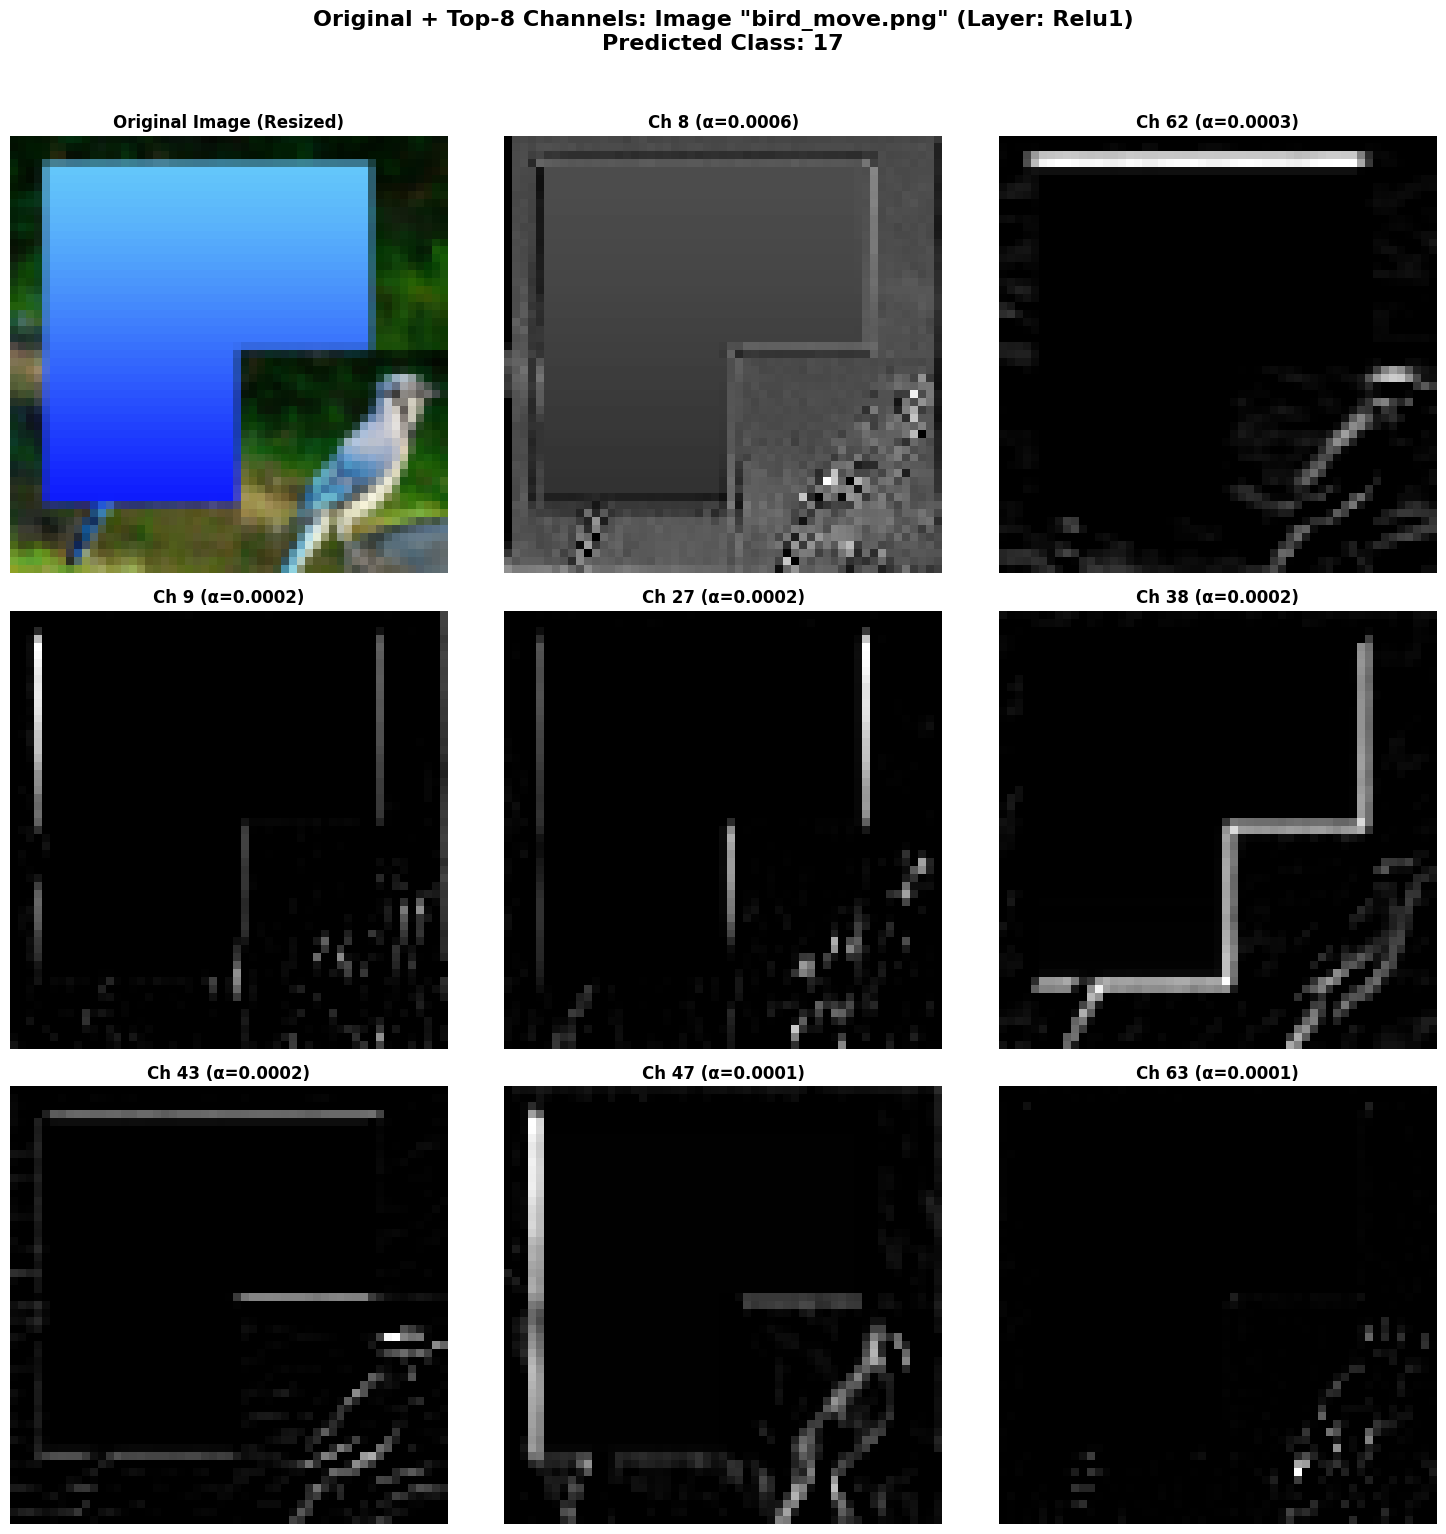

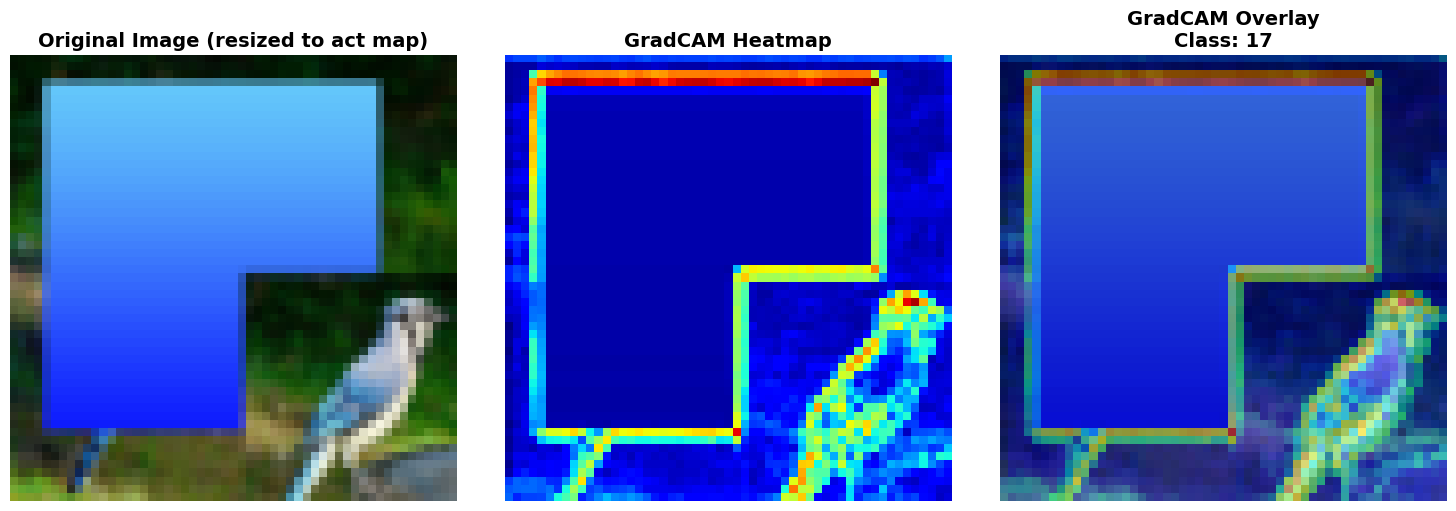

In [38]:
# Relu1 of bird move
analyze_layer(model, img_bird_move_tensor, img_bird_move, 1, "Relu1", img_path_move, class_idx_bird_move)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 53.4932

  PHÂN TÍCH LAYER: Relu2 (Index: 4)
Predicted class: 17
Number of channels: 192
Number of non-zero weights: 88
Number of zero weights (after ReLU): 104


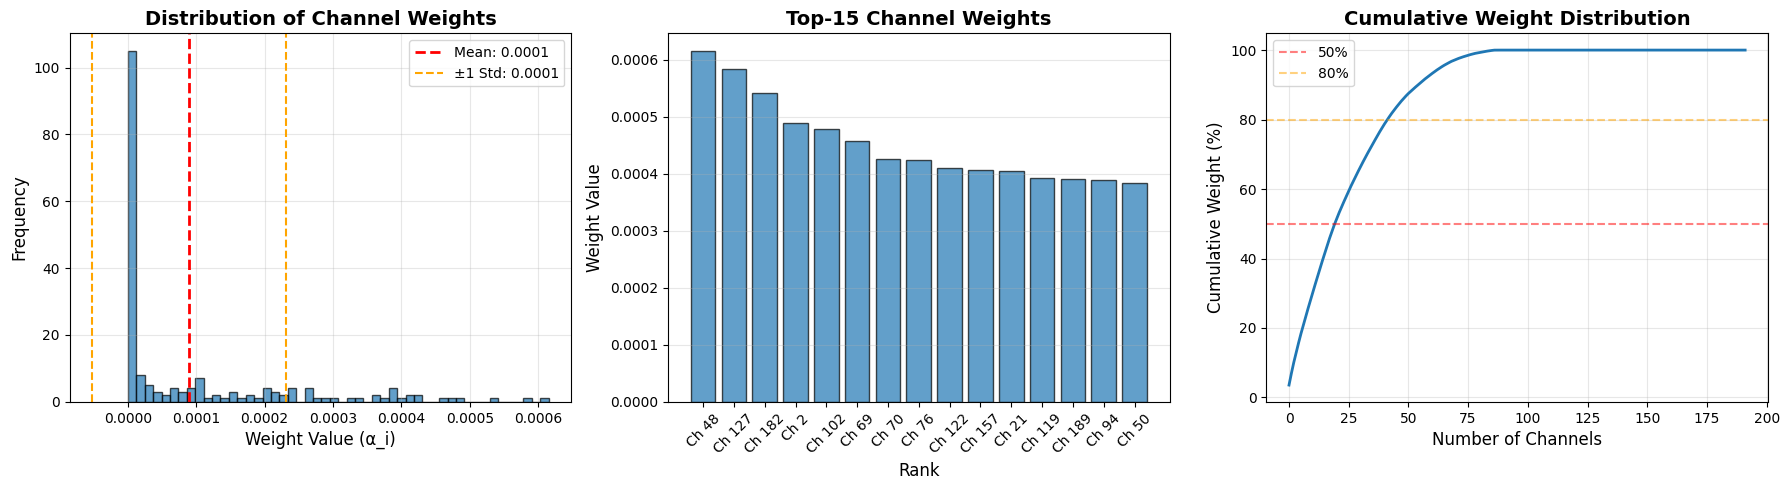


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 192
Mean weight: 0.000090
Std weight: 0.000142
Min weight: 0.000000
Max weight: 0.000615
Weight range: 0.000615

Concentration Analysis:
Top 10% channels (19 channels) contribute: 47.84% of total weight
Top 21 channels contribute 50% of total weight
Top 43 channels contribute 80% of total weight

KL Divergence from uniform: 1.083954
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      48           0.000615        100.00      %
2      127          0.000583        94.77       %
3      182          0.000541        87.92       %
4      2            0.000489        79.41       %
5      102          0.000479        77.87       %
6      69           0.000457        74.30       %
7      70           0.000426        69.24       %
8      76           0.000425        69.02       %
9      122          0.000411     

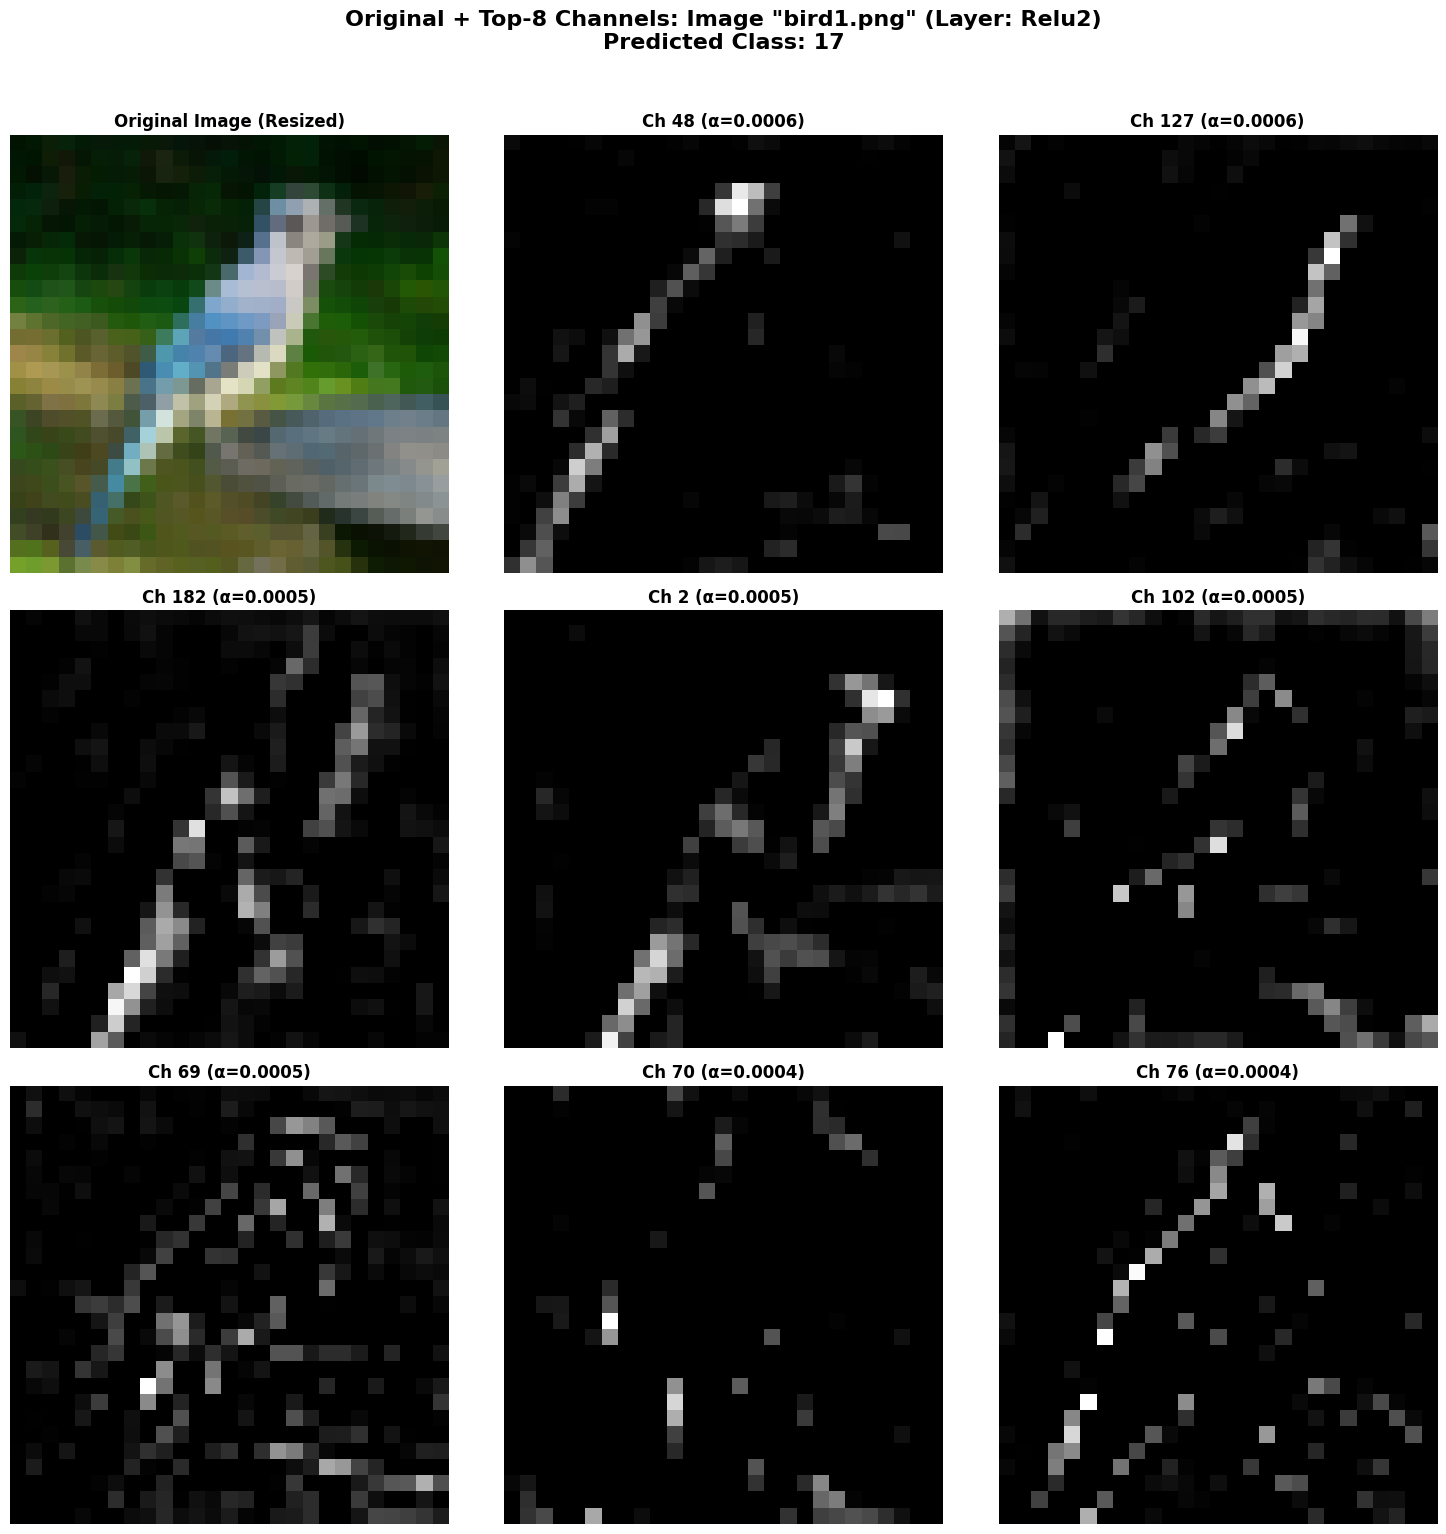

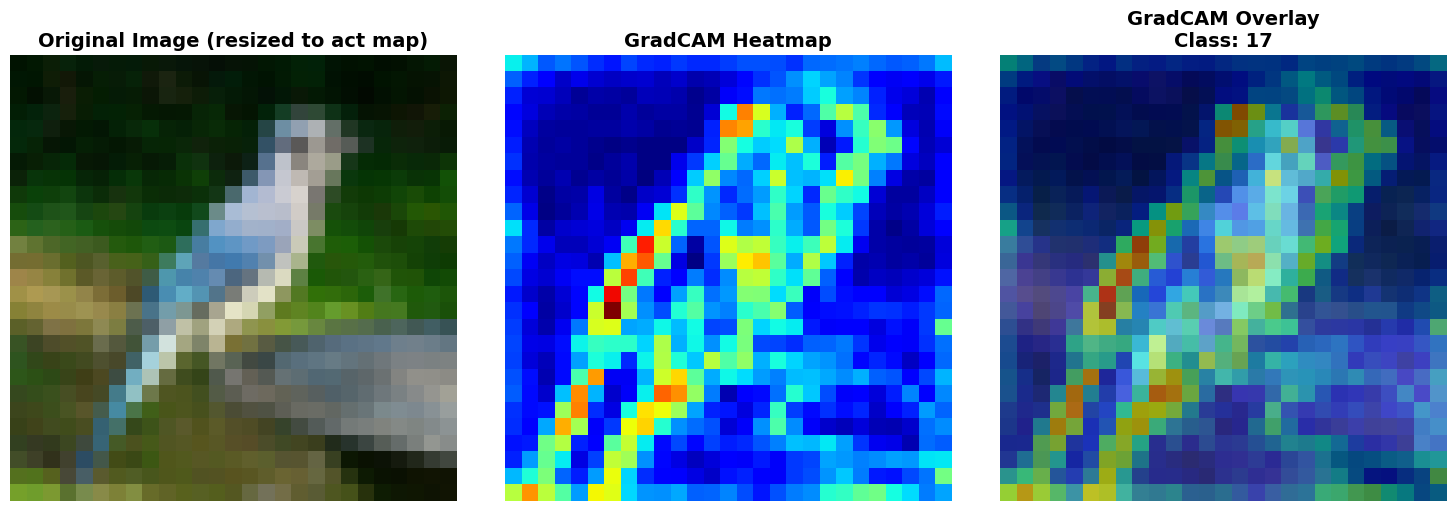

In [39]:
# Relu 2 of bird
analyze_layer(model, img_bird_tensor, img_bird, 4, "Relu2", img_path_bird, class_idx_bird)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 71.5203

  PHÂN TÍCH LAYER: Relu2 (Index: 4)
Predicted class: 17
Number of channels: 192
Number of non-zero weights: 101
Number of zero weights (after ReLU): 91


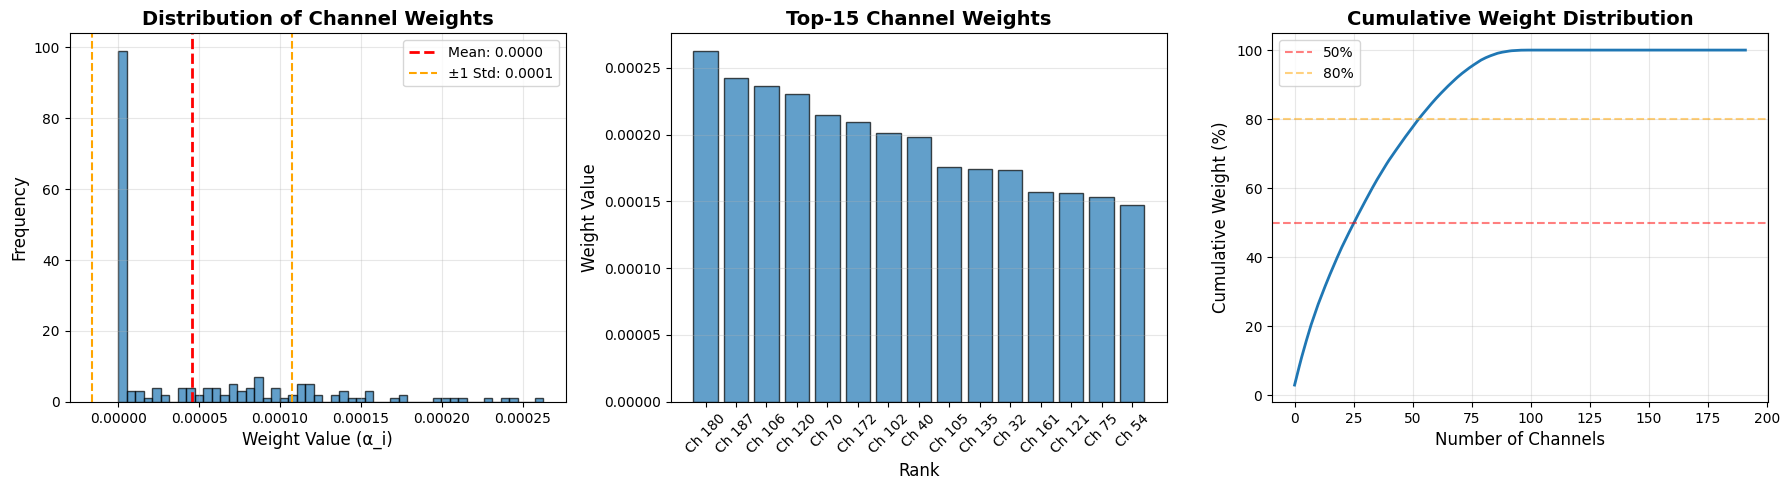


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 192
Mean weight: 0.000046
Std weight: 0.000062
Min weight: 0.000000
Max weight: 0.000263
Weight range: 0.000263

Concentration Analysis:
Top 10% channels (19 channels) contribute: 39.85% of total weight
Top 27 channels contribute 50% of total weight
Top 54 channels contribute 80% of total weight

KL Divergence from uniform: 0.904450
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      180          0.000263        100.00      %
2      187          0.000242        92.16       %
3      106          0.000237        90.09       %
4      120          0.000230        87.65       %
5      70           0.000214        81.60       %
6      172          0.000209        79.63       %
7      102          0.000201        76.71       %
8      40           0.000198        75.38       %
9      105          0.000176 

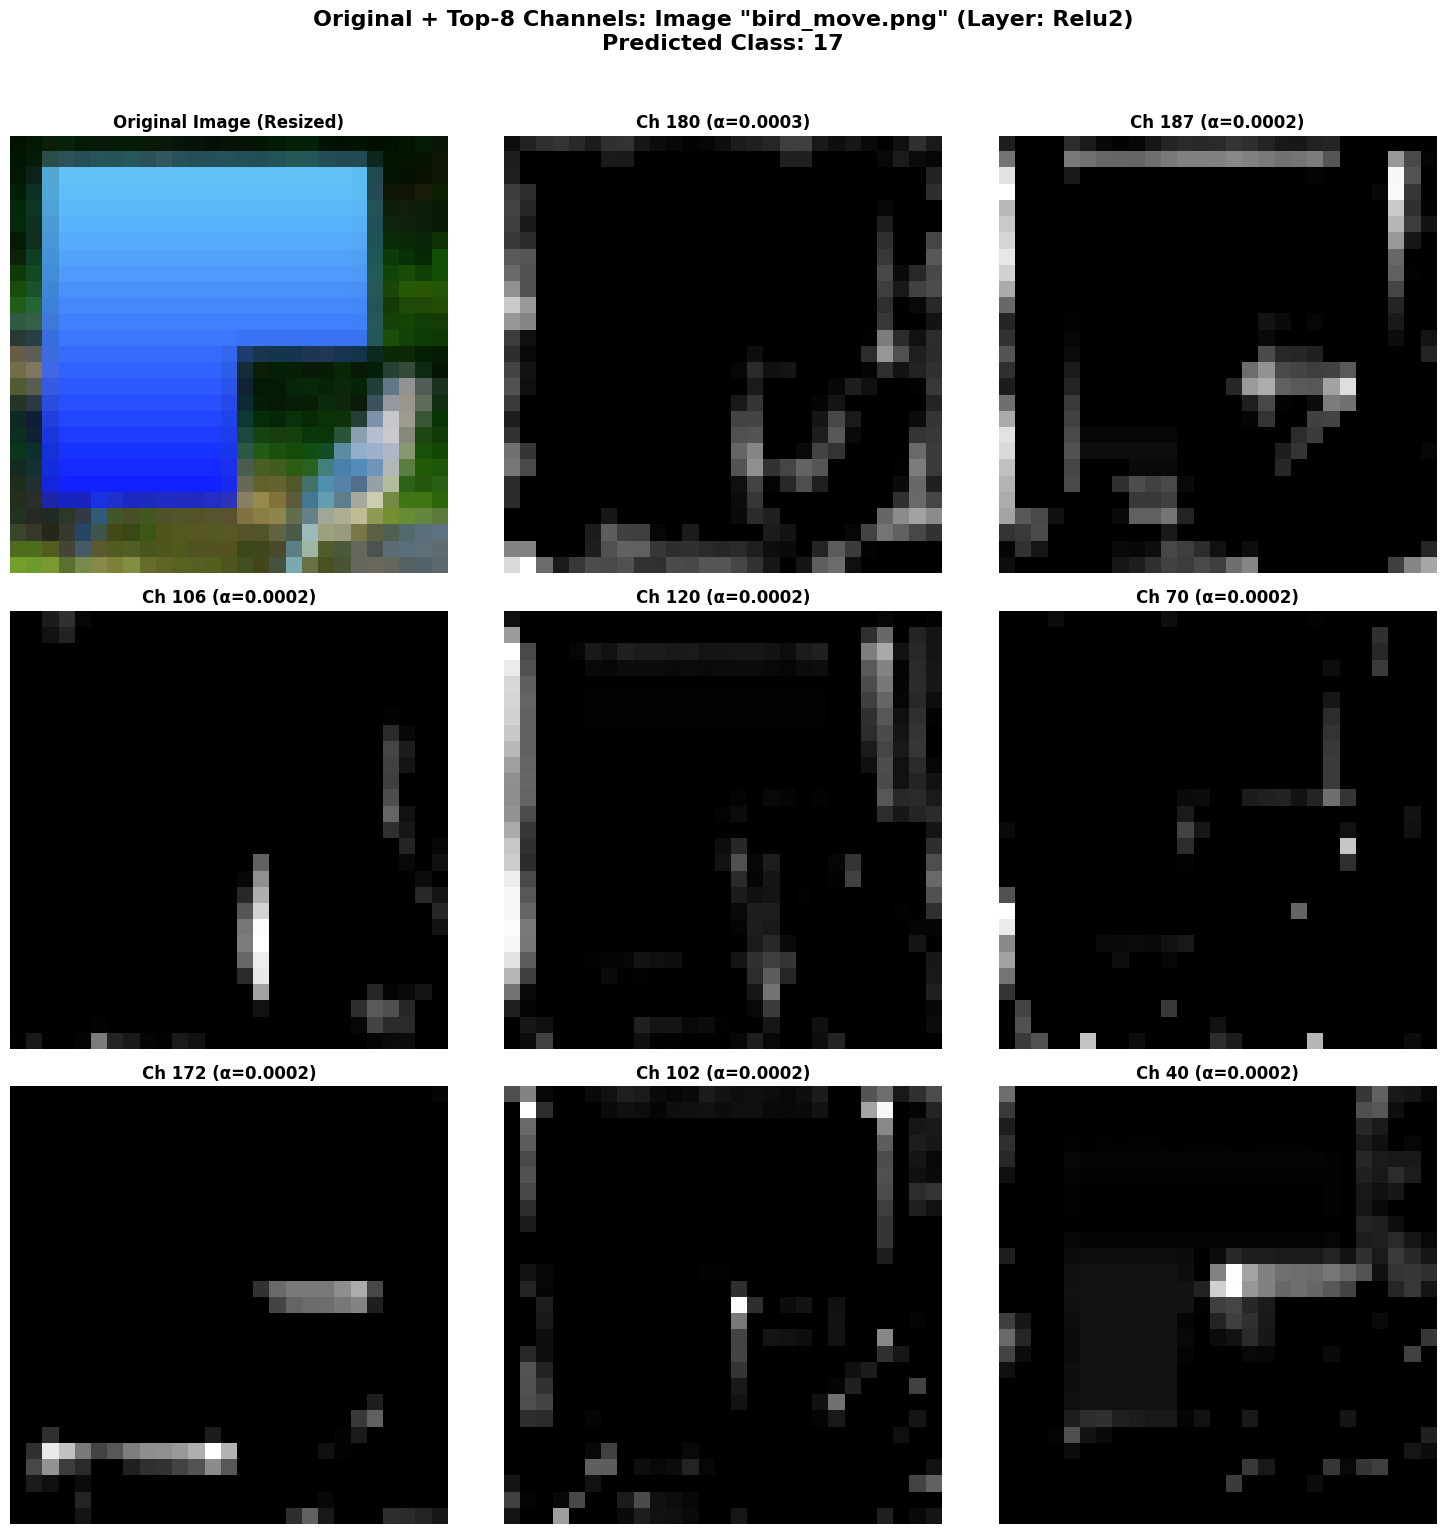

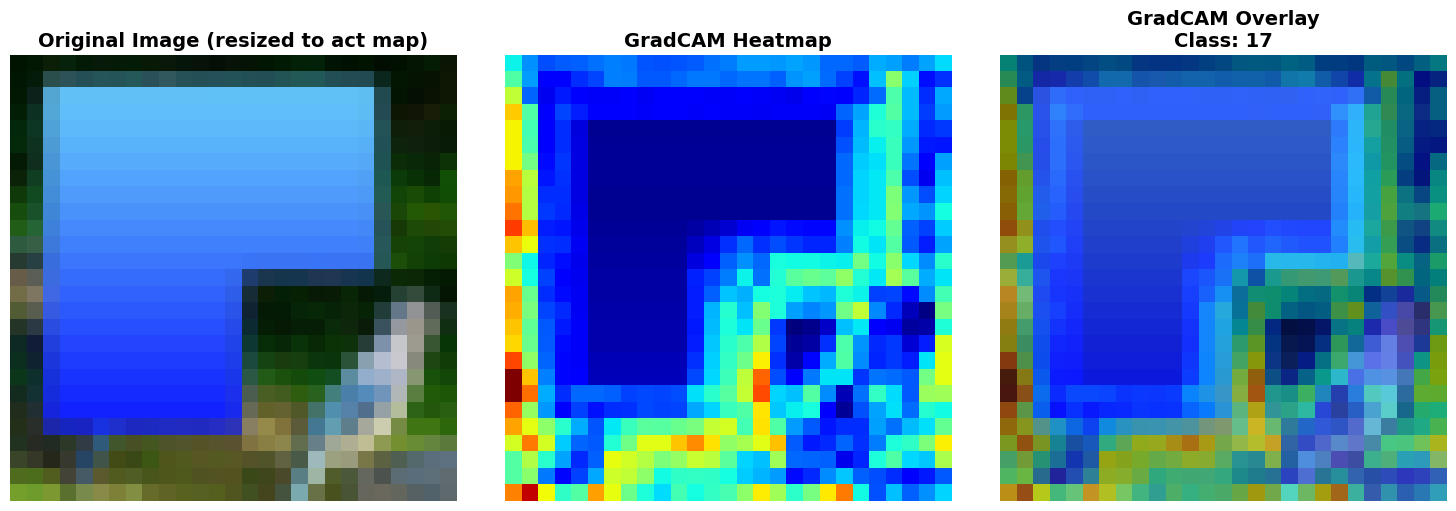

In [40]:
# Relu 2 of bird move
analyze_layer(model, img_bird_move_tensor, img_bird_move, 4, "Relu2", img_path_move, class_idx_bird_move)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 46.6995

  PHÂN TÍCH LAYER: Relu3 (Index: 7)
Predicted class: 17
Number of channels: 384
Number of non-zero weights: 155
Number of zero weights (after ReLU): 229


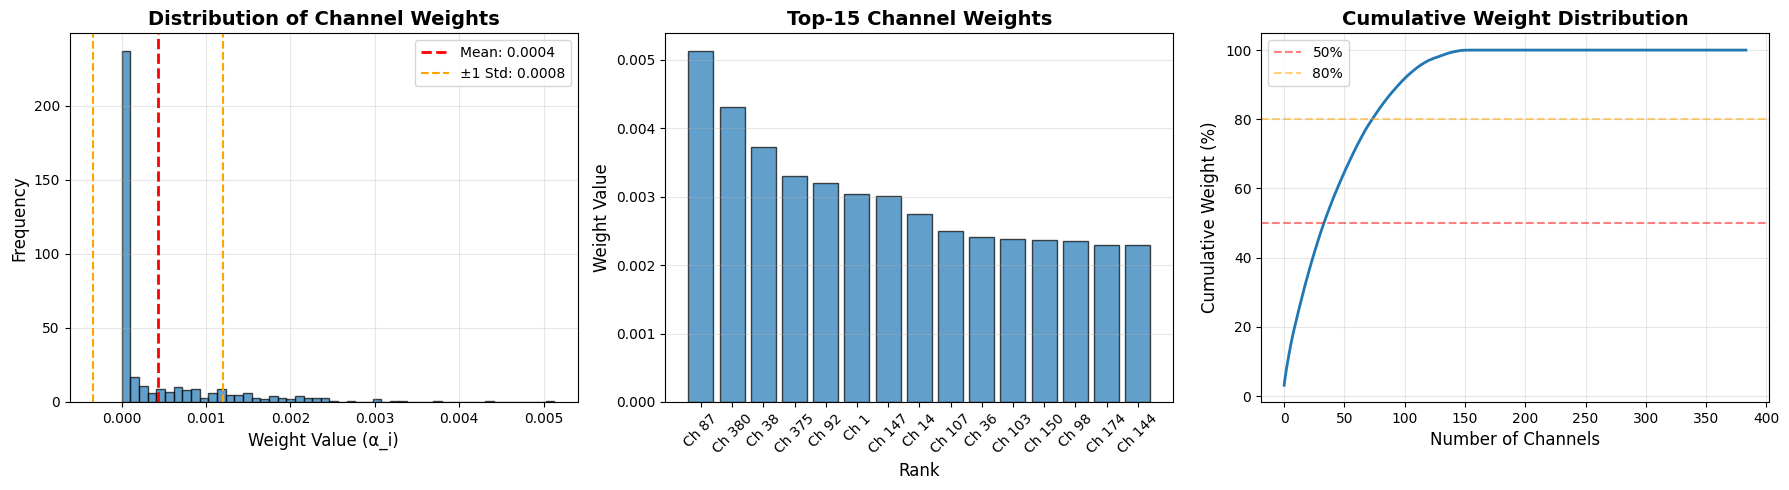


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 384
Mean weight: 0.000426
Std weight: 0.000771
Min weight: 0.000000
Max weight: 0.005130
Weight range: 0.005130

Concentration Analysis:
Top 10% channels (38 channels) contribute: 53.82% of total weight
Top 34 channels contribute 50% of total weight
Top 75 channels contribute 80% of total weight

KL Divergence from uniform: 1.245464
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      87           0.005130        100.00      %
2      380          0.004316        84.14       %
3      38           0.003729        72.69       %
4      375          0.003305        64.43       %
5      92           0.003201        62.40       %
6      1            0.003039        59.24       %
7      147          0.003006        58.60       %
8      14           0.002741        53.43       %
9      107          0.002497     

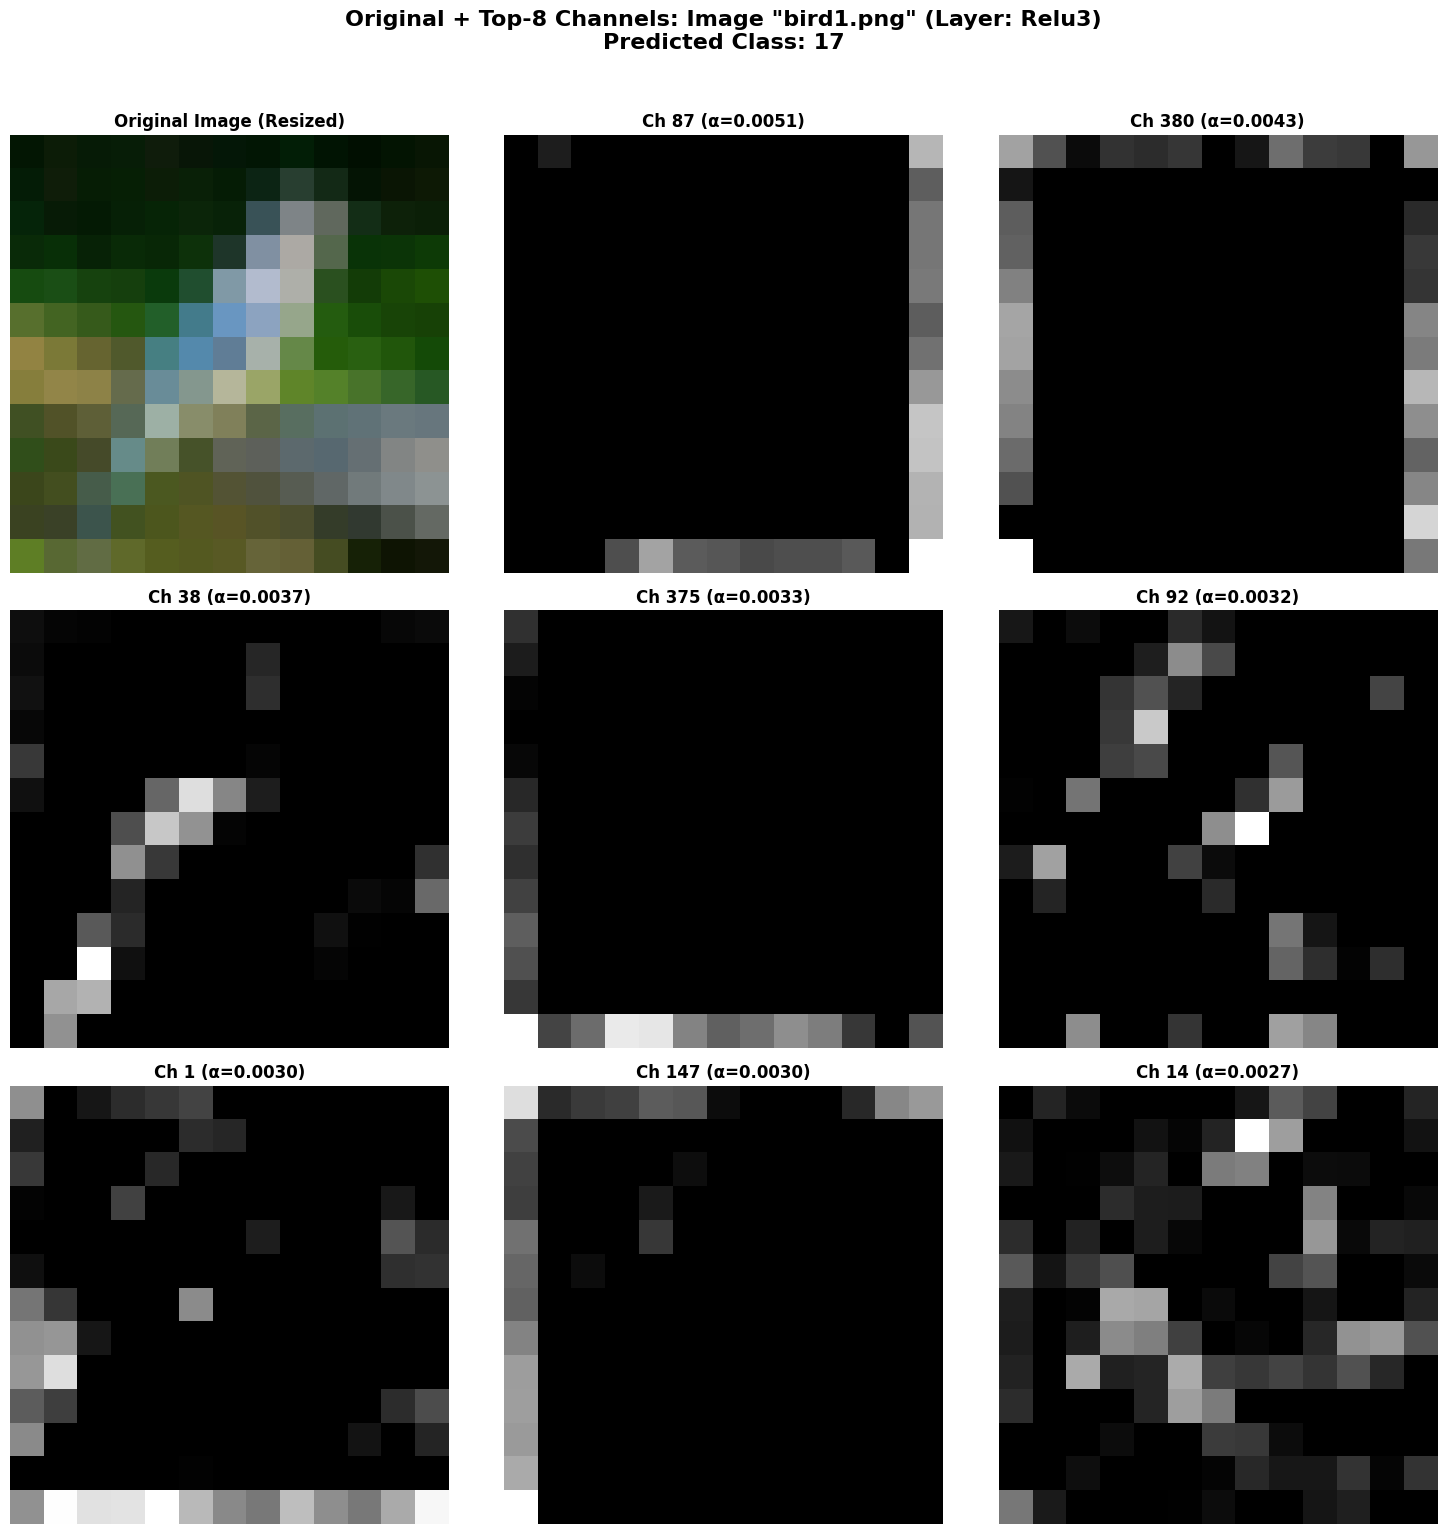

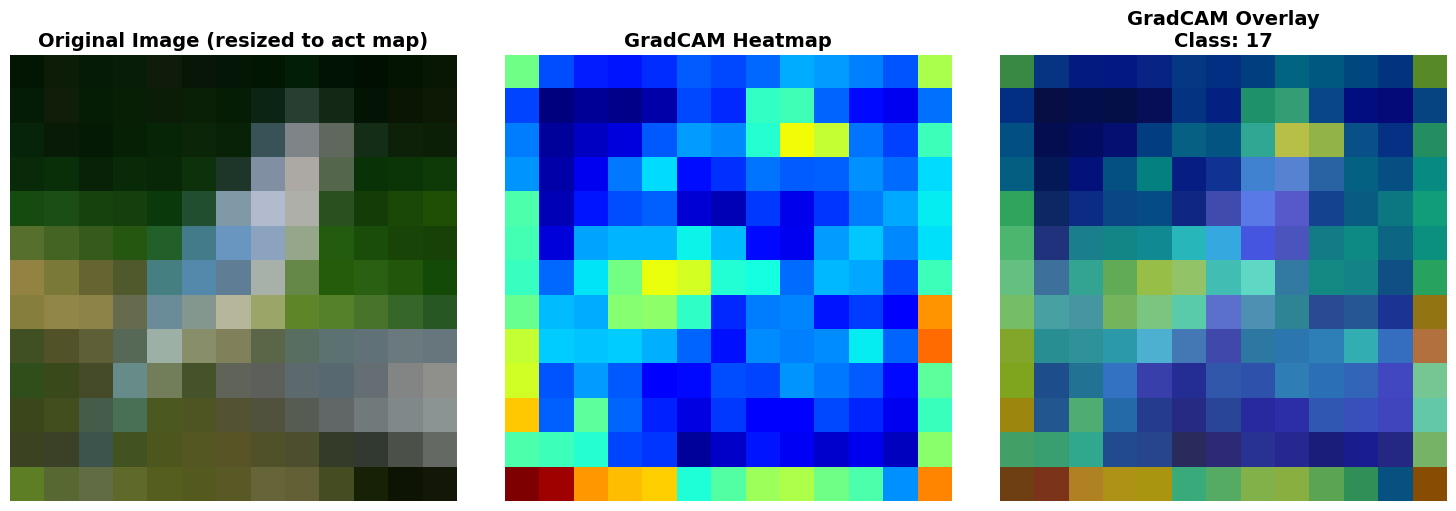

In [42]:
# Relu 3 of bird
analyze_layer(model, img_bird_tensor, img_bird, 7, "Relu3", img_path_bird, class_idx_bird)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 67.9488

  PHÂN TÍCH LAYER: Relu3 (Index: 7)
Predicted class: 17
Number of channels: 384
Number of non-zero weights: 199
Number of zero weights (after ReLU): 185


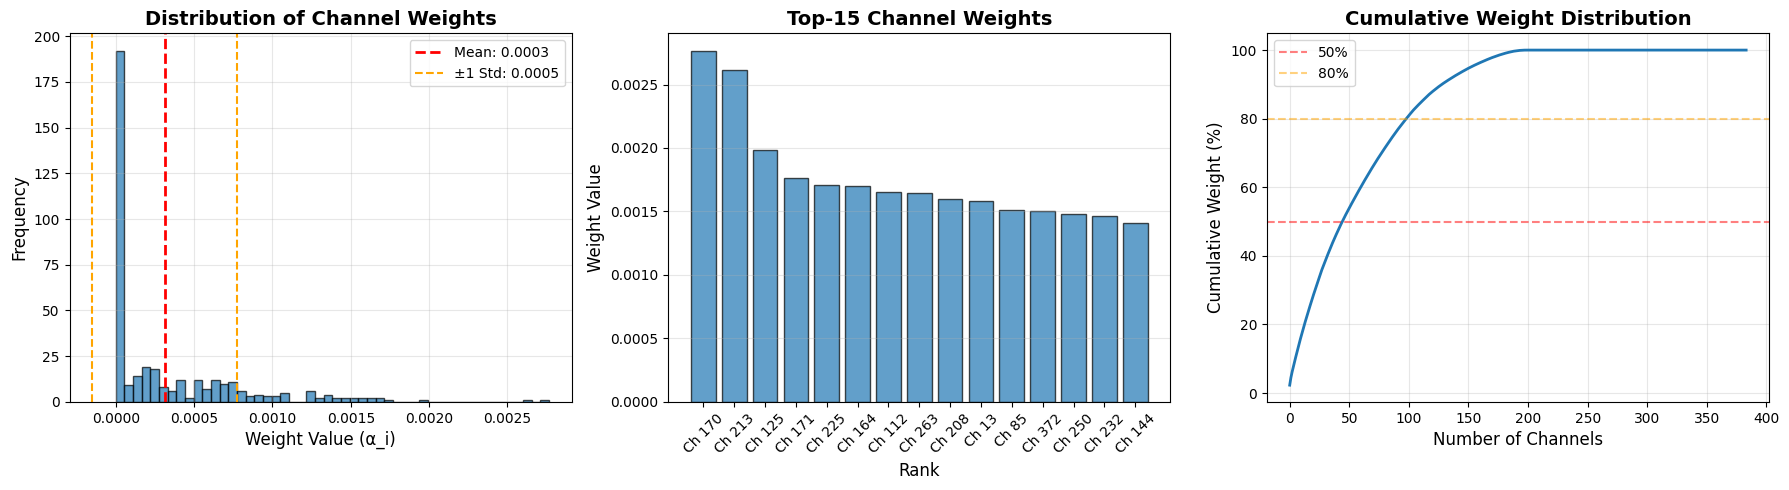


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 384
Mean weight: 0.000314
Std weight: 0.000462
Min weight: 0.000000
Max weight: 0.002765
Weight range: 0.002765

Concentration Analysis:
Top 10% channels (38 channels) contribute: 44.64% of total weight
Top 46 channels contribute 50% of total weight
Top 99 channels contribute 80% of total weight

KL Divergence from uniform: 0.953456
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      170          0.002765        100.00      %
2      213          0.002616        94.64       %
3      125          0.001985        71.80       %
4      171          0.001767        63.92       %
5      225          0.001709        61.83       %
6      164          0.001697        61.38       %
7      112          0.001656        59.91       %
8      263          0.001647        59.58       %
9      208          0.001599 

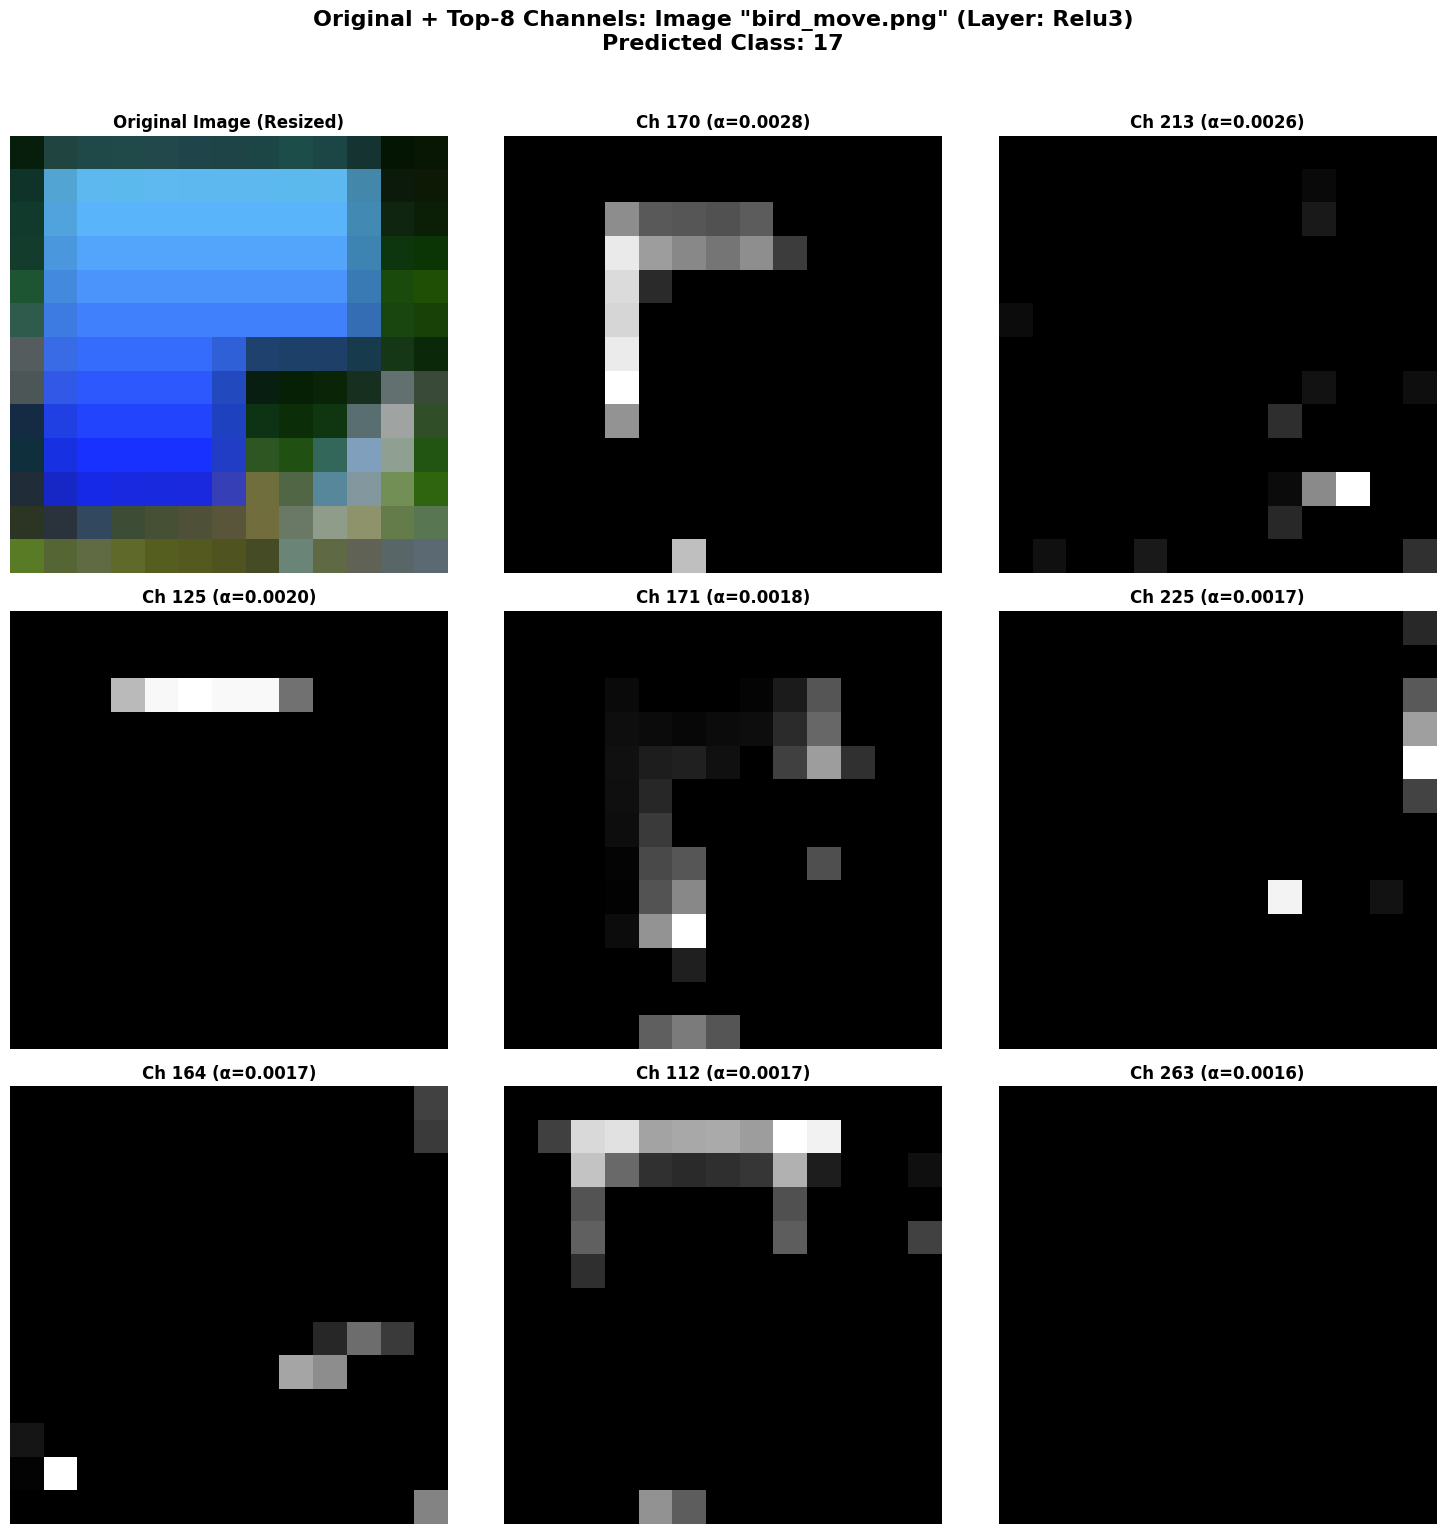

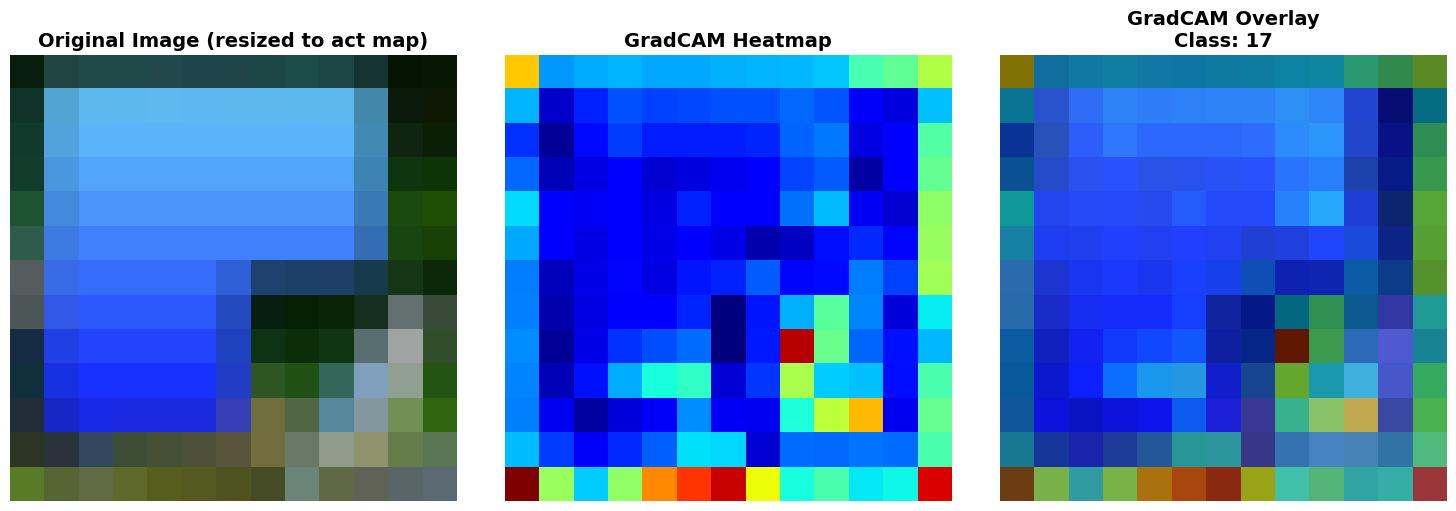

In [43]:
# Relu 3 of bird move   
analyze_layer(model, img_bird_move_tensor, img_bird_move, 7, "Relu3", img_path_move, class_idx_bird_move)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 30.6525

  PHÂN TÍCH LAYER: Relu4 (Index: 9)
Predicted class: 17
Number of channels: 256
Number of non-zero weights: 95
Number of zero weights (after ReLU): 161


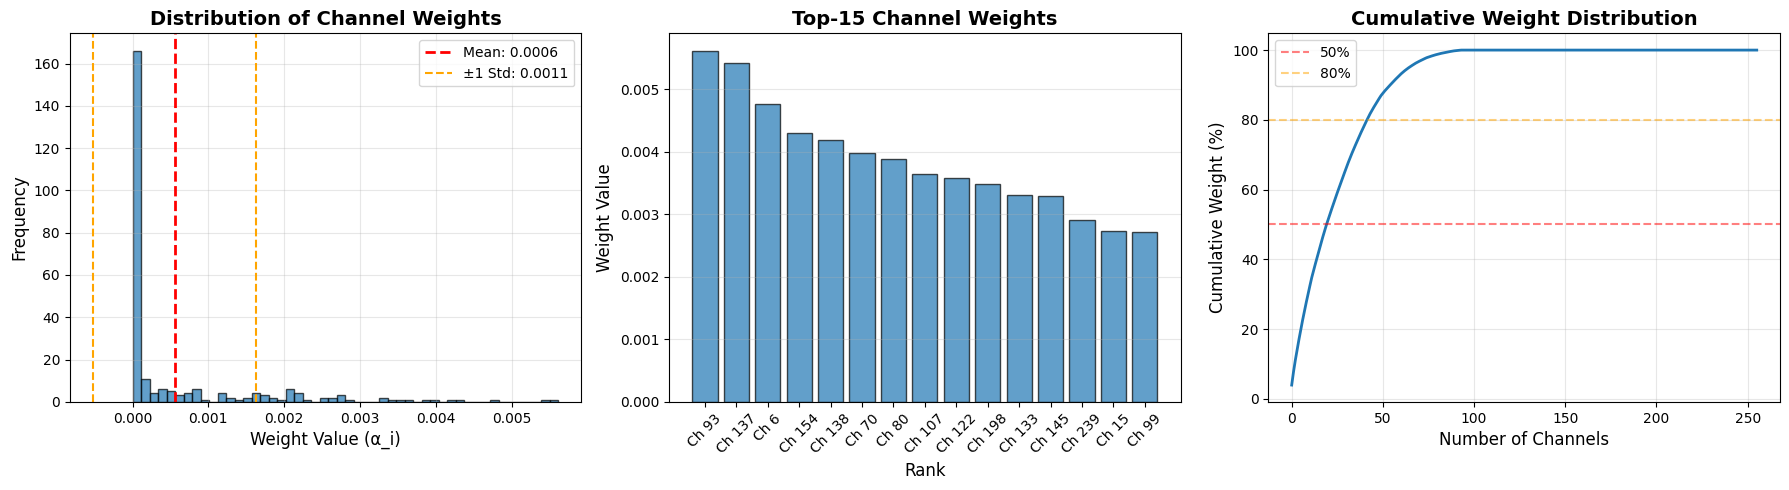


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000555
Std weight: 0.001075
Min weight: 0.000000
Max weight: 0.005610
Weight range: 0.005610

Concentration Analysis:
Top 10% channels (25 channels) contribute: 57.62% of total weight
Top 21 channels contribute 50% of total weight
Top 43 channels contribute 80% of total weight

KL Divergence from uniform: 1.366488
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      93           0.005610        100.00      %
2      137          0.005414        96.51       %
3      6            0.004768        84.98       %
4      154          0.004292        76.50       %
5      138          0.004186        74.61       %
6      70           0.003973        70.83       %
7      80           0.003885        69.25       %
8      107          0.003644        64.95       %
9      122          0.003576     

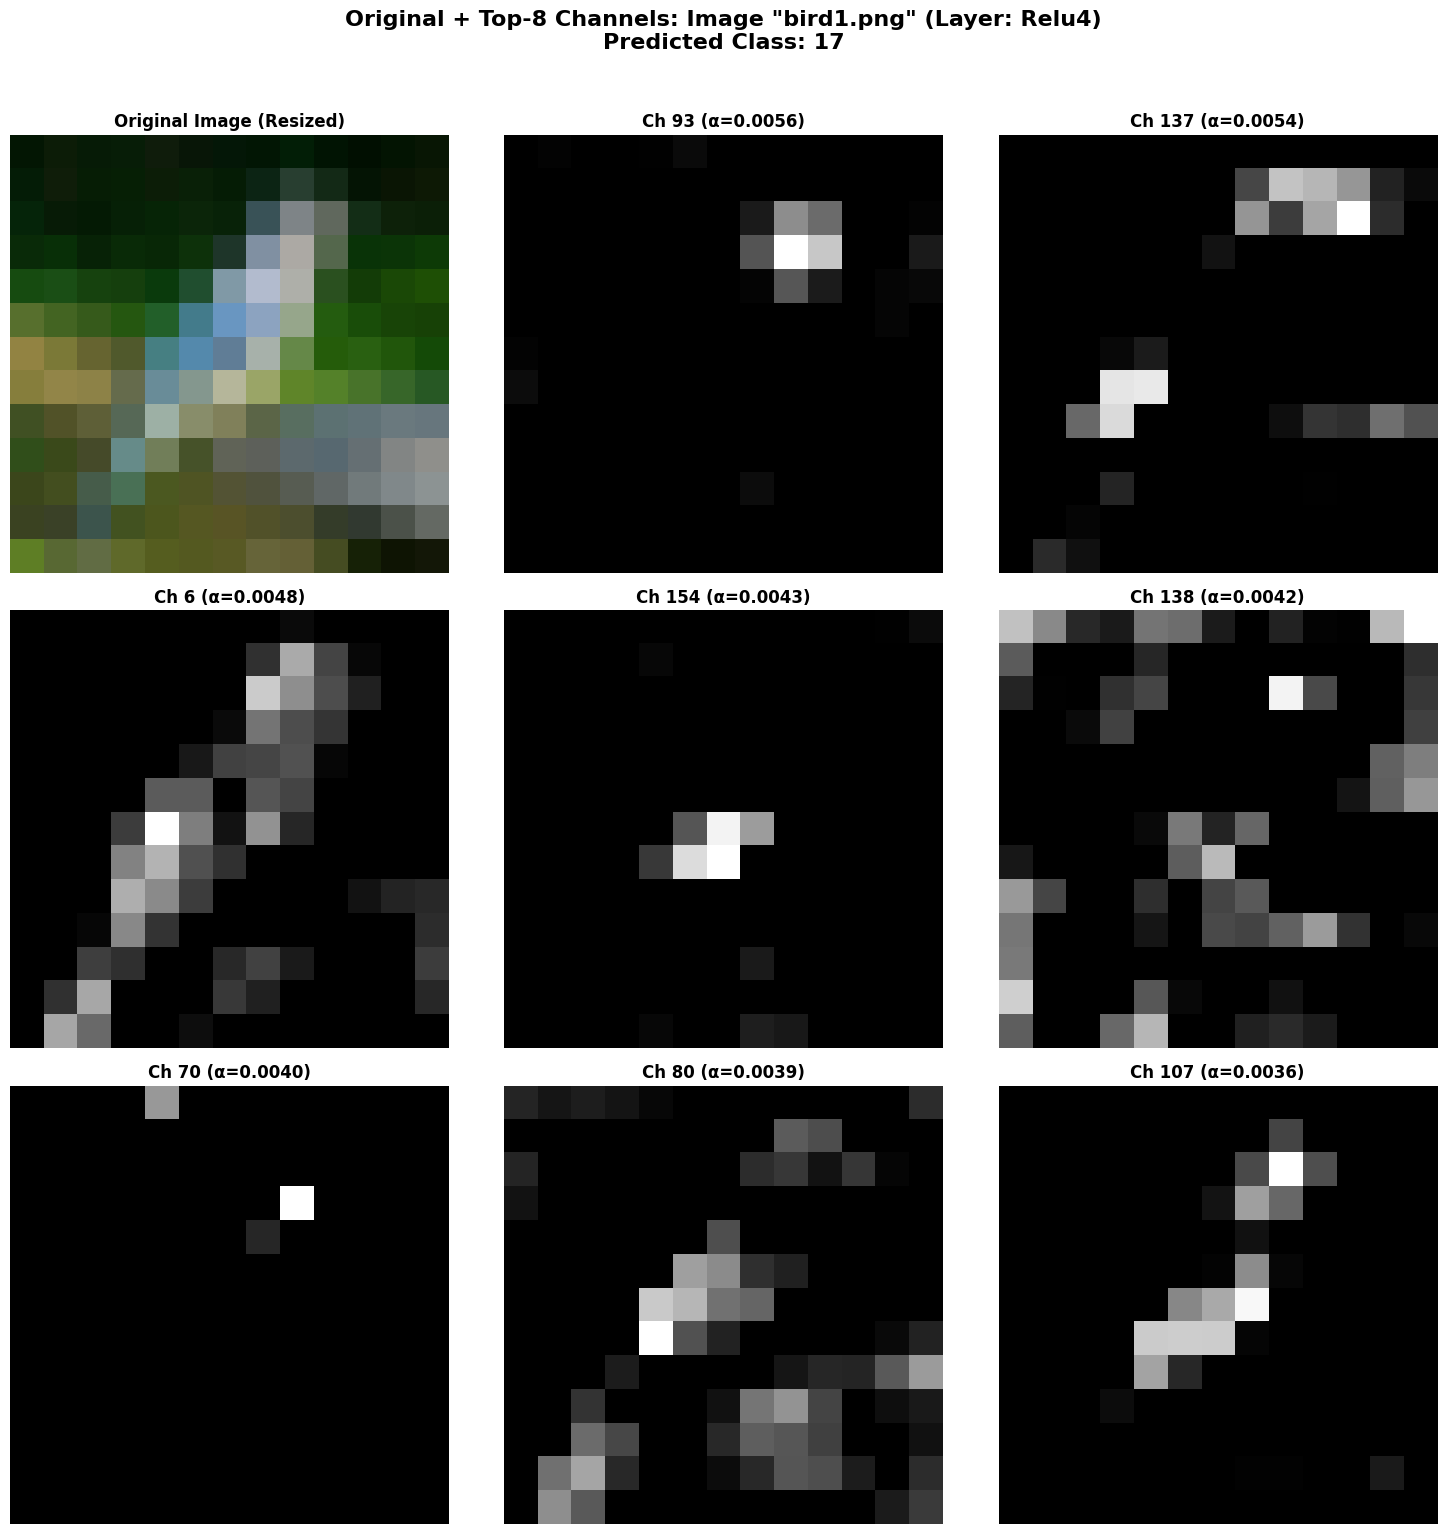

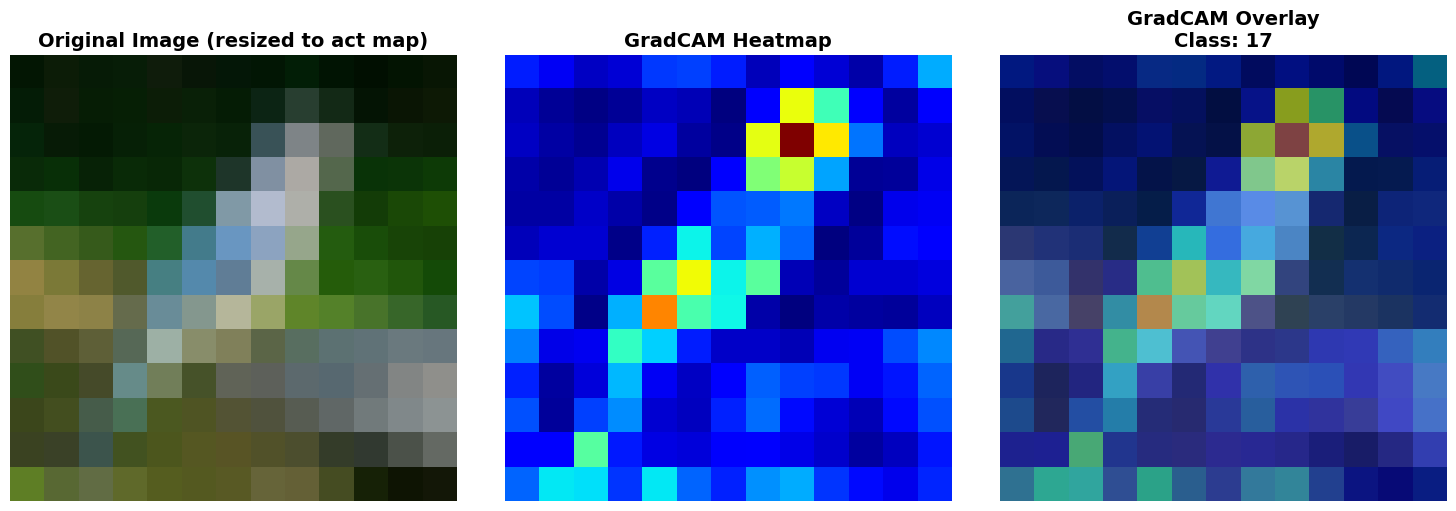

In [44]:
# Relu 4 of bird
analyze_layer(model, img_bird_tensor, img_bird, 9, "Relu4", img_path_bird, class_idx_bird)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 31.7694

  PHÂN TÍCH LAYER: Relu4 (Index: 9)
Predicted class: 17
Number of channels: 256
Number of non-zero weights: 109
Number of zero weights (after ReLU): 147


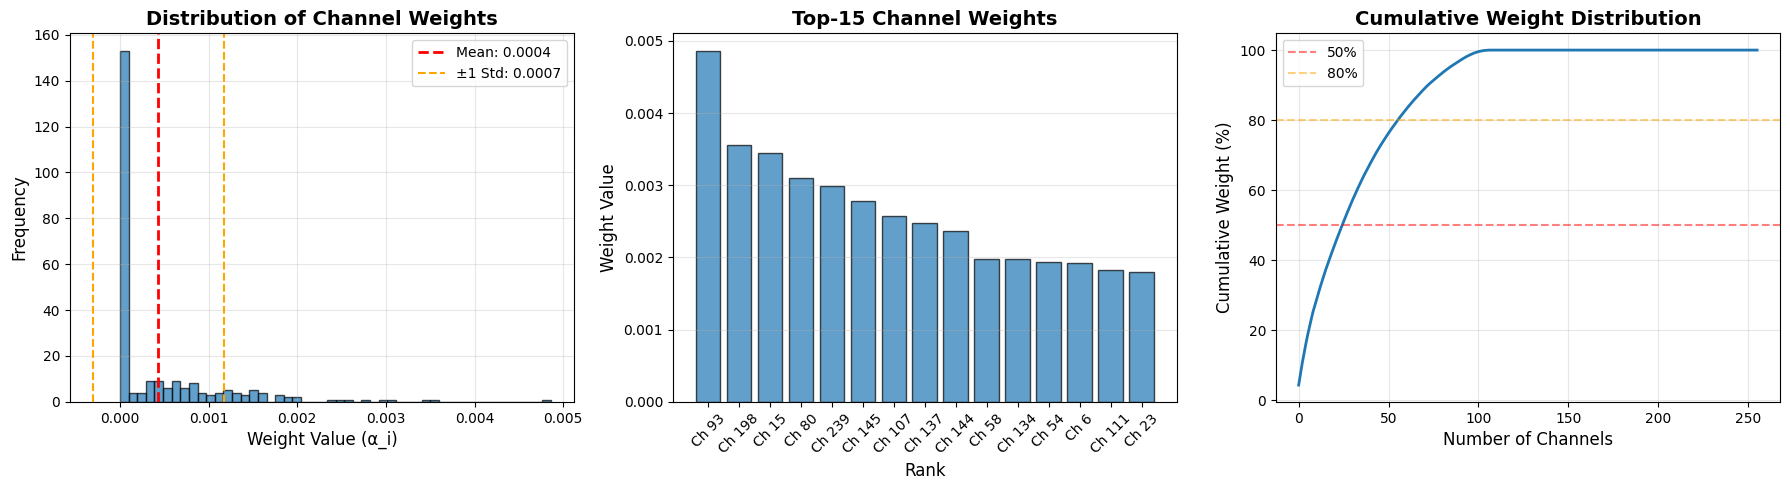


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000434
Std weight: 0.000741
Min weight: 0.000000
Max weight: 0.004863
Weight range: 0.004863

Concentration Analysis:
Top 10% channels (25 channels) contribute: 49.76% of total weight
Top 26 channels contribute 50% of total weight
Top 57 channels contribute 80% of total weight

KL Divergence from uniform: 1.147795
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      93           0.004863        100.00      %
2      198          0.003555        73.11       %
3      15           0.003447        70.88       %
4      80           0.003095        63.65       %
5      239          0.002991        61.52       %
6      145          0.002786        57.30       %
7      107          0.002569        52.83       %
8      137          0.002478        50.97       %
9      144          0.002366     

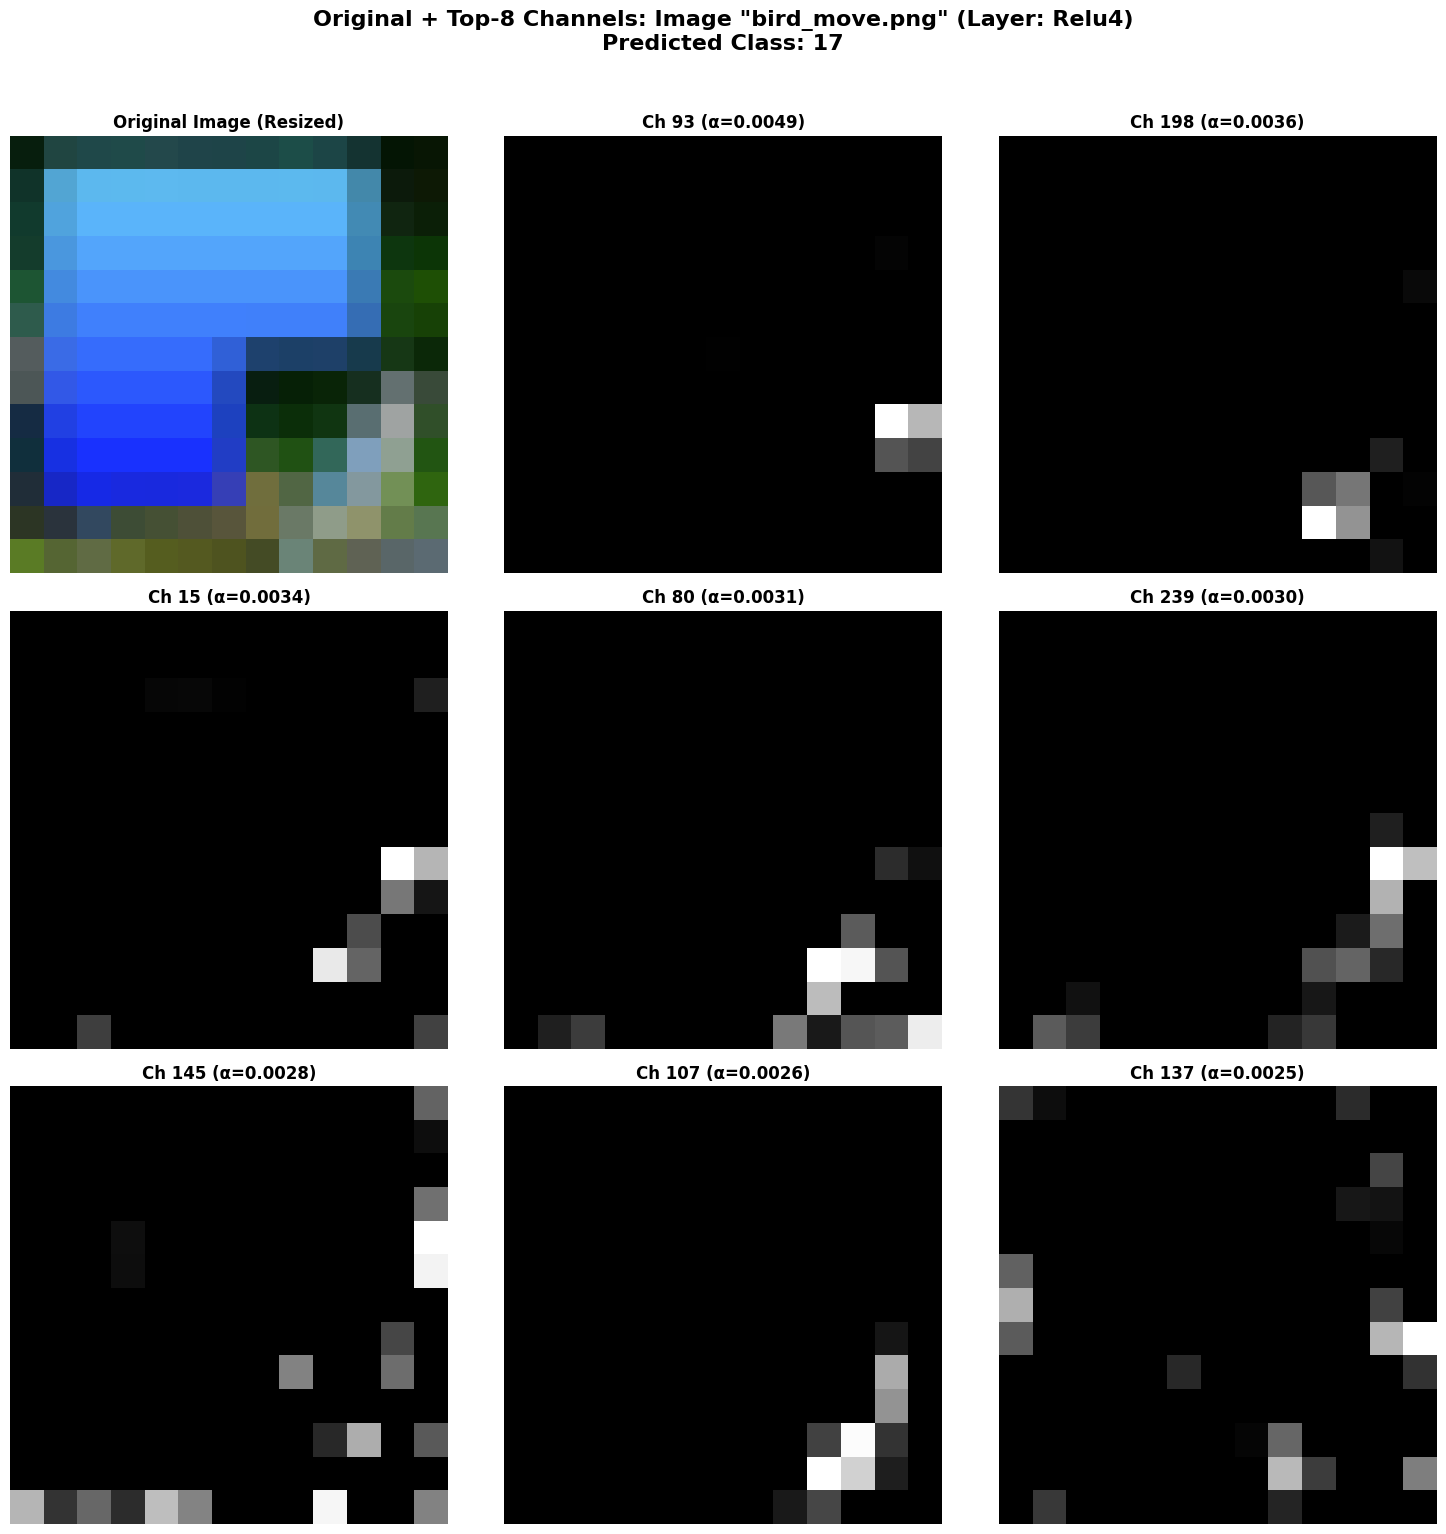

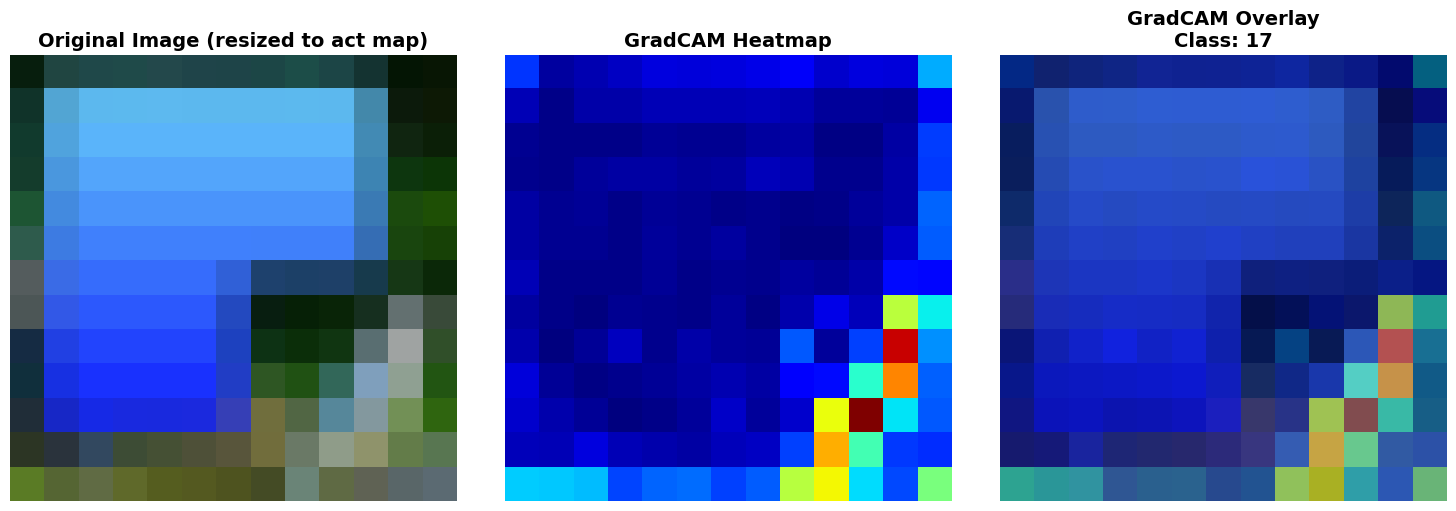

In [45]:
# Relu 4 of bird move
analyze_layer(model, img_bird_move_tensor, img_bird_move, 9, "Relu4", img_path_move, class_idx_bird_move)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 19.5622

  PHÂN TÍCH LAYER: Relu5 (Index: 11)
Predicted class: 17
Number of channels: 256
Number of non-zero weights: 112
Number of zero weights (after ReLU): 144


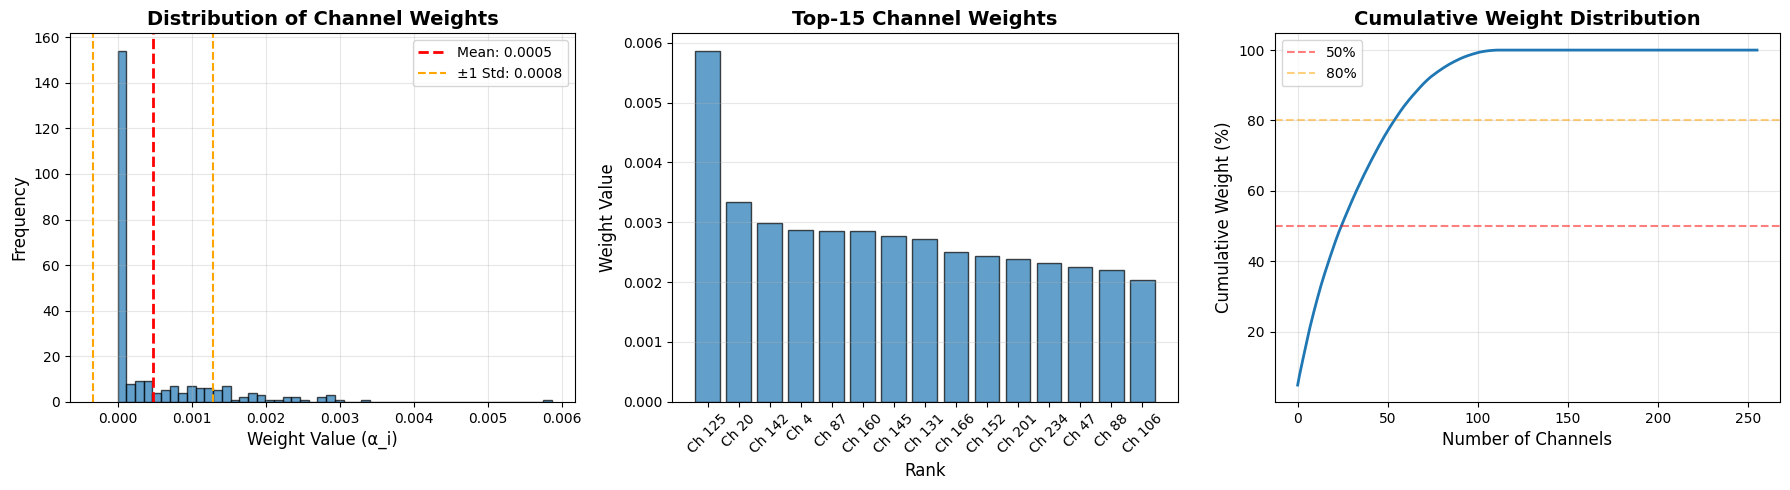


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000475
Std weight: 0.000809
Min weight: 0.000000
Max weight: 0.005862
Weight range: 0.005862

Concentration Analysis:
Top 10% channels (25 channels) contribute: 49.74% of total weight
Top 26 channels contribute 50% of total weight
Top 55 channels contribute 80% of total weight

KL Divergence from uniform: 1.150164
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      125          0.005862        100.00      %
2      20           0.003334        56.87       %
3      142          0.002982        50.86       %
4      4            0.002873        49.02       %
5      87           0.002860        48.79       %
6      160          0.002859        48.78       %
7      145          0.002768        47.22       %
8      131          0.002722        46.43       %
9      166          0.002497     

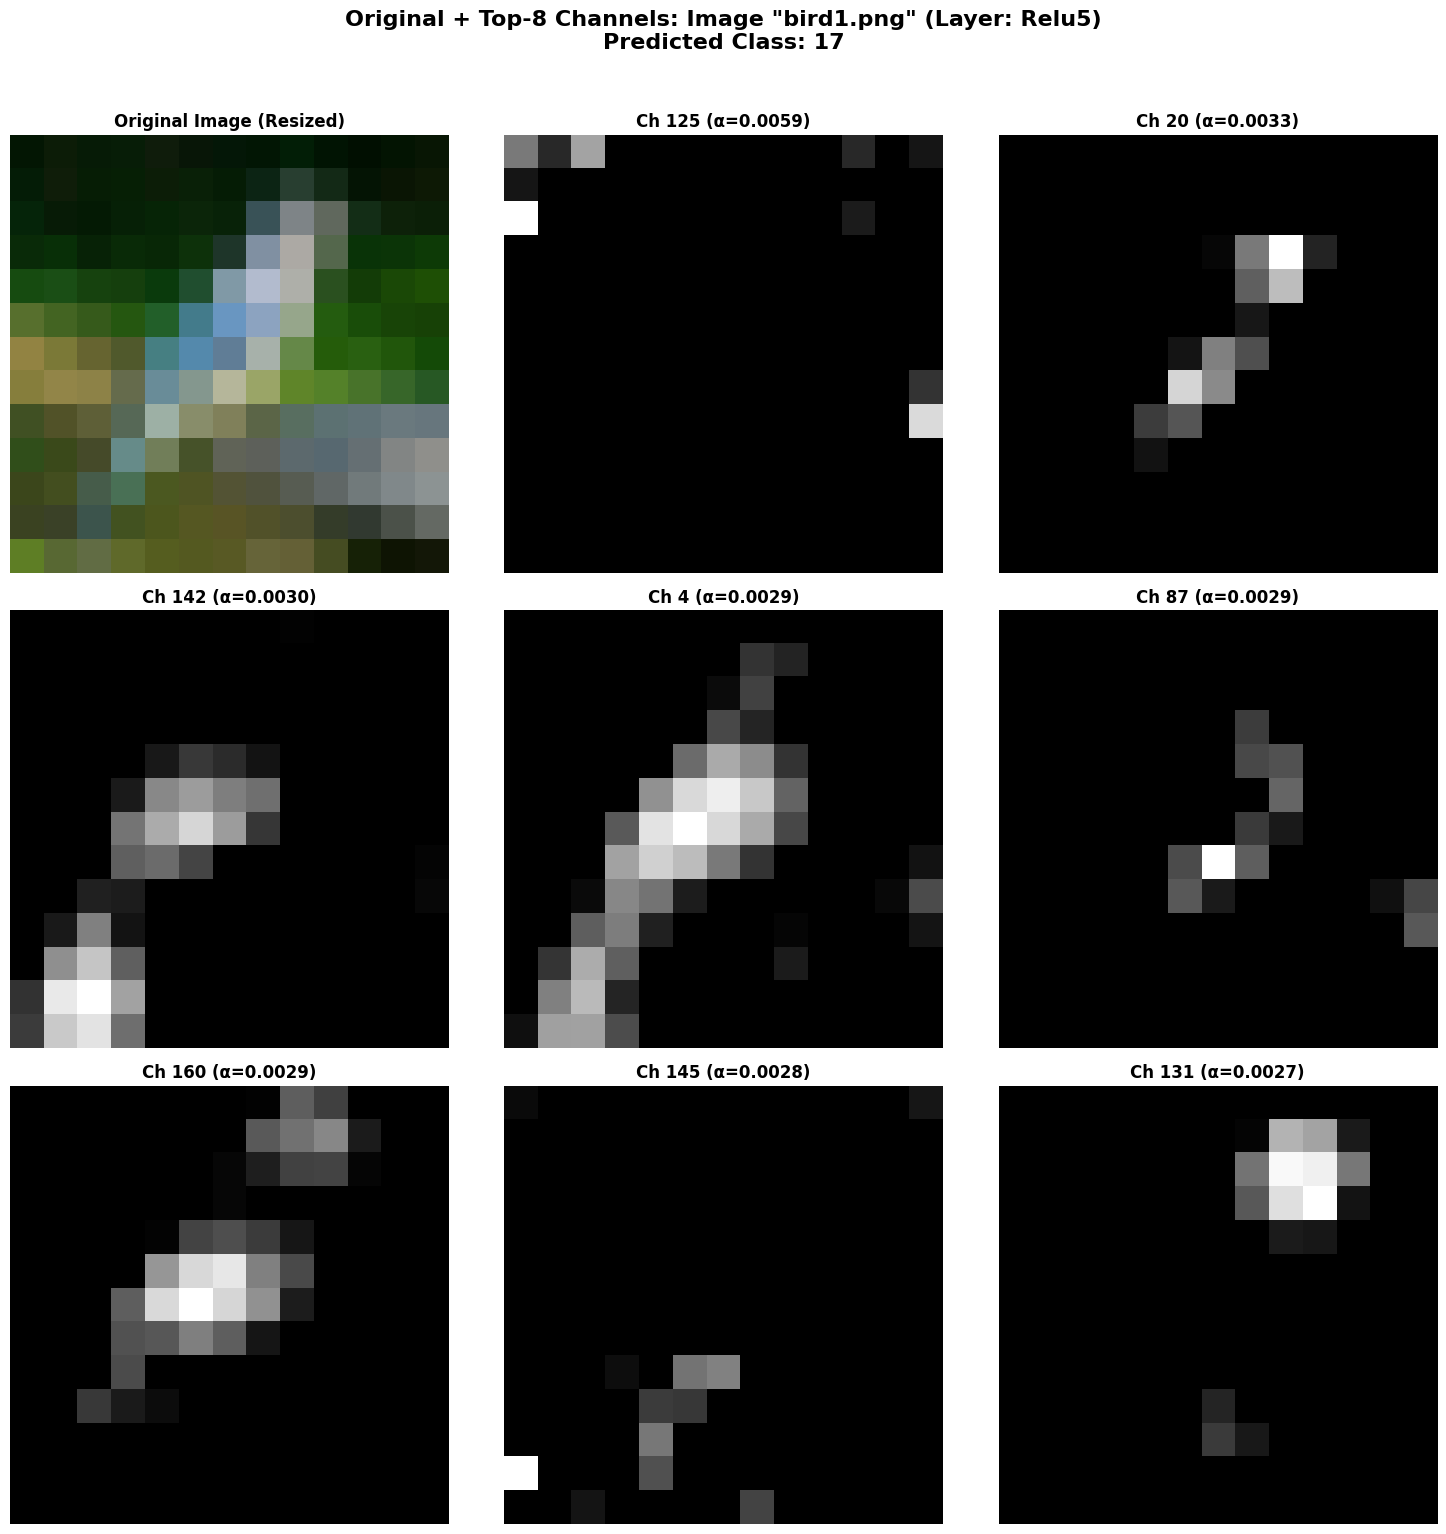

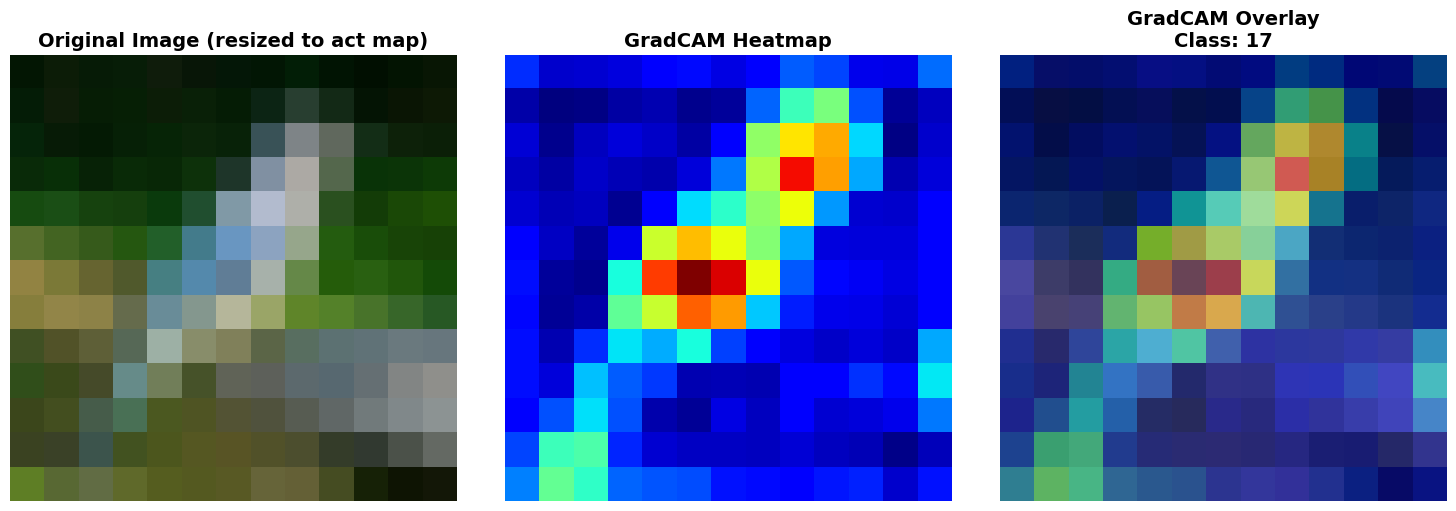

In [46]:
# Relu 5 of bird
analyze_layer(model, img_bird_tensor, img_bird, 11, "Relu5", img_path_bird, class_idx_bird)

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 17.4580

  PHÂN TÍCH LAYER: Relu5 (Index: 11)
Predicted class: 17
Number of channels: 256
Number of non-zero weights: 121
Number of zero weights (after ReLU): 135


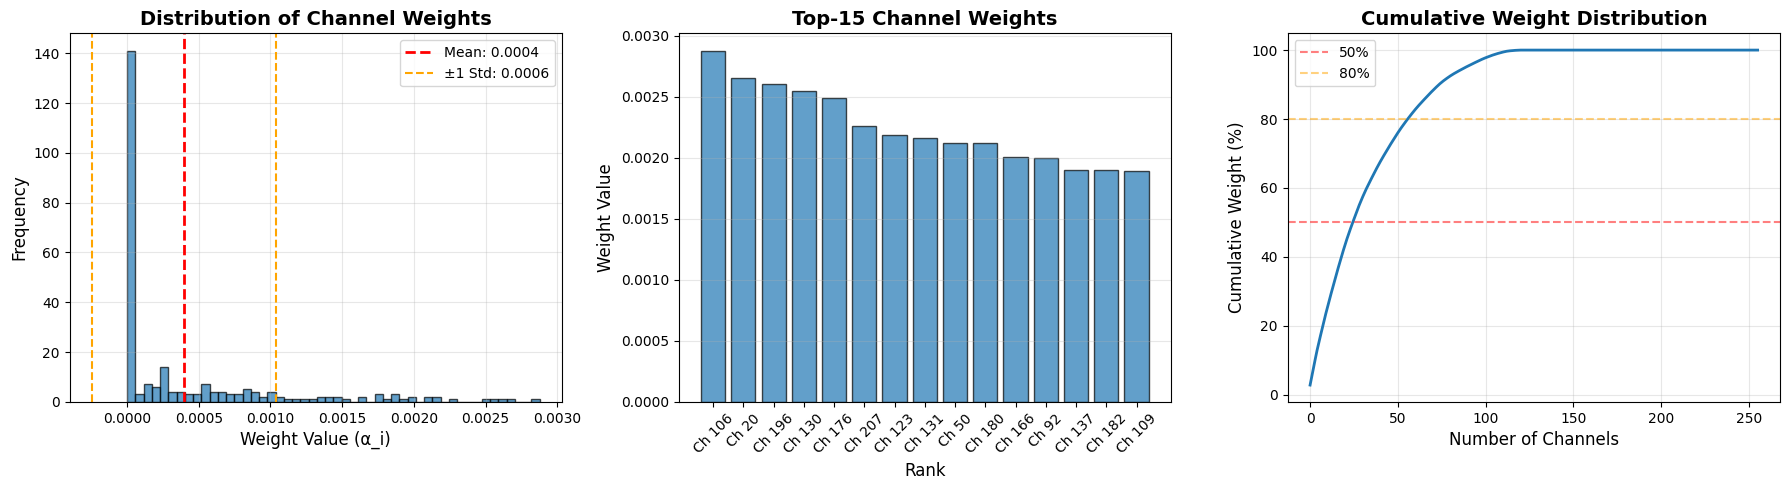


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000397
Std weight: 0.000641
Min weight: 0.000000
Max weight: 0.002876
Weight range: 0.002876

Concentration Analysis:
Top 10% channels (25 channels) contribute: 49.60% of total weight
Top 26 channels contribute 50% of total weight
Top 57 channels contribute 80% of total weight

KL Divergence from uniform: 1.087026
→ Distribution is HIGHLY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      106          0.002876        100.00      %
2      20           0.002655        92.32       %
3      196          0.002608        90.68       %
4      130          0.002549        88.64       %
5      176          0.002493        86.68       %
6      207          0.002259        78.53       %
7      123          0.002186        75.99       %
8      131          0.002166        75.29       %
9      50           0.002125     

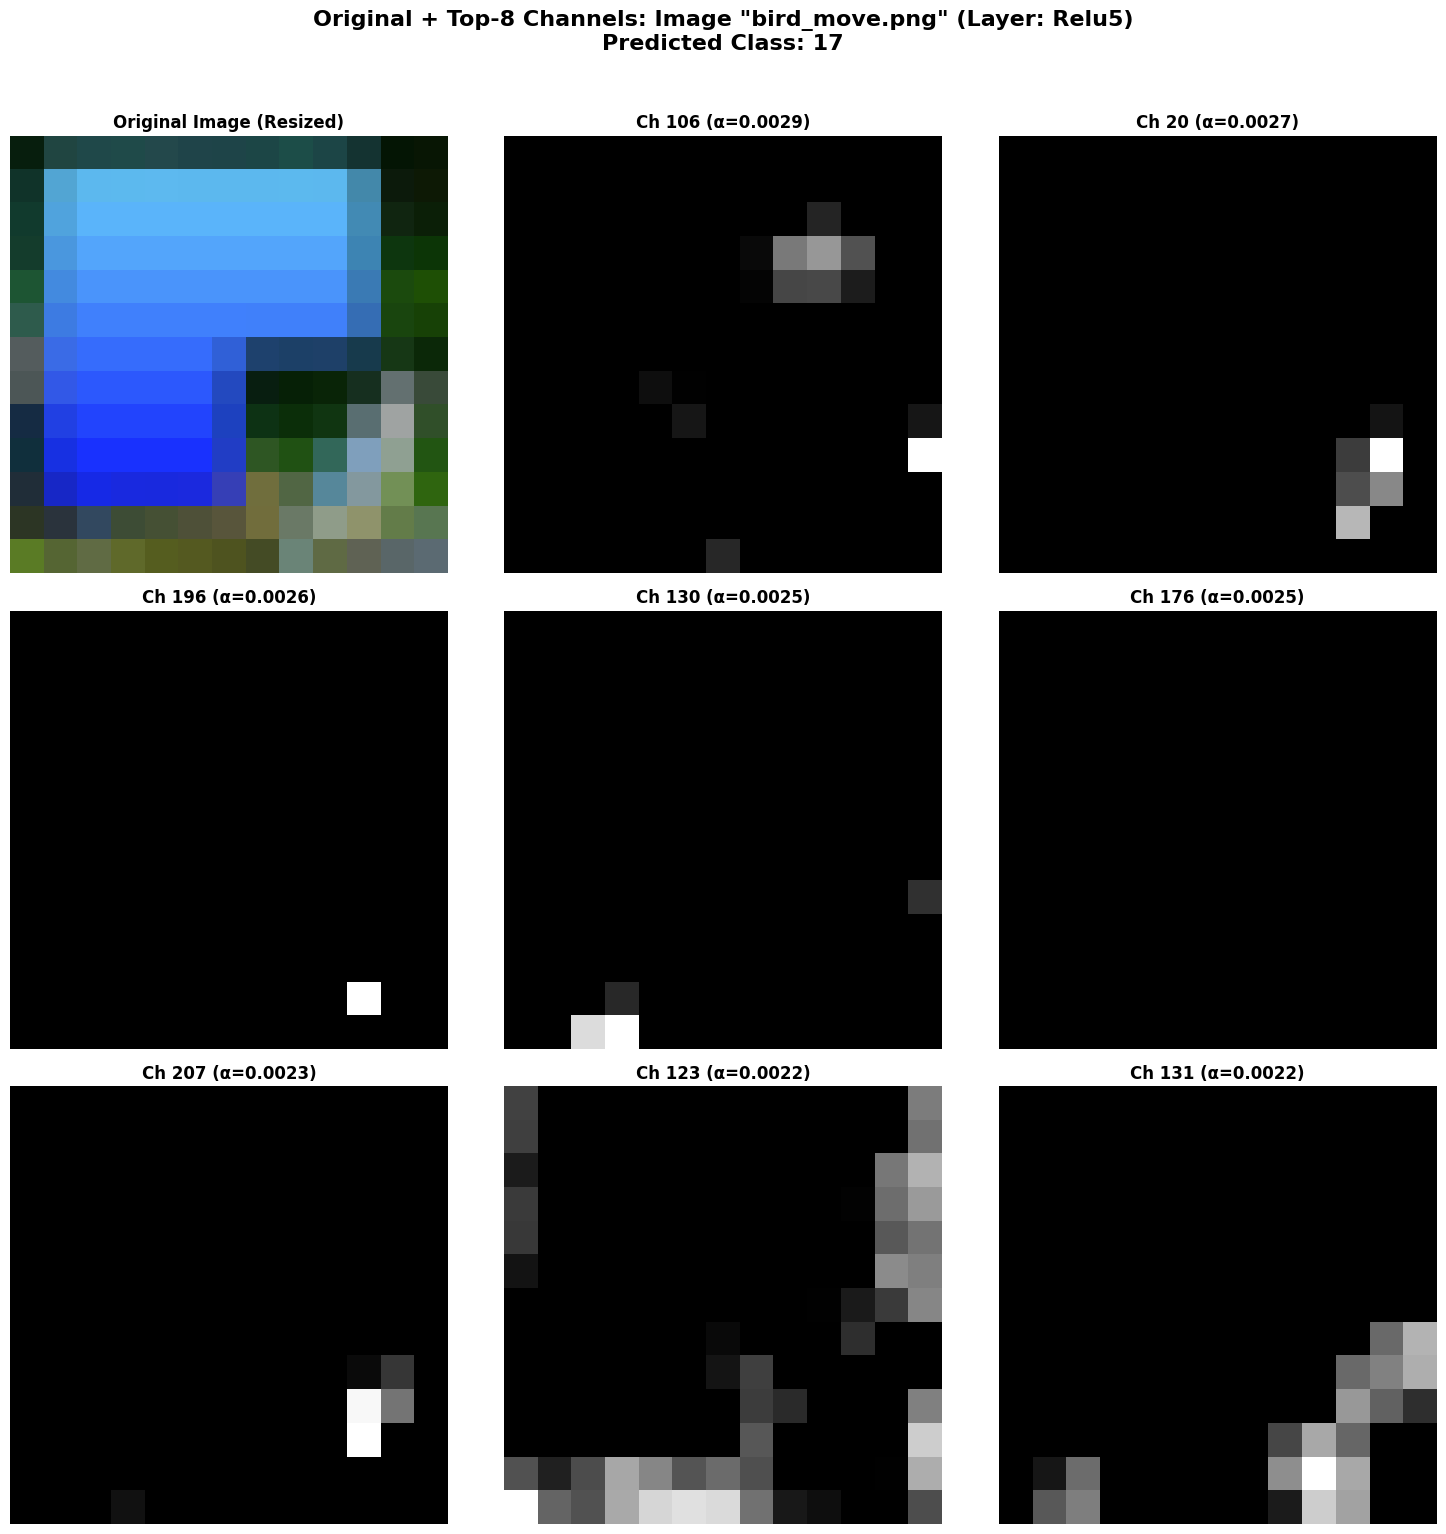

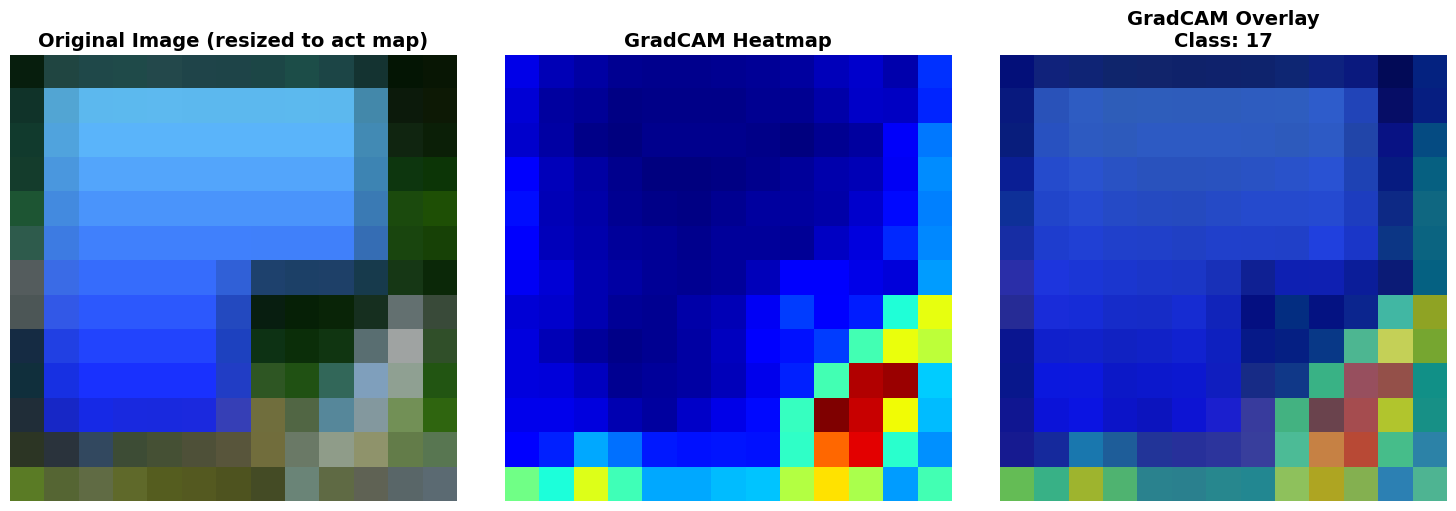

In [47]:
# Relu 5 of bird move
analyze_layer(model, img_bird_move_tensor, img_bird_move, 11, "Relu5", img_path_move, class_idx_bird_move)

In [48]:
compare_top_channels_across_images(
    model, img_bird_tensor, img_bird_move_tensor, 
    layer_index=1, 
    img1_name=img_path_bird, 
    img2_name=img_path_move,    
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 1 GIỮA "bird1.png" VÀ "bird_move.png"
Activations - min: 0.0000, max: 23.3526
Activations - min: 0.0000, max: 30.4618
Predicted class for bird1.png: 17
Predicted class for bird_move.png: 17

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 8            | 0.000582        | 1      | 0.000559        | 19.75          % |
| 2      | 60           | 0.000574        | 10     | 0.000117        | 4.14           % |
| 3      | 54           | 0.000452        | 11     | 0.000104        | 3.68           % |
| 4      | 5            | 0.000423        | 59     | 0.000000        | 0.00           % |
| 5      | 47           | 0.000398        | 7      | 0.000145        | 5.13           % |
| 6      | 25           | 0.000374        | 15     | 0.000064        | 2.27           % |
| 7      | 10           | 0.000325        | 9      | 0.000136        | 4.79           % |
| 8      | 62           | 0.000306        | 2      | 

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [50]:
compare_top_channels_across_images(
    model, img_bird_tensor, img_bird_move_tensor, 
    layer_index=4, 
    img1_name=img_path_bird, 
    img2_name=img_path_move,    
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 4 GIỮA "bird1.png" VÀ "bird_move.png"
Activations - min: 0.0000, max: 53.4932
Activations - min: 0.0000, max: 71.5203
Predicted class for bird1.png: 17
Predicted class for bird_move.png: 17

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 48           | 0.000615        | 84     | 0.000024        | 0.28           % |
| 2      | 127          | 0.000583        | 20     | 0.000134        | 1.53           % |
| 3      | 182          | 0.000541        | 115    | 0.000000        | 0.00           % |
| 4      | 2            | 0.000489        | 56     | 0.000072        | 0.83           % |
| 5      | 102          | 0.000479        | 7      | 0.000201        | 2.29           % |
| 6      | 69           | 0.000457        | 49     | 0.000081        | 0.93           % |
| 7      | 70           | 0.000426        | 5      | 0.000214        | 2.44           % |
| 8      | 76           | 0.000425        | 141    | 

In [51]:
compare_top_channels_across_images(
    model, img_bird_tensor, img_bird_move_tensor, 
    layer_index=7,
    img1_name=img_path_bird, 
    img2_name=img_path_move,    
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 7 GIỮA "bird1.png" VÀ "bird_move.png"
Activations - min: 0.0000, max: 46.6995
Activations - min: 0.0000, max: 67.9488
Predicted class for bird1.png: 17
Predicted class for bird_move.png: 17

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 87           | 0.005130        | 16     | 0.001385        | 1.15           % |
| 2      | 380          | 0.004316        | 250    | 0.000000        | 0.00           % |
| 3      | 38           | 0.003729        | 150    | 0.000228        | 0.19           % |
| 4      | 375          | 0.003305        | 26     | 0.001244        | 1.03           % |
| 5      | 92           | 0.003201        | 327    | 0.000000        | 0.00           % |
| 6      | 1            | 0.003039        | 38     | 0.000978        | 0.81           % |
| 7      | 147          | 0.003006        | 22     | 0.001280        | 1.06           % |
| 8      | 14           | 0.002741        | 109    | 

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [52]:
compare_top_channels_across_images(
    model, img_bird_tensor, img_bird_move_tensor, 
    layer_index=9,
    img1_name=img_path_bird, 
    img2_name=img_path_move,    
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 9 GIỮA "bird1.png" VÀ "bird_move.png"
Activations - min: 0.0000, max: 30.6525


/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations - min: 0.0000, max: 31.7694
Predicted class for bird1.png: 17
Predicted class for bird_move.png: 17

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 93           | 0.005610        | 1      | 0.004863        | 4.38           % |
| 2      | 137          | 0.005414        | 8      | 0.002478        | 2.23           % |
| 3      | 6            | 0.004768        | 13     | 0.001924        | 1.73           % |
| 4      | 154          | 0.004292        | 18     | 0.001610        | 1.45           % |
| 5      | 138          | 0.004186        | 20     | 0.001562        | 1.41           % |
| 6      | 70           | 0.003973        | 58     | 0.000766        | 0.69           % |
| 7      | 80           | 0.003885        | 4      | 0.003095        | 2.79           % |
| 8      | 107          | 0.003644        | 7      | 0.002569        | 2.31           % |
| 9      | 122          | 0.003576        | 46     | 0.000958        | 0.86   

In [53]:
compare_top_channels_across_images(
    model, img_bird_tensor, img_bird_move_tensor, 
    layer_index=11,
    img1_name=img_path_bird, 
    img2_name=img_path_move,    
    top_k=10
)


  SO SÁNH TOP-10 CHANNELS CỦA Layer 11 GIỮA "bird1.png" VÀ "bird_move.png"
Activations - min: 0.0000, max: 19.5622
Activations - min: 0.0000, max: 17.4580
Predicted class for bird1.png: 17
Predicted class for bird_move.png: 17

| Rank 1 | Channel ID   | Weight 1        | Rank 2 | Weight 2        | % Contrib 2     |
| 1      | 125          | 0.005862        | 16     | 0.001866        | 1.83           % |
| 2      | 20           | 0.003334        | 2      | 0.002655        | 2.61           % |
| 3      | 142          | 0.002982        | 36     | 0.001023        | 1.01           % |
| 4      | 4            | 0.002873        | 37     | 0.001021        | 1.00           % |
| 5      | 87           | 0.002860        | 46     | 0.000862        | 0.85           % |
| 6      | 160          | 0.002859        | 76     | 0.000434        | 0.43           % |
| 7      | 145          | 0.002768        | 52     | 0.000772        | 0.76           % |
| 8      | 131          | 0.002722        | 8      |

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
